## HW 4: FCN

#### Load packages and data

In [1]:
import numpy as np
import torch
from torch import nn
import tqdm

In [80]:
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn.init as init

106
12
40


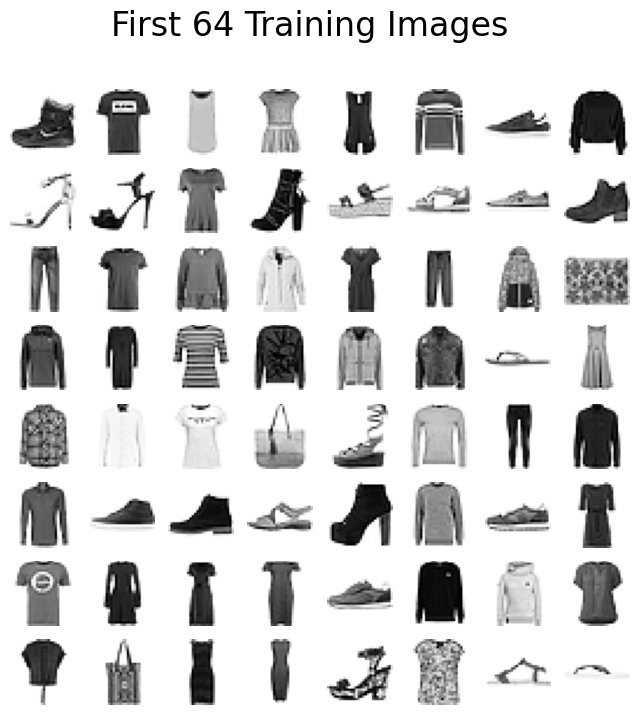

In [3]:
# Use the following code to load and normalize the dataset for training and testing
# It will downlad the dataset into data subfolder (change to your data folder name)
train_dataset = torchvision.datasets.FashionMNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_dataset = torchvision.datasets.FashionMNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


# Use the following code to create a validation set of 10%
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=0.1,
)

# Generate training and validation subsets based on indices
train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)


# set batches sizes
train_batch_size = 512 #Define train batch size
test_batch_size  = 256 #Define test batch size (can be larger than train batch size)


# Define dataloader objects that help to iterate over batches and samples for
# training, validation and testing
train_batches = DataLoader(train_split, batch_size=train_batch_size, shuffle=True)
val_batches = DataLoader(val_split, batch_size=train_batch_size, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
                                           
num_train_batches=len(train_batches)
num_val_batches=len(val_batches)
num_test_batches=len(test_batches)


print(num_train_batches)
print(num_val_batches)
print(num_test_batches)


#Sample code to visulaize the first sample in first 16 batches 

# batch_num = 0
# for train_features, train_labels in train_batches:
    
#     if batch_num == 16:
#         break    # break here
    
#     batch_num = batch_num +1
#     print(f"Feature batch shape: {train_features.size()}")
#     print(f"Labels batch shape: {train_labels.size()}")
    
#     img = train_features[0].squeeze()
#     label = train_labels[0]
#     plt.imshow(img, cmap="gray")
#     plt.show()
#     print(f"Label: {label}")



# Sample code to plot N^2 images from the dataset
def plot_images(XX, N, title):
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[(N)*i+j], cmap="Greys")
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)

plot_images(train_dataset.data[:64], 8, "First 64 Training Images" )

    

## Define Model

In [4]:
#Define your (As Cool As It Gets) Fully Connected Neural Network 
class ACAIGFCN(nn.Module):
    #Initialize model layers, add additional arguments to adjust
    def __init__(self, input_dim, hidden_layers, output_dim): 
        super(ACAIGFCN, self).__init__()
        #Define the network layer(s) and activation function(s)
        layers = []
        prev_dim = input_dim

        # Add hidden layers
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_size))
            layers.append(nn.ReLU())
            prev_dim = hidden_size 

        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

 
    def forward(self, input):
        #Define how your model propagates the input through the network
        return self.model(input)


In [5]:

def training(hidden_layers, learning_rate, epochs, optim):
    # Initialize neural network model with input, output and hidden layer dimensions
    model = ACAIGFCN(input_dim = 784, hidden_layers = hidden_layers, output_dim = 10) #... add more parameters

    train_loss_list = np.zeros((epochs,))
    validation_accuracy_list = np.zeros((epochs,))

    final_val_acc_list = []

    # Define loss function  and optimizer
    loss_func = nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 
    
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)# Use optimizers from torch.optim

    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    else: #RMSprop
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    


    # Iterate over epochs, batches with progress bar and train+ validate the ACAIGFCN
    # Track the loss and validation accuracy
    for epoch in tqdm.trange(epochs):

        running_loss = 0.0

        # ACAIGFCN Training 
        for train_features, train_labels in train_batches:
            # Set model into training mode
            model.train()
            
            # Reshape images into a vector
            train_features = train_features.reshape(-1, 28*28)

            # Reset gradients, Calculate training loss on model 
            optimizer.zero_grad()
            output = model(train_features)
            loss = loss_func(output, train_labels) #Loss/error

            # Perfrom optimization, back propagation
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
    
        # Record loss for the epoch
        train_loss_list[epoch] = running_loss / len(train_batches)
        
        val_acc_sum = 0
        
        # ACAIGFCN Validation
        for val_features, val_labels in val_batches:
            
            # Telling PyTorch we aren't passing inputs to network for training purpose
            with torch.no_grad(): 
                model.eval()
                
                # Reshape validation images into a vector
                val_features = val_features.reshape(-1, 28*28)
            
                # Compute validation outputs (targets) 
                output = model(val_features)
                _, predicted = torch.max(output, 1)

                # and compute accuracy 
                val_acc = accuracy_score(val_labels, predicted)
                val_acc_sum += val_acc
        validation_accuracy_list[epoch] = val_acc_sum

        validation_accuracies = val_acc_sum/num_val_batches*100
        final_val_acc_list.append(validation_accuracies)

        # Record accuracy for the epoch; print training loss, validation accuracy
        print("Epoch: "+ str(epoch) +"; Validation Accuracy:" + str(validation_accuracies) + '%')

    return model, train_loss_list, final_val_acc_list

## Baseline Model

In [6]:
lay1 = [128, 512, 64]
lay2 = [128, 128]
lay3 = [64, 64]
lay4 = [1024, 512]

epoch_ex = 25

In [ ]:
model, train_loss_example, val_accuracy_list_example = training(hidden_layers = lay3, learning_rate = 0.1, epochs = epoch_ex, optim='SGD')

  4%|▍         | 1/25 [00:10<04:02, 10.10s/it]

Epoch: 0; Validation Accuracy:76.33463541666666%


  8%|▊         | 2/25 [00:19<03:43,  9.70s/it]

Epoch: 1; Validation Accuracy:78.56303781702898%


 12%|█▏        | 3/25 [00:28<03:26,  9.38s/it]

Epoch: 2; Validation Accuracy:83.18897192028986%


 16%|█▌        | 4/25 [00:37<03:14,  9.25s/it]

Epoch: 3; Validation Accuracy:82.7346580615942%


 20%|██        | 5/25 [00:46<03:04,  9.23s/it]

Epoch: 4; Validation Accuracy:83.21940104166666%


 24%|██▍       | 6/25 [00:55<02:53,  9.15s/it]

Epoch: 5; Validation Accuracy:85.49167798913044%


 28%|██▊       | 7/25 [01:04<02:43,  9.10s/it]

Epoch: 6; Validation Accuracy:86.7385643115942%


 32%|███▏      | 8/25 [01:13<02:34,  9.07s/it]

Epoch: 7; Validation Accuracy:85.84055140398551%


 36%|███▌      | 9/25 [01:22<02:25,  9.07s/it]

Epoch: 8; Validation Accuracy:87.20420063405797%


 40%|████      | 10/25 [01:31<02:15,  9.06s/it]

Epoch: 9; Validation Accuracy:82.84434442934781%


 44%|████▍     | 11/25 [01:41<02:08,  9.16s/it]

Epoch: 10; Validation Accuracy:86.28637341485508%


 48%|████▊     | 12/25 [01:52<02:06,  9.75s/it]

Epoch: 11; Validation Accuracy:86.57651154891303%


 52%|█████▏    | 13/25 [02:02<01:57,  9.82s/it]

Epoch: 12; Validation Accuracy:87.49646173007247%


 56%|█████▌    | 14/25 [02:12<01:49, 10.00s/it]

Epoch: 13; Validation Accuracy:87.22047667572464%


 60%|██████    | 15/25 [02:23<01:40, 10.09s/it]

Epoch: 14; Validation Accuracy:86.81074501811595%


 64%|██████▍   | 16/25 [02:32<01:28,  9.84s/it]

Epoch: 15; Validation Accuracy:87.5403362771739%


 68%|██████▊   | 17/25 [02:41<01:17,  9.67s/it]

Epoch: 16; Validation Accuracy:88.09159873188405%


 72%|███████▏  | 18/25 [02:50<01:06,  9.53s/it]

Epoch: 17; Validation Accuracy:88.07815330615942%


 76%|███████▌  | 19/25 [02:59<00:56,  9.41s/it]

Epoch: 18; Validation Accuracy:87.09380661231884%


 80%|████████  | 20/25 [03:09<00:46,  9.40s/it]

Epoch: 19; Validation Accuracy:87.9967730978261%


 84%|████████▍ | 21/25 [03:18<00:37,  9.37s/it]

Epoch: 20; Validation Accuracy:88.10221354166666%


 88%|████████▊ | 22/25 [03:27<00:27,  9.29s/it]

Epoch: 21; Validation Accuracy:88.37182971014492%


 92%|█████████▏| 23/25 [03:36<00:18,  9.27s/it]

Epoch: 22; Validation Accuracy:88.47090126811595%


 96%|█████████▌| 24/25 [03:46<00:09,  9.22s/it]

Epoch: 23; Validation Accuracy:88.25577445652173%


100%|██████████| 25/25 [03:55<00:00,  9.41s/it]

Epoch: 24; Validation Accuracy:88.72353374094203%


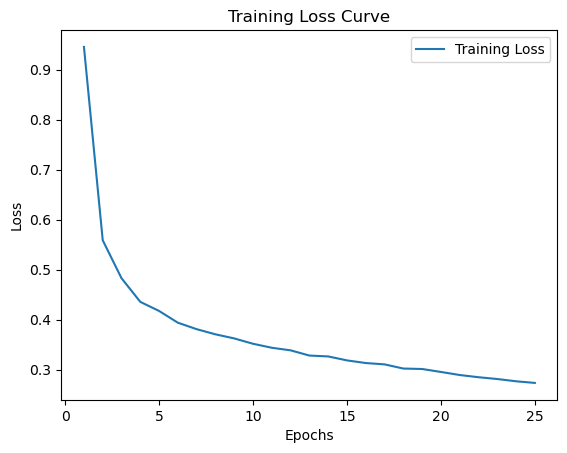

In [8]:
# Plot training loss and validation accuracy throughout the training epochs
# Plot training loss
plt.plot(range(1, epoch_ex + 1), train_loss_example, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

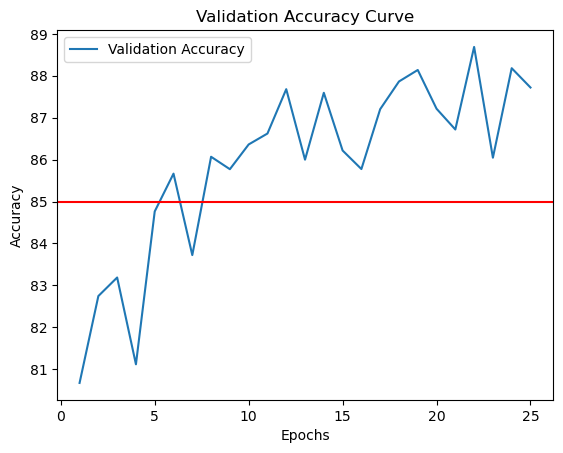

In [9]:
plt.plot(range(1, epoch_ex + 1), val_accuracy_list_example, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.axhline(y=85, color='r')
plt.show()



In [10]:
#Calculate accuracy on test set

# Telling PyTorch we aren't passing inputs to network for training purpose
with torch.no_grad():
    
    test_acc_sum = 0
    test_acc_list = []

    for test_features, test_labels in test_batches:

        model.eval()
        
        # Reshape test images into a vector
        test_features = test_features.reshape(-1, 28*28)

        # Compute validation outputs (targets) 
        test_output = model(test_features)
        _, test_predicted = torch.max(test_output, 1)

        # and compute accuracy 
        test_acc = accuracy_score(test_labels, test_predicted)
        test_acc_sum += test_acc
        test_acc_list.append(test_acc)
                
    # Record mean accuracy, standard deviation of batch accuracies
    print("Test Accuracy: " + str(test_acc_sum/num_test_batches*100) + '%', "; Std of batch accuracies: "+ str(np.std(test_acc_list)))



Test Accuracy: 86.69921875% ; Std of batch accuracies: 0.016709209821864517


## SGD 
LR Comparison

  2%|▏         | 1/50 [00:11<09:22, 11.48s/it]

Epoch: 0; Validation Accuracy:55.67538496376812%


  4%|▍         | 2/50 [00:22<08:55, 11.15s/it]

Epoch: 1; Validation Accuracy:75.03255208333334%


  6%|▌         | 3/50 [00:32<08:25, 10.75s/it]

Epoch: 2; Validation Accuracy:81.60453464673913%


  8%|▊         | 4/50 [00:43<08:15, 10.77s/it]

Epoch: 3; Validation Accuracy:81.12616055253623%


 10%|█         | 5/50 [00:53<07:45, 10.34s/it]

Epoch: 4; Validation Accuracy:83.66026947463769%


 12%|█▏        | 6/50 [01:02<07:17,  9.95s/it]

Epoch: 5; Validation Accuracy:84.95103034420289%


 14%|█▍        | 7/50 [01:11<07:01,  9.81s/it]

Epoch: 6; Validation Accuracy:83.6708842844203%


 16%|█▌        | 8/50 [01:21<06:47,  9.71s/it]

Epoch: 7; Validation Accuracy:83.87539628623189%


 18%|█▊        | 9/50 [01:30<06:35,  9.64s/it]

Epoch: 8; Validation Accuracy:86.31751019021738%


 20%|██        | 10/50 [01:40<06:21,  9.53s/it]

Epoch: 9; Validation Accuracy:83.93979279891303%


 22%|██▏       | 11/50 [01:49<06:09,  9.48s/it]

Epoch: 10; Validation Accuracy:85.43081974637681%


 24%|██▍       | 12/50 [01:58<05:57,  9.40s/it]

Epoch: 11; Validation Accuracy:86.72158061594203%


 26%|██▌       | 13/50 [02:07<05:47,  9.39s/it]

Epoch: 12; Validation Accuracy:86.27646625905797%


 28%|██▊       | 14/50 [02:17<05:37,  9.39s/it]

Epoch: 13; Validation Accuracy:81.52032382246377%


 30%|███       | 15/50 [02:26<05:27,  9.36s/it]

Epoch: 14; Validation Accuracy:87.33723958333334%


 32%|███▏      | 16/50 [02:35<05:17,  9.33s/it]

Epoch: 15; Validation Accuracy:87.22047667572464%


 34%|███▍      | 17/50 [02:45<05:07,  9.32s/it]

Epoch: 16; Validation Accuracy:85.40817481884058%


 36%|███▌      | 18/50 [02:54<04:58,  9.32s/it]

Epoch: 17; Validation Accuracy:87.60473278985508%


 38%|███▊      | 19/50 [03:03<04:47,  9.27s/it]

Epoch: 18; Validation Accuracy:86.08539968297102%


 40%|████      | 20/50 [03:12<04:37,  9.25s/it]

Epoch: 19; Validation Accuracy:87.49080049818842%


 42%|████▏     | 21/50 [03:24<04:50, 10.02s/it]

Epoch: 20; Validation Accuracy:85.13077445652173%


 44%|████▍     | 22/50 [03:35<04:50, 10.39s/it]

Epoch: 21; Validation Accuracy:87.39951313405797%


 46%|████▌     | 23/50 [03:47<04:51, 10.80s/it]

Epoch: 22; Validation Accuracy:86.48876245471014%


 48%|████▊     | 24/50 [03:57<04:31, 10.45s/it]

Epoch: 23; Validation Accuracy:86.71945765398551%


 50%|█████     | 25/50 [04:06<04:14, 10.17s/it]

Epoch: 24; Validation Accuracy:87.57147305253623%


 52%|█████▏    | 26/50 [04:16<03:58,  9.94s/it]

Epoch: 25; Validation Accuracy:87.84887341485508%


 54%|█████▍    | 27/50 [04:25<03:43,  9.71s/it]

Epoch: 26; Validation Accuracy:86.93175384963769%


 56%|█████▌    | 28/50 [04:34<03:30,  9.56s/it]

Epoch: 27; Validation Accuracy:86.89212522644928%


 58%|█████▊    | 29/50 [04:43<03:17,  9.40s/it]

Epoch: 28; Validation Accuracy:87.02091825181158%


 60%|██████    | 30/50 [04:52<03:06,  9.33s/it]

Epoch: 29; Validation Accuracy:87.6379925271739%


 62%|██████▏   | 31/50 [05:01<02:55,  9.25s/it]

Epoch: 30; Validation Accuracy:86.88009510869566%


 64%|██████▍   | 32/50 [05:10<02:45,  9.20s/it]

Epoch: 31; Validation Accuracy:87.53255208333334%


 66%|██████▌   | 33/50 [05:20<02:35,  9.17s/it]

Epoch: 32; Validation Accuracy:88.05338541666666%


 68%|██████▊   | 34/50 [05:29<02:26,  9.18s/it]

Epoch: 33; Validation Accuracy:88.08310688405797%


 70%|███████   | 35/50 [05:38<02:17,  9.18s/it]

Epoch: 34; Validation Accuracy:85.60561028079711%


 72%|███████▏  | 36/50 [05:47<02:07,  9.14s/it]

Epoch: 35; Validation Accuracy:87.4794780344203%


 74%|███████▍  | 37/50 [05:56<01:58,  9.15s/it]

Epoch: 36; Validation Accuracy:83.87751924818842%


 76%|███████▌  | 38/50 [06:05<01:49,  9.13s/it]

Epoch: 37; Validation Accuracy:85.47257133152173%


 78%|███████▊  | 39/50 [06:14<01:40,  9.10s/it]

Epoch: 38; Validation Accuracy:86.62817028985508%


 80%|████████  | 40/50 [06:23<01:31,  9.11s/it]

Epoch: 39; Validation Accuracy:88.11990489130434%


 82%|████████▏ | 41/50 [06:32<01:21,  9.08s/it]

Epoch: 40; Validation Accuracy:86.34227807971014%


 84%|████████▍ | 42/50 [06:42<01:13,  9.15s/it]

Epoch: 41; Validation Accuracy:89.09363677536231%


 86%|████████▌ | 43/50 [06:51<01:03,  9.13s/it]

Epoch: 42; Validation Accuracy:88.07673799818842%


 88%|████████▊ | 44/50 [07:00<00:54,  9.11s/it]

Epoch: 43; Validation Accuracy:87.12635869565219%


 90%|█████████ | 45/50 [07:09<00:45,  9.07s/it]

Epoch: 44; Validation Accuracy:85.83772078804347%


 92%|█████████▏| 46/50 [07:18<00:36,  9.09s/it]

Epoch: 45; Validation Accuracy:87.32237884963769%


 94%|█████████▍| 47/50 [07:27<00:27,  9.11s/it]

Epoch: 46; Validation Accuracy:87.70805027173913%


 96%|█████████▌| 48/50 [07:36<00:18,  9.13s/it]

Epoch: 47; Validation Accuracy:88.07249207427536%


 98%|█████████▊| 49/50 [07:45<00:09,  9.13s/it]

Epoch: 48; Validation Accuracy:80.95420063405797%


100%|██████████| 50/50 [07:55<00:00,  9.50s/it]

Epoch: 49; Validation Accuracy:88.0088032155797%


SGD Test Accuracy: 86.953125% ; Std of batch accuracies: 0.02115875400617319


  2%|▏         | 1/50 [00:09<07:33,  9.25s/it]

Epoch: 0; Validation Accuracy:75.10473278985508%


  4%|▍         | 2/50 [00:18<07:19,  9.16s/it]

Epoch: 1; Validation Accuracy:78.33021965579711%


  6%|▌         | 3/50 [00:27<07:08,  9.11s/it]

Epoch: 2; Validation Accuracy:83.9638530344203%


  8%|▊         | 4/50 [00:36<06:58,  9.10s/it]

Epoch: 3; Validation Accuracy:84.68990602355072%


 10%|█         | 5/50 [00:45<06:52,  9.17s/it]

Epoch: 4; Validation Accuracy:84.58517323369566%


 12%|█▏        | 6/50 [00:54<06:42,  9.15s/it]

Epoch: 5; Validation Accuracy:85.08902287137681%


 14%|█▍        | 7/50 [01:04<06:33,  9.15s/it]

Epoch: 6; Validation Accuracy:86.27505095108697%


 16%|█▌        | 8/50 [01:13<06:27,  9.23s/it]

Epoch: 7; Validation Accuracy:86.60906363224638%


 18%|█▊        | 9/50 [01:22<06:16,  9.19s/it]

Epoch: 8; Validation Accuracy:84.07778532608697%


 20%|██        | 10/50 [01:31<06:05,  9.15s/it]

Epoch: 9; Validation Accuracy:85.33316349637681%


 22%|██▏       | 11/50 [01:40<05:56,  9.13s/it]

Epoch: 10; Validation Accuracy:87.2848731884058%


 24%|██▍       | 12/50 [01:49<05:47,  9.14s/it]

Epoch: 11; Validation Accuracy:87.21269248188405%


 26%|██▌       | 13/50 [01:58<05:36,  9.11s/it]

Epoch: 12; Validation Accuracy:84.11882925724638%


 28%|██▊       | 14/50 [02:08<05:28,  9.13s/it]

Epoch: 13; Validation Accuracy:87.08460711050724%


 30%|███       | 15/50 [02:17<05:18,  9.10s/it]

Epoch: 14; Validation Accuracy:87.0032269021739%


 32%|███▏      | 16/50 [02:26<05:08,  9.07s/it]

Epoch: 15; Validation Accuracy:86.60623301630434%


 34%|███▍      | 17/50 [02:35<04:59,  9.06s/it]

Epoch: 16; Validation Accuracy:87.23392210144928%


 36%|███▌      | 18/50 [02:44<04:51,  9.11s/it]

Epoch: 17; Validation Accuracy:87.27496603260869%


 38%|███▊      | 19/50 [02:53<04:43,  9.14s/it]

Epoch: 18; Validation Accuracy:86.2594825634058%


 40%|████      | 20/50 [03:02<04:33,  9.12s/it]

Epoch: 19; Validation Accuracy:88.10433650362319%


 42%|████▏     | 21/50 [03:11<04:24,  9.11s/it]

Epoch: 20; Validation Accuracy:85.83347486413044%


 44%|████▍     | 22/50 [03:20<04:14,  9.10s/it]

Epoch: 21; Validation Accuracy:87.19287817028986%


 46%|████▌     | 23/50 [03:29<04:05,  9.10s/it]

Epoch: 22; Validation Accuracy:88.17934782608697%


 48%|████▊     | 24/50 [03:38<03:55,  9.06s/it]

Epoch: 23; Validation Accuracy:86.97987432065219%


 50%|█████     | 25/50 [03:48<03:47,  9.10s/it]

Epoch: 24; Validation Accuracy:88.45887115036231%


 52%|█████▏    | 26/50 [03:57<03:39,  9.14s/it]

Epoch: 25; Validation Accuracy:88.2727581521739%


 54%|█████▍    | 27/50 [04:06<03:29,  9.11s/it]

Epoch: 26; Validation Accuracy:87.55590466485508%


 56%|█████▌    | 28/50 [04:15<03:20,  9.10s/it]

Epoch: 27; Validation Accuracy:88.4362262228261%


 58%|█████▊    | 29/50 [04:24<03:11,  9.10s/it]

Epoch: 28; Validation Accuracy:87.06125452898551%


 60%|██████    | 30/50 [04:33<03:02,  9.12s/it]

Epoch: 29; Validation Accuracy:87.80712182971014%


 62%|██████▏   | 31/50 [04:42<02:53,  9.11s/it]

Epoch: 30; Validation Accuracy:87.95855978260869%


 64%|██████▍   | 32/50 [04:52<02:45,  9.17s/it]

Epoch: 31; Validation Accuracy:88.99173460144928%


 66%|██████▌   | 33/50 [05:01<02:35,  9.14s/it]

Epoch: 32; Validation Accuracy:88.1142436594203%


 68%|██████▊   | 34/50 [05:10<02:25,  9.12s/it]

Epoch: 33; Validation Accuracy:89.0341938405797%


 70%|███████   | 35/50 [05:19<02:16,  9.09s/it]

Epoch: 34; Validation Accuracy:88.53742074275362%


 72%|███████▏  | 36/50 [05:28<02:08,  9.15s/it]

Epoch: 35; Validation Accuracy:87.98403532608697%


 74%|███████▍  | 37/50 [05:37<01:58,  9.14s/it]

Epoch: 36; Validation Accuracy:89.24436707427536%


 76%|███████▌  | 38/50 [05:46<01:49,  9.13s/it]

Epoch: 37; Validation Accuracy:88.23171422101449%


 78%|███████▊  | 39/50 [05:56<01:41,  9.20s/it]

Epoch: 38; Validation Accuracy:88.23596014492753%


 80%|████████  | 40/50 [06:05<01:31,  9.17s/it]

Epoch: 39; Validation Accuracy:87.93733016304347%


 82%|████████▏ | 41/50 [06:14<01:23,  9.30s/it]

Epoch: 40; Validation Accuracy:88.88629415760869%


 84%|████████▍ | 42/50 [06:24<01:14,  9.35s/it]

Epoch: 41; Validation Accuracy:87.18297101449276%


 86%|████████▌ | 43/50 [06:33<01:05,  9.35s/it]

Epoch: 42; Validation Accuracy:88.99810348731884%


 88%|████████▊ | 44/50 [06:42<00:55,  9.28s/it]

Epoch: 43; Validation Accuracy:89.36042232789855%


 90%|█████████ | 45/50 [06:51<00:46,  9.23s/it]

Epoch: 44; Validation Accuracy:89.45595561594203%


 92%|█████████▏| 46/50 [07:01<00:36,  9.21s/it]

Epoch: 45; Validation Accuracy:88.46665534420289%


 94%|█████████▍| 47/50 [07:10<00:27,  9.26s/it]

Epoch: 46; Validation Accuracy:89.50832201086956%


 96%|█████████▌| 48/50 [07:19<00:18,  9.25s/it]

Epoch: 47; Validation Accuracy:87.16811028079711%


 98%|█████████▊| 49/50 [07:28<00:09,  9.22s/it]

Epoch: 48; Validation Accuracy:88.86647984601449%


100%|██████████| 50/50 [07:37<00:00,  9.16s/it]

Epoch: 49; Validation Accuracy:88.33432404891303%


SGD Test Accuracy: 87.099609375% ; Std of batch accuracies: 0.021669787646750798


  2%|▏         | 1/50 [00:09<07:25,  9.10s/it]

Epoch: 0; Validation Accuracy:61.54395946557971%


  4%|▍         | 2/50 [00:18<07:28,  9.33s/it]

Epoch: 1; Validation Accuracy:65.23012907608695%


  6%|▌         | 3/50 [00:27<07:18,  9.33s/it]

Epoch: 2; Validation Accuracy:68.09258944746377%


  8%|▊         | 4/50 [00:36<07:04,  9.23s/it]

Epoch: 3; Validation Accuracy:73.14240828804347%


 10%|█         | 5/50 [00:46<06:52,  9.16s/it]

Epoch: 4; Validation Accuracy:76.19027400362319%


 12%|█▏        | 6/50 [00:55<06:43,  9.17s/it]

Epoch: 5; Validation Accuracy:78.27926856884058%


 14%|█▍        | 7/50 [01:04<06:37,  9.24s/it]

Epoch: 6; Validation Accuracy:80.04203464673913%


 16%|█▌        | 8/50 [01:13<06:25,  9.19s/it]

Epoch: 7; Validation Accuracy:80.78011775362319%


 18%|█▊        | 9/50 [01:22<06:15,  9.15s/it]

Epoch: 8; Validation Accuracy:81.06742527173913%


 20%|██        | 10/50 [01:31<06:04,  9.11s/it]

Epoch: 9; Validation Accuracy:81.53164628623189%


 22%|██▏       | 11/50 [01:41<05:57,  9.17s/it]

Epoch: 10; Validation Accuracy:81.97676064311595%


 24%|██▍       | 12/50 [01:50<05:50,  9.23s/it]

Epoch: 11; Validation Accuracy:82.2265625%


 26%|██▌       | 13/50 [01:59<05:41,  9.22s/it]

Epoch: 12; Validation Accuracy:82.1572124094203%


 28%|██▊       | 14/50 [02:08<05:30,  9.18s/it]

Epoch: 13; Validation Accuracy:83.05310235507247%


 30%|███       | 15/50 [02:17<05:20,  9.15s/it]

Epoch: 14; Validation Accuracy:83.41046761775362%


 32%|███▏      | 16/50 [02:27<05:11,  9.17s/it]

Epoch: 15; Validation Accuracy:83.51803102355072%


 34%|███▍      | 17/50 [02:36<05:01,  9.13s/it]

Epoch: 16; Validation Accuracy:83.86902740036231%


 36%|███▌      | 18/50 [02:45<04:51,  9.11s/it]

Epoch: 17; Validation Accuracy:83.90299479166666%


 38%|███▊      | 19/50 [02:54<04:42,  9.11s/it]

Epoch: 18; Validation Accuracy:84.32758718297102%


 40%|████      | 20/50 [03:03<04:32,  9.09s/it]

Epoch: 19; Validation Accuracy:83.91360960144928%


 42%|████▏     | 21/50 [03:12<04:23,  9.09s/it]

Epoch: 20; Validation Accuracy:84.26248301630434%


 44%|████▍     | 22/50 [03:21<04:16,  9.14s/it]

Epoch: 21; Validation Accuracy:84.40259850543478%


 46%|████▌     | 23/50 [03:31<04:15,  9.46s/it]

Epoch: 22; Validation Accuracy:84.71891983695653%


 48%|████▊     | 24/50 [03:40<04:01,  9.28s/it]

Epoch: 23; Validation Accuracy:85.09822237318842%


 50%|█████     | 25/50 [03:49<03:47,  9.11s/it]

Epoch: 24; Validation Accuracy:85.24399909420289%


 52%|█████▏    | 26/50 [03:58<03:34,  8.96s/it]

Epoch: 25; Validation Accuracy:84.69910552536231%


 54%|█████▍    | 27/50 [04:06<03:23,  8.83s/it]

Epoch: 26; Validation Accuracy:84.75430253623189%


 56%|█████▌    | 28/50 [04:15<03:13,  8.77s/it]

Epoch: 27; Validation Accuracy:85.26522871376811%


 58%|█████▊    | 29/50 [04:23<03:03,  8.72s/it]

Epoch: 28; Validation Accuracy:85.13218976449276%


 60%|██████    | 30/50 [04:32<02:54,  8.74s/it]

Epoch: 29; Validation Accuracy:85.86673460144928%


 62%|██████▏   | 31/50 [04:41<02:45,  8.68s/it]

Epoch: 30; Validation Accuracy:85.47327898550724%


 64%|██████▍   | 32/50 [04:49<02:35,  8.67s/it]

Epoch: 31; Validation Accuracy:85.83842844202898%


 66%|██████▌   | 33/50 [04:58<02:26,  8.63s/it]

Epoch: 32; Validation Accuracy:85.35722373188405%


 68%|██████▊   | 34/50 [05:06<02:18,  8.63s/it]

Epoch: 33; Validation Accuracy:85.75634057971014%


 70%|███████   | 35/50 [05:15<02:09,  8.62s/it]

Epoch: 34; Validation Accuracy:85.83347486413044%


 72%|███████▏  | 36/50 [05:24<02:00,  8.62s/it]

Epoch: 35; Validation Accuracy:85.95872961956522%


 74%|███████▍  | 37/50 [05:32<01:52,  8.63s/it]

Epoch: 36; Validation Accuracy:85.89079483695653%


 76%|███████▌  | 38/50 [05:41<01:43,  8.62s/it]

Epoch: 37; Validation Accuracy:85.45912590579711%


 78%|███████▊  | 39/50 [05:49<01:34,  8.60s/it]

Epoch: 38; Validation Accuracy:85.87239583333334%


 80%|████████  | 40/50 [05:58<01:26,  8.61s/it]

Epoch: 39; Validation Accuracy:85.90282495471014%


 82%|████████▏ | 41/50 [06:07<01:17,  8.59s/it]

Epoch: 40; Validation Accuracy:86.45833333333334%


 84%|████████▍ | 42/50 [06:15<01:08,  8.60s/it]

Epoch: 41; Validation Accuracy:86.15545742753623%


 86%|████████▌ | 43/50 [06:24<01:00,  8.62s/it]

Epoch: 42; Validation Accuracy:86.6989356884058%


 88%|████████▊ | 44/50 [06:33<00:51,  8.61s/it]

Epoch: 43; Validation Accuracy:86.47036345108697%


 90%|█████████ | 45/50 [06:41<00:42,  8.59s/it]

Epoch: 44; Validation Accuracy:86.49654664855072%


 92%|█████████▏| 46/50 [06:50<00:34,  8.66s/it]

Epoch: 45; Validation Accuracy:86.02312613224638%


 94%|█████████▍| 47/50 [06:58<00:25,  8.62s/it]

Epoch: 46; Validation Accuracy:86.60764832427536%


 96%|█████████▌| 48/50 [07:07<00:17,  8.61s/it]

Epoch: 47; Validation Accuracy:86.49796195652173%


 98%|█████████▊| 49/50 [07:16<00:08,  8.61s/it]

Epoch: 48; Validation Accuracy:86.61755548007247%


100%|██████████| 50/50 [07:24<00:00,  8.90s/it]

Epoch: 49; Validation Accuracy:86.61472486413044%


SGD Test Accuracy: 84.755859375% ; Std of batch accuracies: 0.023639873364104523


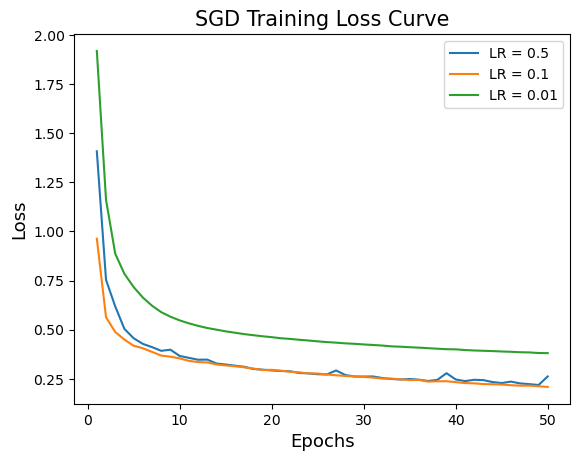

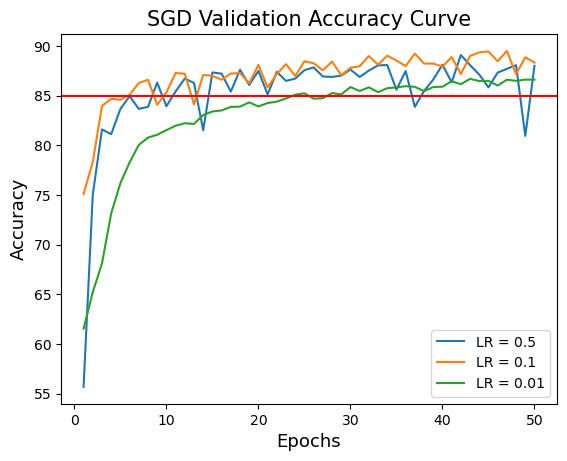

In [21]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

epoch_num = 50

for lr in [0.5, 0.1, 0.01]:

    model1, train_loss_sgd, val_accuracy_list_sgd = training(hidden_layers = lay3, learning_rate = lr, epochs = epoch_num, optim = 'SGD')

    ax1.plot(range(1, epoch_num + 1), train_loss_sgd, label='Training Loss')
    ax2.plot(range(1, epoch_num + 1), val_accuracy_list_sgd, label='Validation Accuracy')

    # Telling PyTorch we aren't passing inputs to network for training purpose
    with torch.no_grad():
        
        SGD_test_acc_sum = 0
        SGD_test_acc_list = []

        for test_features, test_labels in test_batches:

            model1.eval()
            
            # reshape test images into vector
            test_features = test_features.reshape(-1, 28*28)

            # compute validation outputs 
            test_output = model1(test_features)
            _, test_predicted = torch.max(test_output, 1)

            #  compute accuracy 
            SGD_test_acc = accuracy_score(test_labels, test_predicted)
            SGD_test_acc_sum += SGD_test_acc
            SGD_test_acc_list.append(SGD_test_acc)
                    
        #  mean accuracy, standard deviation of batch accuracies
        print("SGD Test Accuracy: " + str(SGD_test_acc_sum/num_test_batches*100) + '%', "; Std of batch accuracies: "+ str(np.std(SGD_test_acc_list)))

ax1.set_xlabel('Epochs',fontsize=13)
ax1.set_ylabel('Loss',fontsize=13)
ax1.set_title('SGD Training Loss Curve',fontsize=15)
ax1.legend(["LR = 0.5", "LR = 0.1", "LR = 0.01"])

    
ax2.set_xlabel('Epochs',fontsize=13)
ax2.set_ylabel('Accuracy',fontsize=13)
ax2.set_title('SGD Validation Accuracy Curve',fontsize=15)
ax2.axhline(y=85, color='r')
ax2.legend(["LR = 0.5", "LR = 0.1", "LR = 0.01"])

plt.show()

The best performing learning rate for SGD with 50 epochs is 0.1

In [ ]:
 # how I'm calculating standard dev - would it make more sense across trials not batches??

### ADAM
LR Comparison

  2%|▏         | 1/50 [00:09<07:49,  9.58s/it]

Epoch: 0; Validation Accuracy:45.97911005434783%


  4%|▍         | 2/50 [00:19<07:58,  9.97s/it]

Epoch: 1; Validation Accuracy:44.870923913043484%


  6%|▌         | 3/50 [00:29<07:38,  9.76s/it]

Epoch: 2; Validation Accuracy:53.97843070652174%


  8%|▊         | 4/50 [00:38<07:22,  9.62s/it]

Epoch: 3; Validation Accuracy:53.604789402173914%


 10%|█         | 5/50 [00:48<07:13,  9.63s/it]

Epoch: 4; Validation Accuracy:49.69641644021739%


 12%|█▏        | 6/50 [00:58<07:04,  9.65s/it]

Epoch: 5; Validation Accuracy:54.00885982789855%


 14%|█▍        | 7/50 [01:07<06:47,  9.49s/it]

Epoch: 6; Validation Accuracy:51.09615602355072%


 16%|█▌        | 8/50 [01:16<06:31,  9.33s/it]

Epoch: 7; Validation Accuracy:49.40769361413044%


 18%|█▊        | 9/50 [01:25<06:20,  9.29s/it]

Epoch: 8; Validation Accuracy:42.47339221014493%


 20%|██        | 10/50 [01:34<06:11,  9.29s/it]

Epoch: 9; Validation Accuracy:37.02374886775362%


 22%|██▏       | 11/50 [01:45<06:18,  9.70s/it]

Epoch: 10; Validation Accuracy:43.74646173007246%


 24%|██▍       | 12/50 [01:55<06:15,  9.88s/it]

Epoch: 11; Validation Accuracy:35.06637794384058%


 26%|██▌       | 13/50 [02:04<05:57,  9.67s/it]

Epoch: 12; Validation Accuracy:31.5132472826087%


 28%|██▊       | 14/50 [02:13<05:41,  9.48s/it]

Epoch: 13; Validation Accuracy:24.420431385869566%


 30%|███       | 15/50 [02:23<05:29,  9.41s/it]

Epoch: 14; Validation Accuracy:28.47599637681159%


 32%|███▏      | 16/50 [02:32<05:23,  9.53s/it]

Epoch: 15; Validation Accuracy:27.719514266304344%


 34%|███▍      | 17/50 [02:42<05:11,  9.43s/it]

Epoch: 16; Validation Accuracy:28.79797894021739%


 36%|███▌      | 18/50 [02:51<04:58,  9.33s/it]

Epoch: 17; Validation Accuracy:28.81213201992753%


 38%|███▊      | 19/50 [03:00<04:49,  9.33s/it]

Epoch: 18; Validation Accuracy:28.7109375%


 40%|████      | 20/50 [03:09<04:37,  9.25s/it]

Epoch: 19; Validation Accuracy:28.328804347826086%


 42%|████▏     | 21/50 [03:18<04:28,  9.27s/it]

Epoch: 20; Validation Accuracy:29.020889945652172%


 44%|████▍     | 22/50 [03:28<04:18,  9.22s/it]

Epoch: 21; Validation Accuracy:28.921110733695656%


 46%|████▌     | 23/50 [03:38<04:16,  9.48s/it]

Epoch: 22; Validation Accuracy:27.82283174818841%


 48%|████▊     | 24/50 [03:48<04:11,  9.67s/it]

Epoch: 23; Validation Accuracy:26.442906476449274%


 50%|█████     | 25/50 [03:57<03:58,  9.54s/it]

Epoch: 24; Validation Accuracy:28.595589900362324%


 52%|█████▏    | 26/50 [04:06<03:46,  9.44s/it]

Epoch: 25; Validation Accuracy:28.296252264492754%


 54%|█████▍    | 27/50 [04:15<03:34,  9.33s/it]

Epoch: 26; Validation Accuracy:28.938802083333332%


 56%|█████▌    | 28/50 [04:25<03:25,  9.35s/it]

Epoch: 27; Validation Accuracy:20.033684329710145%


 58%|█████▊    | 29/50 [04:34<03:14,  9.28s/it]

Epoch: 28; Validation Accuracy:19.79803555253623%


 60%|██████    | 30/50 [04:43<03:05,  9.25s/it]

Epoch: 29; Validation Accuracy:20.00396286231884%


 62%|██████▏   | 31/50 [04:52<02:54,  9.21s/it]

Epoch: 30; Validation Accuracy:19.01678555253623%


 64%|██████▍   | 32/50 [05:01<02:45,  9.21s/it]

Epoch: 31; Validation Accuracy:19.791666666666664%


 66%|██████▌   | 33/50 [05:10<02:36,  9.19s/it]

Epoch: 32; Validation Accuracy:20.136294157608695%


 68%|██████▊   | 34/50 [05:20<02:27,  9.20s/it]

Epoch: 33; Validation Accuracy:19.925413269927535%


 70%|███████   | 35/50 [05:29<02:17,  9.18s/it]

Epoch: 34; Validation Accuracy:19.064906023550723%


 72%|███████▏  | 36/50 [05:38<02:08,  9.19s/it]

Epoch: 35; Validation Accuracy:20.085343070652172%


 74%|███████▍  | 37/50 [05:47<01:59,  9.22s/it]

Epoch: 36; Validation Accuracy:20.05632925724638%


 76%|███████▌  | 38/50 [05:56<01:50,  9.21s/it]

Epoch: 37; Validation Accuracy:19.863847373188406%


 78%|███████▊  | 39/50 [06:06<01:41,  9.19s/it]

Epoch: 38; Validation Accuracy:19.777513586956523%


 80%|████████  | 40/50 [06:15<01:31,  9.17s/it]

Epoch: 39; Validation Accuracy:19.84191009963768%


 82%|████████▏ | 41/50 [06:24<01:22,  9.16s/it]

Epoch: 40; Validation Accuracy:19.89923007246377%


 84%|████████▍ | 42/50 [06:33<01:13,  9.19s/it]

Epoch: 41; Validation Accuracy:19.979902626811594%


 86%|████████▌ | 43/50 [06:42<01:04,  9.20s/it]

Epoch: 42; Validation Accuracy:19.90347599637681%


 88%|████████▊ | 44/50 [06:52<00:56,  9.34s/it]

Epoch: 43; Validation Accuracy:19.959380661231883%


 90%|█████████ | 45/50 [07:01<00:46,  9.33s/it]

Epoch: 44; Validation Accuracy:20.059867527173914%


 92%|█████████▏| 46/50 [07:11<00:37,  9.31s/it]

Epoch: 45; Validation Accuracy:20.046422101449277%


 94%|█████████▍| 47/50 [07:20<00:27,  9.31s/it]

Epoch: 46; Validation Accuracy:20.01457767210145%


 96%|█████████▌| 48/50 [07:29<00:18,  9.26s/it]

Epoch: 47; Validation Accuracy:19.941689311594203%


 98%|█████████▊| 49/50 [07:38<00:09,  9.25s/it]

Epoch: 48; Validation Accuracy:19.94805819746377%


100%|██████████| 50/50 [07:47<00:00,  9.36s/it]

Epoch: 49; Validation Accuracy:19.839079483695656%


Adam Test Accuracy: 20.05859375% ; Std of batch accuracies: 0.025293534320414153


  2%|▏         | 1/50 [00:09<07:26,  9.10s/it]

Epoch: 0; Validation Accuracy:85.40463654891303%


  4%|▍         | 2/50 [00:18<07:20,  9.18s/it]

Epoch: 1; Validation Accuracy:86.28991168478262%


  6%|▌         | 3/50 [00:27<07:15,  9.27s/it]

Epoch: 2; Validation Accuracy:87.47735507246377%


  8%|▊         | 4/50 [00:37<07:16,  9.49s/it]

Epoch: 3; Validation Accuracy:87.36413043478262%


 10%|█         | 5/50 [00:48<07:25,  9.91s/it]

Epoch: 4; Validation Accuracy:88.13264266304347%


 12%|█▏        | 6/50 [00:57<07:08,  9.75s/it]

Epoch: 5; Validation Accuracy:88.59615602355072%


 14%|█▍        | 7/50 [01:07<07:05,  9.90s/it]

Epoch: 6; Validation Accuracy:88.49213088768116%


 16%|█▌        | 8/50 [01:17<06:50,  9.77s/it]

Epoch: 7; Validation Accuracy:88.64781476449276%


 18%|█▊        | 9/50 [01:26<06:33,  9.59s/it]

Epoch: 8; Validation Accuracy:87.77456974637681%


 20%|██        | 10/50 [01:35<06:18,  9.47s/it]

Epoch: 9; Validation Accuracy:88.46311707427536%


 22%|██▏       | 11/50 [01:44<06:04,  9.35s/it]

Epoch: 10; Validation Accuracy:88.77660778985508%


 24%|██▍       | 12/50 [01:54<06:00,  9.49s/it]

Epoch: 11; Validation Accuracy:88.41428894927536%


 26%|██▌       | 13/50 [02:04<05:53,  9.54s/it]

Epoch: 12; Validation Accuracy:88.09867527173913%


 28%|██▊       | 14/50 [02:14<05:49,  9.71s/it]

Epoch: 13; Validation Accuracy:89.06816123188405%


 30%|███       | 15/50 [02:23<05:34,  9.54s/it]

Epoch: 14; Validation Accuracy:89.28187273550724%


 32%|███▏      | 16/50 [02:32<05:22,  9.48s/it]

Epoch: 15; Validation Accuracy:89.33919270833334%


 34%|███▍      | 17/50 [02:42<05:10,  9.40s/it]

Epoch: 16; Validation Accuracy:88.67116734601449%


 36%|███▌      | 18/50 [02:51<04:58,  9.31s/it]

Epoch: 17; Validation Accuracy:88.48646965579711%


 38%|███▊      | 19/50 [03:00<04:46,  9.25s/it]

Epoch: 18; Validation Accuracy:88.5544044384058%


 40%|████      | 20/50 [03:09<04:36,  9.21s/it]

Epoch: 19; Validation Accuracy:89.07806838768116%


 42%|████▏     | 21/50 [03:18<04:27,  9.22s/it]

Epoch: 20; Validation Accuracy:89.21110733695653%


 44%|████▍     | 22/50 [03:28<04:19,  9.26s/it]

Epoch: 21; Validation Accuracy:89.02357903079711%


 46%|████▌     | 23/50 [03:37<04:08,  9.19s/it]

Epoch: 22; Validation Accuracy:89.12689651268116%


 48%|████▊     | 24/50 [03:47<04:12,  9.70s/it]

Epoch: 23; Validation Accuracy:89.45949388586956%


 50%|█████     | 25/50 [03:57<03:59,  9.60s/it]

Epoch: 24; Validation Accuracy:88.52751358695653%


 52%|█████▏    | 26/50 [04:06<03:46,  9.44s/it]

Epoch: 25; Validation Accuracy:89.02711730072464%


 54%|█████▍    | 27/50 [04:15<03:37,  9.48s/it]

Epoch: 26; Validation Accuracy:88.45391757246377%


 56%|█████▌    | 28/50 [04:26<03:33,  9.70s/it]

Epoch: 27; Validation Accuracy:88.70371942934781%


 58%|█████▊    | 29/50 [04:35<03:24,  9.74s/it]

Epoch: 28; Validation Accuracy:88.35272305253623%


 60%|██████    | 30/50 [04:45<03:16,  9.82s/it]

Epoch: 29; Validation Accuracy:88.72565670289855%


 62%|██████▏   | 31/50 [04:56<03:10, 10.04s/it]

Epoch: 30; Validation Accuracy:89.19412364130434%


 64%|██████▍   | 32/50 [05:05<02:56,  9.83s/it]

Epoch: 31; Validation Accuracy:89.39297441123189%


 66%|██████▌   | 33/50 [05:15<02:45,  9.76s/it]

Epoch: 32; Validation Accuracy:88.54732789855072%


 68%|██████▊   | 34/50 [05:24<02:33,  9.61s/it]

Epoch: 33; Validation Accuracy:89.01296422101449%


 70%|███████   | 35/50 [05:34<02:22,  9.52s/it]

Epoch: 34; Validation Accuracy:88.62233922101449%


 72%|███████▏  | 36/50 [05:43<02:13,  9.55s/it]

Epoch: 35; Validation Accuracy:89.05542346014492%


 74%|███████▍  | 37/50 [05:55<02:13, 10.26s/it]

Epoch: 36; Validation Accuracy:89.13255774456522%


 76%|███████▌  | 38/50 [06:05<02:02, 10.22s/it]

Epoch: 37; Validation Accuracy:89.11415874094203%


 78%|███████▊  | 39/50 [06:16<01:55, 10.51s/it]

Epoch: 38; Validation Accuracy:88.73980978260869%


 80%|████████  | 40/50 [06:26<01:43, 10.38s/it]

Epoch: 39; Validation Accuracy:89.16581748188405%


 82%|████████▏ | 41/50 [06:36<01:31, 10.14s/it]

Epoch: 40; Validation Accuracy:88.25789741847827%


 84%|████████▍ | 42/50 [06:46<01:21, 10.21s/it]

Epoch: 41; Validation Accuracy:88.73839447463769%


 86%|████████▌ | 43/50 [06:56<01:10, 10.08s/it]

Epoch: 42; Validation Accuracy:88.96979732789855%


 88%|████████▊ | 44/50 [07:07<01:02, 10.42s/it]

Epoch: 43; Validation Accuracy:89.48992300724638%


 90%|█████████ | 45/50 [07:18<00:51, 10.39s/it]

Epoch: 44; Validation Accuracy:88.8954936594203%


 92%|█████████▏| 46/50 [07:27<00:40, 10.02s/it]

Epoch: 45; Validation Accuracy:89.06179234601449%


 94%|█████████▍| 47/50 [07:36<00:29,  9.82s/it]

Epoch: 46; Validation Accuracy:88.66833673007247%


 96%|█████████▌| 48/50 [07:46<00:19,  9.66s/it]

Epoch: 47; Validation Accuracy:88.38173686594203%


 98%|█████████▊| 49/50 [07:55<00:09,  9.66s/it]

Epoch: 48; Validation Accuracy:88.24799026268116%


100%|██████████| 50/50 [08:04<00:00,  9.70s/it]

Epoch: 49; Validation Accuracy:89.1686480978261%


Adam Test Accuracy: 87.51953125% ; Std of batch accuracies: 0.02388808414178173


  2%|▏         | 1/50 [00:09<07:38,  9.36s/it]

Epoch: 0; Validation Accuracy:82.57968183876811%


  4%|▍         | 2/50 [00:18<07:27,  9.31s/it]

Epoch: 1; Validation Accuracy:85.17323369565219%


  6%|▌         | 3/50 [00:27<07:16,  9.29s/it]

Epoch: 2; Validation Accuracy:85.93537703804347%


  8%|▊         | 4/50 [00:37<07:05,  9.25s/it]

Epoch: 3; Validation Accuracy:86.69964334239131%


 10%|█         | 5/50 [00:46<06:53,  9.18s/it]

Epoch: 4; Validation Accuracy:87.56793478260869%


 12%|█▏        | 6/50 [00:55<06:46,  9.25s/it]

Epoch: 5; Validation Accuracy:87.73494112318842%


 14%|█▍        | 7/50 [01:04<06:36,  9.22s/it]

Epoch: 6; Validation Accuracy:88.3987205615942%


 16%|█▌        | 8/50 [01:13<06:27,  9.24s/it]

Epoch: 7; Validation Accuracy:88.39235167572464%


 18%|█▊        | 9/50 [01:23<06:20,  9.28s/it]

Epoch: 8; Validation Accuracy:88.41428894927536%


 20%|██        | 10/50 [01:32<06:10,  9.26s/it]

Epoch: 9; Validation Accuracy:87.8616111865942%


 22%|██▏       | 11/50 [01:42<06:03,  9.33s/it]

Epoch: 10; Validation Accuracy:88.94856770833334%


 24%|██▍       | 12/50 [01:51<05:51,  9.26s/it]

Epoch: 11; Validation Accuracy:88.99031929347827%


 26%|██▌       | 13/50 [02:00<05:46,  9.37s/it]

Epoch: 12; Validation Accuracy:89.42198822463769%


 28%|██▊       | 14/50 [02:09<05:33,  9.28s/it]

Epoch: 13; Validation Accuracy:88.98819633152173%


 30%|███       | 15/50 [02:19<05:24,  9.28s/it]

Epoch: 14; Validation Accuracy:88.95776721014492%


 32%|███▏      | 16/50 [02:28<05:13,  9.22s/it]

Epoch: 15; Validation Accuracy:89.16157155797102%


 34%|███▍      | 17/50 [02:37<05:04,  9.23s/it]

Epoch: 16; Validation Accuracy:88.89337069746377%


 36%|███▌      | 18/50 [02:46<04:55,  9.24s/it]

Epoch: 17; Validation Accuracy:89.68311254528986%


 38%|███▊      | 19/50 [02:56<04:48,  9.31s/it]

Epoch: 18; Validation Accuracy:88.92663043478262%


 40%|████      | 20/50 [03:05<04:40,  9.33s/it]

Epoch: 19; Validation Accuracy:88.68744338768116%


 42%|████▏     | 21/50 [03:14<04:28,  9.27s/it]

Epoch: 20; Validation Accuracy:89.77581521739131%


 44%|████▍     | 22/50 [03:23<04:18,  9.24s/it]

Epoch: 21; Validation Accuracy:89.28328804347827%


 46%|████▌     | 23/50 [03:32<04:08,  9.20s/it]

Epoch: 22; Validation Accuracy:89.49275362318842%


 48%|████▊     | 24/50 [03:42<03:58,  9.17s/it]

Epoch: 23; Validation Accuracy:89.62083899456522%


 50%|█████     | 25/50 [03:51<03:51,  9.28s/it]

Epoch: 24; Validation Accuracy:89.84728826992753%


 52%|█████▏    | 26/50 [04:02<03:57,  9.90s/it]

Epoch: 25; Validation Accuracy:89.78359941123189%


 54%|█████▍    | 27/50 [04:13<03:50, 10.02s/it]

Epoch: 26; Validation Accuracy:89.90814651268116%


 56%|█████▌    | 28/50 [04:22<03:35,  9.80s/it]

Epoch: 27; Validation Accuracy:90.01500226449276%


 58%|█████▊    | 29/50 [04:32<03:29,  9.96s/it]

Epoch: 28; Validation Accuracy:89.68948143115942%


 60%|██████    | 30/50 [04:42<03:18,  9.91s/it]

Epoch: 29; Validation Accuracy:89.94282155797102%


 62%|██████▏   | 31/50 [04:51<03:04,  9.73s/it]

Epoch: 30; Validation Accuracy:88.76174705615942%


 64%|██████▍   | 32/50 [05:01<02:51,  9.54s/it]

Epoch: 31; Validation Accuracy:89.90602355072464%


 66%|██████▌   | 33/50 [05:10<02:41,  9.47s/it]

Epoch: 32; Validation Accuracy:88.83109714673913%


 68%|██████▊   | 34/50 [05:19<02:30,  9.43s/it]

Epoch: 33; Validation Accuracy:89.67249773550724%


 70%|███████   | 35/50 [05:28<02:20,  9.34s/it]

Epoch: 34; Validation Accuracy:90.19474637681158%


 72%|███████▏  | 36/50 [05:37<02:09,  9.27s/it]

Epoch: 35; Validation Accuracy:90.12539628623189%


 74%|███████▍  | 37/50 [05:47<02:00,  9.26s/it]

Epoch: 36; Validation Accuracy:89.5713032155797%


 76%|███████▌  | 38/50 [05:56<01:50,  9.22s/it]

Epoch: 37; Validation Accuracy:89.55007359601449%


 78%|███████▊  | 39/50 [06:05<01:41,  9.22s/it]

Epoch: 38; Validation Accuracy:89.88620923913044%


 80%|████████  | 40/50 [06:14<01:31,  9.20s/it]

Epoch: 39; Validation Accuracy:89.33990036231884%


 82%|████████▏ | 41/50 [06:23<01:22,  9.19s/it]

Epoch: 40; Validation Accuracy:89.27055027173913%


 84%|████████▍ | 42/50 [06:33<01:13,  9.22s/it]

Epoch: 41; Validation Accuracy:89.70292685688405%


 86%|████████▌ | 43/50 [06:43<01:05,  9.41s/it]

Epoch: 42; Validation Accuracy:90.19969995471014%


 88%|████████▊ | 44/50 [06:52<00:56,  9.35s/it]

Epoch: 43; Validation Accuracy:89.07736073369566%


 90%|█████████ | 45/50 [07:01<00:46,  9.32s/it]

Epoch: 44; Validation Accuracy:90.28461843297102%


 92%|█████████▏| 46/50 [07:10<00:37,  9.27s/it]

Epoch: 45; Validation Accuracy:90.02349411231884%


 94%|█████████▍| 47/50 [07:19<00:27,  9.25s/it]

Epoch: 46; Validation Accuracy:90.00651041666666%


 96%|█████████▌| 48/50 [07:29<00:18,  9.24s/it]

Epoch: 47; Validation Accuracy:89.76873867753623%


 98%|█████████▊| 49/50 [07:38<00:09,  9.24s/it]

Epoch: 48; Validation Accuracy:89.85790307971014%


100%|██████████| 50/50 [07:47<00:00,  9.35s/it]

Epoch: 49; Validation Accuracy:90.21668365036231%


Adam Test Accuracy: 88.193359375% ; Std of batch accuracies: 0.021044638647311063


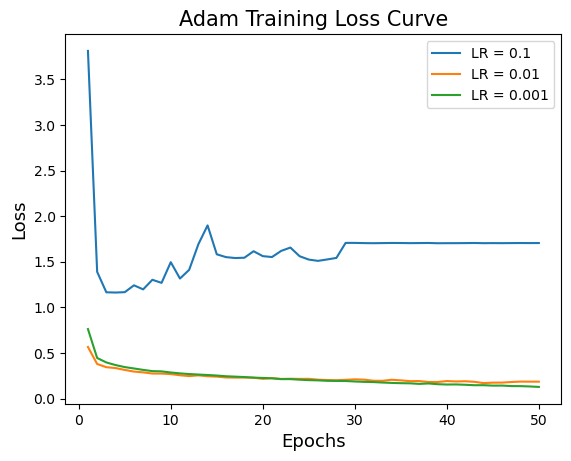

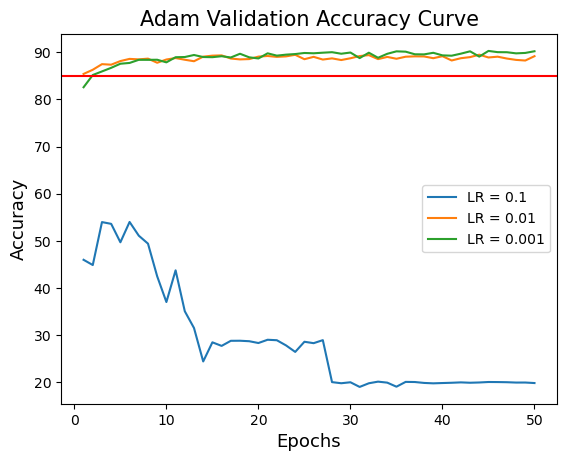

In [17]:
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()

epoch_num = 50

for lr in [0.1, 0.01, 0.001]:

    model2, train_loss_adam, val_accuracy_list_adam = training(hidden_layers = lay3, learning_rate = lr, epochs = epoch_num, optim = 'Adam')

    ax3.plot(range(1, epoch_num + 1), train_loss_adam, label='Training Loss')
    ax4.plot(range(1, epoch_num + 1), val_accuracy_list_adam, label='Validation Accuracy')

    # Telling PyTorch we aren't passing inputs to network for training purpose
    with torch.no_grad():
        
        Adam_test_acc_sum = 0
        Adam_test_acc_list = []

        for test_features, test_labels in test_batches:

            model2.eval()
            
            # reshape test images into vector
            test_features = test_features.reshape(-1, 28*28)

            # compute validation outputs 
            test_output = model2(test_features)
            _, test_predicted = torch.max(test_output, 1)

            #  compute accuracy 
            Adam_test_acc = accuracy_score(test_labels, test_predicted)
            Adam_test_acc_sum += Adam_test_acc
            Adam_test_acc_list.append(Adam_test_acc)
                    
        #  mean accuracy, standard deviation of batch accuracies
        print("Adam Test Accuracy: " + str(Adam_test_acc_sum/num_test_batches*100) + '%', "; Std of batch accuracies: "+ str(np.std(Adam_test_acc_list)))

ax3.set_xlabel('Epochs',fontsize=13)
ax3.set_ylabel('Loss',fontsize=13)
ax3.set_title('Adam Training Loss Curve',fontsize=15)
ax3.legend(["LR = 0.1", "LR = 0.01", "LR = 0.001"])

    
ax4.set_xlabel('Epochs',fontsize=13)
ax4.set_ylabel('Accuracy',fontsize=13)
ax4.set_title('Adam Validation Accuracy Curve',fontsize=15)
ax4.axhline(y=85, color='r')
ax4.legend(["LR = 0.1", "LR = 0.01", "LR = 0.001"])

plt.show()

The best performing learning rate for Adam with 50 epochs is 0.001

### RMSprop
LR Comparison

  2%|▏         | 1/50 [00:12<10:07, 12.39s/it]

Epoch: 0; Validation Accuracy:75.9765625%


  4%|▍         | 2/50 [00:22<08:45, 10.95s/it]

Epoch: 1; Validation Accuracy:79.34641077898551%


  6%|▌         | 3/50 [00:31<08:05, 10.34s/it]

Epoch: 2; Validation Accuracy:80.8678668478261%


  8%|▊         | 4/50 [00:41<07:42, 10.04s/it]

Epoch: 3; Validation Accuracy:83.87256567028986%


 10%|█         | 5/50 [00:52<07:39, 10.21s/it]

Epoch: 4; Validation Accuracy:80.13615262681158%


 12%|█▏        | 6/50 [01:02<07:30, 10.24s/it]

Epoch: 5; Validation Accuracy:83.63833220108697%


 14%|█▍        | 7/50 [01:12<07:25, 10.37s/it]

Epoch: 6; Validation Accuracy:83.15288156702898%


 16%|█▌        | 8/50 [01:22<07:07, 10.18s/it]

Epoch: 7; Validation Accuracy:85.22418478260869%


 18%|█▊        | 9/50 [01:32<06:54, 10.10s/it]

Epoch: 8; Validation Accuracy:83.68999094202898%


 20%|██        | 10/50 [01:42<06:39,  9.99s/it]

Epoch: 9; Validation Accuracy:83.56402853260869%


 22%|██▏       | 11/50 [01:52<06:25,  9.89s/it]

Epoch: 10; Validation Accuracy:80.43053668478262%


 24%|██▍       | 12/50 [02:01<06:12,  9.81s/it]

Epoch: 11; Validation Accuracy:85.62188632246377%


 26%|██▌       | 13/50 [02:11<05:59,  9.71s/it]

Epoch: 12; Validation Accuracy:85.89857903079711%


 28%|██▊       | 14/50 [02:20<05:46,  9.64s/it]

Epoch: 13; Validation Accuracy:84.30777287137681%


 30%|███       | 15/50 [02:30<05:36,  9.63s/it]

Epoch: 14; Validation Accuracy:85.95094542572464%


 32%|███▏      | 16/50 [02:39<05:24,  9.55s/it]

Epoch: 15; Validation Accuracy:85.58791893115942%


 34%|███▍      | 17/50 [02:49<05:14,  9.52s/it]

Epoch: 16; Validation Accuracy:84.2978657155797%


 36%|███▌      | 18/50 [02:58<05:05,  9.55s/it]

Epoch: 17; Validation Accuracy:85.51715353260869%


 38%|███▊      | 19/50 [03:08<04:55,  9.53s/it]

Epoch: 18; Validation Accuracy:86.49088541666666%


 40%|████      | 20/50 [03:17<04:43,  9.46s/it]

Epoch: 19; Validation Accuracy:87.3245018115942%


 42%|████▏     | 21/50 [03:27<04:41,  9.70s/it]

Epoch: 20; Validation Accuracy:76.22353374094203%


 44%|████▍     | 22/50 [03:37<04:34,  9.81s/it]

Epoch: 21; Validation Accuracy:87.4426800271739%


 46%|████▌     | 23/50 [03:47<04:21,  9.69s/it]

Epoch: 22; Validation Accuracy:87.13909646739131%


 48%|████▊     | 24/50 [03:57<04:17,  9.89s/it]

Epoch: 23; Validation Accuracy:87.78023097826087%


 50%|█████     | 25/50 [04:07<04:06,  9.86s/it]

Epoch: 24; Validation Accuracy:87.70168138586956%


 52%|█████▏    | 26/50 [04:17<03:57,  9.92s/it]

Epoch: 25; Validation Accuracy:85.97146739130434%


 54%|█████▍    | 27/50 [04:27<03:50, 10.03s/it]

Epoch: 26; Validation Accuracy:86.66001471920289%


 56%|█████▌    | 28/50 [04:37<03:39, 10.00s/it]

Epoch: 27; Validation Accuracy:85.97217504528986%


 58%|█████▊    | 29/50 [04:47<03:27,  9.89s/it]

Epoch: 28; Validation Accuracy:86.95015285326087%


 60%|██████    | 30/50 [04:57<03:18,  9.93s/it]

Epoch: 29; Validation Accuracy:86.26019021739131%


 62%|██████▏   | 31/50 [05:07<03:07,  9.89s/it]

Epoch: 30; Validation Accuracy:87.04144021739131%


 64%|██████▍   | 32/50 [05:16<02:54,  9.72s/it]

Epoch: 31; Validation Accuracy:86.40808990036231%


 66%|██████▌   | 33/50 [05:26<02:45,  9.73s/it]

Epoch: 32; Validation Accuracy:86.37129189311595%


 68%|██████▊   | 34/50 [05:35<02:33,  9.60s/it]

Epoch: 33; Validation Accuracy:86.85745018115942%


 70%|███████   | 35/50 [05:45<02:25,  9.69s/it]

Epoch: 34; Validation Accuracy:87.88708673007247%


 72%|███████▏  | 36/50 [05:54<02:15,  9.67s/it]

Epoch: 35; Validation Accuracy:87.6953125%


 74%|███████▍  | 37/50 [06:04<02:04,  9.56s/it]

Epoch: 36; Validation Accuracy:87.03436367753623%


 76%|███████▌  | 38/50 [06:13<01:54,  9.51s/it]

Epoch: 37; Validation Accuracy:87.76749320652173%


 78%|███████▊  | 39/50 [06:23<01:46,  9.65s/it]

Epoch: 38; Validation Accuracy:85.72520380434781%


 80%|████████  | 40/50 [06:33<01:36,  9.60s/it]

Epoch: 39; Validation Accuracy:85.67849864130434%


 82%|████████▏ | 41/50 [06:42<01:26,  9.57s/it]

Epoch: 40; Validation Accuracy:86.2219769021739%


 84%|████████▍ | 42/50 [06:52<01:17,  9.63s/it]

Epoch: 41; Validation Accuracy:87.48372395833334%


 86%|████████▌ | 43/50 [07:01<01:06,  9.52s/it]

Epoch: 42; Validation Accuracy:85.35510076992753%


 88%|████████▊ | 44/50 [07:11<00:57,  9.55s/it]

Epoch: 43; Validation Accuracy:88.63932291666666%


 90%|█████████ | 45/50 [07:20<00:47,  9.52s/it]

Epoch: 44; Validation Accuracy:88.00314198369566%


 92%|█████████▏| 46/50 [07:30<00:37,  9.49s/it]

Epoch: 45; Validation Accuracy:87.72149569746377%


 94%|█████████▍| 47/50 [07:40<00:28,  9.66s/it]

Epoch: 46; Validation Accuracy:86.99544270833334%


 96%|█████████▌| 48/50 [07:50<00:19,  9.83s/it]

Epoch: 47; Validation Accuracy:84.22639266304347%


 98%|█████████▊| 49/50 [07:59<00:09,  9.73s/it]

Epoch: 48; Validation Accuracy:86.86169610507247%


100%|██████████| 50/50 [08:09<00:00,  9.79s/it]

Epoch: 49; Validation Accuracy:88.5657269021739%


RMSprop Test Accuracy: 87.060546875% ; Std of batch accuracies: 0.025453460410140426


  2%|▏         | 1/50 [00:09<07:43,  9.46s/it]

Epoch: 0; Validation Accuracy:82.15367413949276%


  4%|▍         | 2/50 [00:18<07:33,  9.44s/it]

Epoch: 1; Validation Accuracy:83.6829144021739%


  6%|▌         | 3/50 [00:28<07:20,  9.38s/it]

Epoch: 2; Validation Accuracy:85.02462635869566%


  8%|▊         | 4/50 [00:37<07:12,  9.39s/it]

Epoch: 3; Validation Accuracy:85.45487998188405%


 10%|█         | 5/50 [00:47<07:03,  9.41s/it]

Epoch: 4; Validation Accuracy:87.02445652173913%


 12%|█▏        | 6/50 [00:56<06:58,  9.51s/it]

Epoch: 5; Validation Accuracy:86.63170855978262%


 14%|█▍        | 7/50 [01:06<06:46,  9.46s/it]

Epoch: 6; Validation Accuracy:84.97792119565219%


 16%|█▌        | 8/50 [01:15<06:38,  9.49s/it]

Epoch: 7; Validation Accuracy:87.45329483695653%


 18%|█▊        | 9/50 [01:24<06:26,  9.42s/it]

Epoch: 8; Validation Accuracy:88.06046195652173%


 20%|██        | 10/50 [01:34<06:16,  9.41s/it]

Epoch: 9; Validation Accuracy:88.96979732789855%


 22%|██▏       | 11/50 [01:43<06:08,  9.45s/it]

Epoch: 10; Validation Accuracy:87.21906136775362%


 24%|██▍       | 12/50 [01:53<05:59,  9.46s/it]

Epoch: 11; Validation Accuracy:87.31884057971014%


 26%|██▌       | 13/50 [02:02<05:49,  9.44s/it]

Epoch: 12; Validation Accuracy:88.32653985507247%


 28%|██▊       | 14/50 [02:12<05:38,  9.42s/it]

Epoch: 13; Validation Accuracy:87.68399003623189%


 30%|███       | 15/50 [02:21<05:32,  9.49s/it]

Epoch: 14; Validation Accuracy:86.30548007246377%


 32%|███▏      | 16/50 [02:31<05:25,  9.56s/it]

Epoch: 15; Validation Accuracy:88.05267776268116%


 34%|███▍      | 17/50 [02:42<05:33, 10.11s/it]

Epoch: 16; Validation Accuracy:88.44967164855072%


 36%|███▌      | 18/50 [03:00<06:33, 12.31s/it]

Epoch: 17; Validation Accuracy:88.67399796195653%


 38%|███▊      | 19/50 [03:09<05:53, 11.39s/it]

Epoch: 18; Validation Accuracy:89.83808876811595%


 40%|████      | 20/50 [03:18<05:19, 10.65s/it]

Epoch: 19; Validation Accuracy:87.60756340579711%


 42%|████▏     | 21/50 [03:27<04:53, 10.12s/it]

Epoch: 20; Validation Accuracy:89.53945878623189%


 44%|████▍     | 22/50 [12:51<1:22:20, 176.46s/it]

Epoch: 21; Validation Accuracy:88.7985450634058%


 46%|████▌     | 23/50 [13:03<57:13, 127.17s/it]  

Epoch: 22; Validation Accuracy:89.13751132246377%


 48%|████▊     | 24/50 [13:16<40:14, 92.85s/it] 

Epoch: 23; Validation Accuracy:88.61880095108697%


 50%|█████     | 25/50 [13:27<28:24, 68.18s/it]

Epoch: 24; Validation Accuracy:87.89274796195653%


 52%|█████▏    | 26/50 [13:36<20:13, 50.58s/it]

Epoch: 25; Validation Accuracy:88.59332540760869%


 54%|█████▍    | 27/50 [13:46<14:40, 38.27s/it]

Epoch: 26; Validation Accuracy:88.27771173007247%


 56%|█████▌    | 28/50 [13:56<10:52, 29.68s/it]

Epoch: 27; Validation Accuracy:88.70513473731884%


 58%|█████▊    | 29/50 [14:05<08:17, 23.69s/it]

Epoch: 28; Validation Accuracy:88.05975430253623%


 60%|██████    | 30/50 [14:15<06:29, 19.45s/it]

Epoch: 29; Validation Accuracy:89.16440217391303%


 62%|██████▏   | 31/50 [14:24<05:12, 16.45s/it]

Epoch: 30; Validation Accuracy:86.81711390398551%


 64%|██████▍   | 32/50 [14:34<04:18, 14.35s/it]

Epoch: 31; Validation Accuracy:88.47373188405797%


 66%|██████▌   | 33/50 [14:43<03:38, 12.83s/it]

Epoch: 32; Validation Accuracy:89.14954144021738%


 68%|██████▊   | 34/50 [14:52<03:08, 11.80s/it]

Epoch: 33; Validation Accuracy:86.1328125%


 70%|███████   | 35/50 [15:02<02:48, 11.25s/it]

Epoch: 34; Validation Accuracy:88.17085597826087%


 72%|███████▏  | 36/50 [15:12<02:29, 10.70s/it]

Epoch: 35; Validation Accuracy:88.38315217391303%


 74%|███████▍  | 37/50 [15:21<02:14, 10.31s/it]

Epoch: 36; Validation Accuracy:89.04905457427536%


 76%|███████▌  | 38/50 [15:31<02:02, 10.17s/it]

Epoch: 37; Validation Accuracy:88.8466655344203%


 78%|███████▊  | 39/50 [15:40<01:49,  9.93s/it]

Epoch: 38; Validation Accuracy:88.70655004528986%


 80%|████████  | 40/50 [15:50<01:38,  9.89s/it]

Epoch: 39; Validation Accuracy:87.36059216485508%


 82%|████████▏ | 41/50 [15:59<01:27,  9.70s/it]

Epoch: 40; Validation Accuracy:88.87850996376811%


 84%|████████▍ | 42/50 [16:09<01:16,  9.56s/it]

Epoch: 41; Validation Accuracy:88.96696671195653%


 86%|████████▌ | 43/50 [16:18<01:06,  9.47s/it]

Epoch: 42; Validation Accuracy:89.1396342844203%


 88%|████████▊ | 44/50 [16:27<00:56,  9.44s/it]

Epoch: 43; Validation Accuracy:88.63083106884058%


 90%|█████████ | 45/50 [16:36<00:46,  9.36s/it]

Epoch: 44; Validation Accuracy:89.44887907608697%


 92%|█████████▏| 46/50 [16:46<00:37,  9.35s/it]

Epoch: 45; Validation Accuracy:88.57987998188405%


 94%|█████████▍| 47/50 [16:55<00:28,  9.33s/it]

Epoch: 46; Validation Accuracy:88.4963768115942%


 96%|█████████▌| 48/50 [17:04<00:18,  9.34s/it]

Epoch: 47; Validation Accuracy:88.85020380434781%


 98%|█████████▊| 49/50 [17:14<00:09,  9.27s/it]

Epoch: 48; Validation Accuracy:89.23658288043478%


100%|██████████| 50/50 [17:23<00:00, 20.87s/it]

Epoch: 49; Validation Accuracy:88.65772192028986%


RMSprop Test Accuracy: 87.3046875% ; Std of batch accuracies: 0.023632005409772148


  2%|▏         | 1/50 [00:09<07:33,  9.26s/it]

Epoch: 0; Validation Accuracy:76.80593297101449%


  4%|▍         | 2/50 [00:18<07:27,  9.32s/it]

Epoch: 1; Validation Accuracy:80.85300611413044%


  6%|▌         | 3/50 [00:27<07:17,  9.31s/it]

Epoch: 2; Validation Accuracy:81.94986979166666%


  8%|▊         | 4/50 [00:37<07:07,  9.29s/it]

Epoch: 3; Validation Accuracy:82.77711730072464%


 10%|█         | 5/50 [00:46<06:56,  9.25s/it]

Epoch: 4; Validation Accuracy:83.85912024456522%


 12%|█▏        | 6/50 [00:55<06:48,  9.29s/it]

Epoch: 5; Validation Accuracy:84.30494225543478%


 14%|█▍        | 7/50 [01:04<06:38,  9.27s/it]

Epoch: 6; Validation Accuracy:85.01542685688405%


 16%|█▌        | 8/50 [01:14<06:29,  9.28s/it]

Epoch: 7; Validation Accuracy:85.2454144021739%


 18%|█▊        | 9/50 [01:23<06:21,  9.30s/it]

Epoch: 8; Validation Accuracy:85.4088824728261%


 20%|██        | 10/50 [01:32<06:11,  9.29s/it]

Epoch: 9; Validation Accuracy:85.95377604166666%


 22%|██▏       | 11/50 [01:42<06:01,  9.26s/it]

Epoch: 10; Validation Accuracy:86.05780117753623%


 24%|██▍       | 12/50 [01:51<05:52,  9.27s/it]

Epoch: 11; Validation Accuracy:86.29628057065219%


 26%|██▌       | 13/50 [02:00<05:42,  9.26s/it]

Epoch: 12; Validation Accuracy:86.62463201992753%


 28%|██▊       | 14/50 [02:09<05:33,  9.28s/it]

Epoch: 13; Validation Accuracy:86.67275249094203%


 30%|███       | 15/50 [02:19<05:24,  9.28s/it]

Epoch: 14; Validation Accuracy:86.66779891304347%


 32%|███▏      | 16/50 [02:28<05:15,  9.27s/it]

Epoch: 15; Validation Accuracy:86.52626811594203%


 34%|███▍      | 17/50 [02:37<05:04,  9.24s/it]

Epoch: 16; Validation Accuracy:86.76899343297102%


 36%|███▌      | 18/50 [02:46<04:55,  9.24s/it]

Epoch: 17; Validation Accuracy:86.90769361413044%


 38%|███▊      | 19/50 [02:56<04:45,  9.22s/it]

Epoch: 18; Validation Accuracy:86.86240375905797%


 40%|████      | 20/50 [03:05<04:36,  9.23s/it]

Epoch: 19; Validation Accuracy:86.98553555253623%


 42%|████▏     | 21/50 [03:14<04:28,  9.27s/it]

Epoch: 20; Validation Accuracy:86.64444633152173%


 44%|████▍     | 22/50 [03:25<04:28,  9.60s/it]

Epoch: 21; Validation Accuracy:87.26576653079711%


 46%|████▌     | 23/50 [03:34<04:17,  9.55s/it]

Epoch: 22; Validation Accuracy:86.6416157155797%


 48%|████▊     | 24/50 [03:43<04:07,  9.51s/it]

Epoch: 23; Validation Accuracy:87.19358582427536%


 50%|█████     | 25/50 [03:53<03:55,  9.43s/it]

Epoch: 24; Validation Accuracy:87.21269248188405%


 52%|█████▏    | 26/50 [04:02<03:45,  9.39s/it]

Epoch: 25; Validation Accuracy:87.55165874094203%


 54%|█████▍    | 27/50 [04:11<03:35,  9.39s/it]

Epoch: 26; Validation Accuracy:87.50353826992753%


 56%|█████▌    | 28/50 [04:21<03:26,  9.38s/it]

Epoch: 27; Validation Accuracy:87.63657721920289%


 58%|█████▊    | 29/50 [04:30<03:15,  9.33s/it]

Epoch: 28; Validation Accuracy:87.53042912137681%


 60%|██████    | 30/50 [04:39<03:06,  9.31s/it]

Epoch: 29; Validation Accuracy:87.77103147644928%


 62%|██████▏   | 31/50 [04:49<02:58,  9.39s/it]

Epoch: 30; Validation Accuracy:87.62383944746377%


 64%|██████▍   | 32/50 [04:59<02:51,  9.55s/it]

Epoch: 31; Validation Accuracy:87.6174705615942%


 66%|██████▌   | 33/50 [05:08<02:40,  9.46s/it]

Epoch: 32; Validation Accuracy:87.8701030344203%


 68%|██████▊   | 34/50 [05:17<02:31,  9.44s/it]

Epoch: 33; Validation Accuracy:87.81632133152173%


 70%|███████   | 35/50 [05:27<02:21,  9.41s/it]

Epoch: 34; Validation Accuracy:87.73494112318842%


 72%|███████▏  | 36/50 [05:36<02:11,  9.37s/it]

Epoch: 35; Validation Accuracy:87.98898890398551%


 74%|███████▍  | 37/50 [05:45<02:02,  9.41s/it]

Epoch: 36; Validation Accuracy:87.35705389492753%


 76%|███████▌  | 38/50 [05:55<01:52,  9.40s/it]

Epoch: 37; Validation Accuracy:87.66983695652173%


 78%|███████▊  | 39/50 [06:04<01:43,  9.40s/it]

Epoch: 38; Validation Accuracy:88.11565896739131%


 80%|████████  | 40/50 [06:13<01:33,  9.36s/it]

Epoch: 39; Validation Accuracy:87.41861979166666%


 82%|████████▏ | 41/50 [06:23<01:24,  9.36s/it]

Epoch: 40; Validation Accuracy:88.02083333333334%


 84%|████████▍ | 42/50 [06:33<01:16,  9.51s/it]

Epoch: 41; Validation Accuracy:88.20270040760869%


 86%|████████▌ | 43/50 [06:42<01:05,  9.36s/it]

Epoch: 42; Validation Accuracy:87.41791213768116%


 88%|████████▊ | 44/50 [06:55<01:02, 10.41s/it]

Epoch: 43; Validation Accuracy:88.1545799365942%


 90%|█████████ | 45/50 [07:11<01:00, 12.11s/it]

Epoch: 44; Validation Accuracy:88.25152853260869%


 92%|█████████▏| 46/50 [07:19<00:44, 11.09s/it]

Epoch: 45; Validation Accuracy:87.86019587862319%


 94%|█████████▍| 47/50 [07:28<00:31, 10.36s/it]

Epoch: 46; Validation Accuracy:88.39518229166666%


 96%|█████████▌| 48/50 [07:37<00:19,  9.91s/it]

Epoch: 47; Validation Accuracy:88.15033401268116%


 98%|█████████▊| 49/50 [37:44<09:09, 549.01s/it]

Epoch: 48; Validation Accuracy:88.10433650362319%


100%|██████████| 50/50 [38:08<00:00, 45.78s/it] 

Epoch: 49; Validation Accuracy:87.92317708333334%


RMSprop Test Accuracy: 86.54296875% ; Std of batch accuracies: 0.02582190804449961


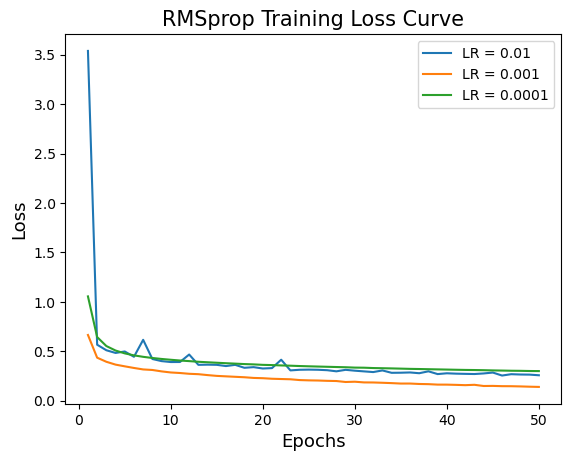

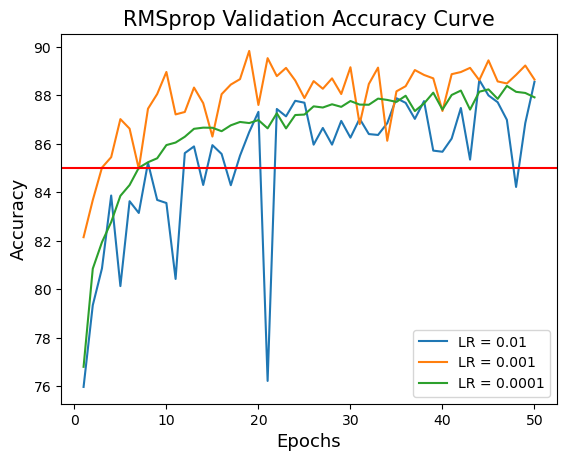

In [8]:
fig5, ax5 = plt.subplots()
fig6, ax6 = plt.subplots()

epoch_num = 50

for lr in [0.01, 0.001, 0.0001]:

    model3, train_loss_rms, val_accuracy_list_rms = training(hidden_layers = lay3, learning_rate = lr, epochs = epoch_num, optim = 'RMSprop')

    ax5.plot(range(1, epoch_num + 1), train_loss_rms, label='Training Loss')
    ax6.plot(range(1, epoch_num + 1), val_accuracy_list_rms, label='Validation Accuracy')

    # Telling PyTorch we aren't passing inputs to network for training purpose
    with torch.no_grad():
        
        RMS_test_acc_sum = 0
        RMS_test_acc_list = []

        for test_features, test_labels in test_batches:

            model3.eval()
            
            # reshape test images into vector
            test_features = test_features.reshape(-1, 28*28)

            # compute validation outputs 
            test_output = model3(test_features)
            _, test_predicted = torch.max(test_output, 1)

            #  compute accuracy 
            RMS_test_acc = accuracy_score(test_labels, test_predicted)
            RMS_test_acc_sum += RMS_test_acc
            RMS_test_acc_list.append(RMS_test_acc)
                    
        #  mean accuracy, standard deviation of batch accuracies
        print("RMSprop Test Accuracy: " + str(RMS_test_acc_sum/num_test_batches*100) + '%', "; Std of batch accuracies: "+ str(np.std(RMS_test_acc_list)))

ax5.set_xlabel('Epochs',fontsize=13)
ax5.set_ylabel('Loss',fontsize=13)
ax5.set_title('RMSprop Training Loss Curve',fontsize=15)
ax5.legend(["LR = 0.01", "LR = 0.001", "LR = 0.0001"])

    
ax6.set_xlabel('Epochs',fontsize=13)
ax6.set_ylabel('Accuracy',fontsize=13)
ax6.set_title('RMSprop Validation Accuracy Curve',fontsize=15)
ax6.axhline(y=85, color='r')
ax6.legend(["LR = 0.01", "LR = 0.001", "LR = 0.0001"])

plt.show()

The best performing learning rate for RMSprop with 50 epochs is 0.001

### Best LRs from each optimizer

In [13]:
SGD_lr = 0.1
Adam_lr = 0.001
RMS_lr = 0.001

In [18]:
# take the best learning rate for each optimizer 
model_SGD, train_loss_sgd_best, val_accuracy_list_sgd_best = training(hidden_layers = lay3, learning_rate = SGD_lr, epochs = epoch_num, optim = 'SGD')

#SGD test accuracy
with torch.no_grad():
        
        SGD_test_acc_sum_best = 0
        SGD_test_acc_list_best = []

        for test_features, test_labels in test_batches:

            model_SGD.eval()
            
            # reshape test images into vector
            test_features = test_features.reshape(-1, 28*28)

            # compute validation outputs 
            test_output = model_SGD(test_features)
            _, test_predicted = torch.max(test_output, 1)

            #  compute accuracy 
            SGD_test_acc_best = accuracy_score(test_labels, test_predicted)
            SGD_test_acc_sum_best += SGD_test_acc_best
            SGD_test_acc_list_best.append(SGD_test_acc_best)
                    
        #  mean accuracy, standard deviation of batch accuracies
        print("SGD Test Accuracy w/ best LR: " + str(SGD_test_acc_sum_best/num_test_batches*100) + '%', "; Std of batch accuracies: "+ str(np.std(SGD_test_acc_list_best)))

model_Adam, train_loss_adam_best, val_accuracy_list_adam_best = training(hidden_layers = lay3, learning_rate = Adam_lr, epochs = epoch_num, optim = 'Adam')

#Adam test accuracy
with torch.no_grad():
        
        Adam_test_acc_sum_best = 0
        Adam_test_acc_list_best = []

        for test_features, test_labels in test_batches:

            model_Adam.eval()
            
            # reshape test images into vector
            test_features = test_features.reshape(-1, 28*28)

            # compute validation outputs 
            test_output = model_Adam(test_features)
            _, test_predicted = torch.max(test_output, 1)

            #  compute accuracy 
            Adam_test_acc_best = accuracy_score(test_labels, test_predicted)
            Adam_test_acc_sum_best += Adam_test_acc_best
            Adam_test_acc_list_best.append(Adam_test_acc_best)
                    
        #  mean accuracy, standard deviation of batch accuracies
        print("Adam Test Accuracy w/ best LR: " + str(Adam_test_acc_sum_best/num_test_batches*100) + '%', "; Std of batch accuracies: "+ str(np.std(Adam_test_acc_list_best)))

model_RMS, train_loss_rms_best, val_accuracy_list_rms_best = training(hidden_layers = lay3, learning_rate = RMS_lr, epochs = epoch_num, optim = 'RMSprop')

#RMS test accuracy
with torch.no_grad():
        
        RMS_test_acc_sum_best = 0
        RMS_test_acc_list_best = []

        for test_features, test_labels in test_batches:

            model_RMS.eval()
            
            # reshape test images into vector
            test_features = test_features.reshape(-1, 28*28)

            # compute validation outputs 
            test_output = model_RMS(test_features)
            _, test_predicted = torch.max(test_output, 1)

            #  compute accuracy 
            RMS_test_acc_best = accuracy_score(test_labels, test_predicted)
            RMS_test_acc_sum_best += RMS_test_acc_best
            RMS_test_acc_list_best.append(RMS_test_acc_best)
                    
        #  mean accuracy, standard deviation of batch accuracies
        print("RMS Test Accuracy w/ best LR: " + str(RMS_test_acc_sum_best/num_test_batches*100) + '%', "; Std of batch accuracies: "+ str(np.std(RMS_test_acc_list_best)))


  2%|▏         | 1/50 [00:10<08:24, 10.30s/it]

Epoch: 0; Validation Accuracy:75.84564651268116%


  4%|▍         | 2/50 [00:20<08:05, 10.11s/it]

Epoch: 1; Validation Accuracy:79.46812726449276%


  6%|▌         | 3/50 [00:30<07:52, 10.05s/it]

Epoch: 2; Validation Accuracy:82.71130548007247%


  8%|▊         | 4/50 [00:40<07:51, 10.24s/it]

Epoch: 3; Validation Accuracy:83.94969995471014%


 10%|█         | 5/50 [00:52<07:58, 10.64s/it]

Epoch: 4; Validation Accuracy:82.44522758152173%


 12%|█▏        | 6/50 [01:03<07:54, 10.79s/it]

Epoch: 5; Validation Accuracy:86.3083106884058%


 14%|█▍        | 7/50 [01:14<07:53, 11.01s/it]

Epoch: 6; Validation Accuracy:85.40251358695653%


 16%|█▌        | 8/50 [01:24<07:32, 10.78s/it]

Epoch: 7; Validation Accuracy:86.37766077898551%


 18%|█▊        | 9/50 [01:35<07:24, 10.84s/it]

Epoch: 8; Validation Accuracy:86.97987432065219%


 20%|██        | 10/50 [01:46<07:15, 10.89s/it]

Epoch: 9; Validation Accuracy:86.7102581521739%


 22%|██▏       | 11/50 [01:57<06:59, 10.76s/it]

Epoch: 10; Validation Accuracy:87.74060235507247%


 24%|██▍       | 12/50 [02:06<06:34, 10.39s/it]

Epoch: 11; Validation Accuracy:86.85532721920289%


 26%|██▌       | 13/50 [02:16<06:15, 10.16s/it]

Epoch: 12; Validation Accuracy:87.74060235507247%


 28%|██▊       | 14/50 [02:26<06:05, 10.17s/it]

Epoch: 13; Validation Accuracy:87.98191236413044%


 30%|███       | 15/50 [02:38<06:07, 10.50s/it]

Epoch: 14; Validation Accuracy:87.33440896739131%


 32%|███▏      | 16/50 [02:48<05:56, 10.49s/it]

Epoch: 15; Validation Accuracy:87.2360450634058%


 34%|███▍      | 17/50 [02:58<05:42, 10.38s/it]

Epoch: 16; Validation Accuracy:87.17377151268116%


 36%|███▌      | 18/50 [03:08<05:27, 10.23s/it]

Epoch: 17; Validation Accuracy:87.38465240036231%


 38%|███▊      | 19/50 [03:18<05:12, 10.07s/it]

Epoch: 18; Validation Accuracy:87.76253962862319%


 40%|████      | 20/50 [03:27<04:52,  9.76s/it]

Epoch: 19; Validation Accuracy:88.04772418478262%


 42%|████▏     | 21/50 [03:36<04:41,  9.70s/it]

Epoch: 20; Validation Accuracy:88.52468297101449%


 44%|████▍     | 22/50 [03:46<04:27,  9.56s/it]

Epoch: 21; Validation Accuracy:88.13405797101449%


 46%|████▌     | 23/50 [03:55<04:13,  9.38s/it]

Epoch: 22; Validation Accuracy:88.02649456521738%


 48%|████▊     | 24/50 [04:04<04:02,  9.31s/it]

Epoch: 23; Validation Accuracy:88.88063292572464%


 50%|█████     | 25/50 [04:13<03:50,  9.22s/it]

Epoch: 24; Validation Accuracy:88.66550611413044%


 52%|█████▏    | 26/50 [04:22<03:39,  9.14s/it]

Epoch: 25; Validation Accuracy:89.15520267210145%


 54%|█████▍    | 27/50 [04:31<03:29,  9.12s/it]

Epoch: 26; Validation Accuracy:88.81552875905797%


 56%|█████▌    | 28/50 [04:40<03:21,  9.16s/it]

Epoch: 27; Validation Accuracy:83.20949388586956%


 58%|█████▊    | 29/50 [04:49<03:12,  9.18s/it]

Epoch: 28; Validation Accuracy:86.63100090579711%


 60%|██████    | 30/50 [04:58<03:02,  9.13s/it]

Epoch: 29; Validation Accuracy:86.78456182065219%


 62%|██████▏   | 31/50 [05:07<02:52,  9.09s/it]

Epoch: 30; Validation Accuracy:88.04277060688405%


 64%|██████▍   | 32/50 [05:16<02:42,  9.05s/it]

Epoch: 31; Validation Accuracy:89.09009850543478%


 66%|██████▌   | 33/50 [05:25<02:34,  9.08s/it]

Epoch: 32; Validation Accuracy:89.44534080615942%


 68%|██████▊   | 34/50 [05:35<02:26,  9.16s/it]

Epoch: 33; Validation Accuracy:88.20128509963769%


 70%|███████   | 35/50 [05:44<02:16,  9.13s/it]

Epoch: 34; Validation Accuracy:88.88346354166666%


 72%|███████▏  | 36/50 [05:53<02:07,  9.10s/it]

Epoch: 35; Validation Accuracy:88.58200294384058%


 74%|███████▍  | 37/50 [06:02<01:57,  9.06s/it]

Epoch: 36; Validation Accuracy:89.02287137681158%


 76%|███████▌  | 38/50 [06:11<01:48,  9.04s/it]

Epoch: 37; Validation Accuracy:89.31442481884058%


 78%|███████▊  | 39/50 [06:20<01:39,  9.01s/it]

Epoch: 38; Validation Accuracy:88.59827898550724%


 80%|████████  | 40/50 [06:29<01:30,  9.02s/it]

Epoch: 39; Validation Accuracy:88.74830163043478%


 82%|████████▏ | 41/50 [06:38<01:21,  9.04s/it]

Epoch: 40; Validation Accuracy:89.21110733695653%


 84%|████████▍ | 42/50 [06:47<01:12,  9.01s/it]

Epoch: 41; Validation Accuracy:87.91326992753623%


 86%|████████▌ | 43/50 [06:56<01:02,  8.99s/it]

Epoch: 42; Validation Accuracy:87.73635643115942%


 88%|████████▊ | 44/50 [07:05<00:53,  8.96s/it]

Epoch: 43; Validation Accuracy:88.53812839673913%


 90%|█████████ | 45/50 [07:13<00:44,  8.95s/it]

Epoch: 44; Validation Accuracy:88.56997282608697%


 92%|█████████▏| 46/50 [07:22<00:35,  8.94s/it]

Epoch: 45; Validation Accuracy:86.82702105978262%


 94%|█████████▍| 47/50 [07:31<00:26,  8.95s/it]

Epoch: 46; Validation Accuracy:88.30672554347827%


 96%|█████████▌| 48/50 [07:40<00:17,  8.99s/it]

Epoch: 47; Validation Accuracy:88.63366168478262%


 98%|█████████▊| 49/50 [07:49<00:08,  8.97s/it]

Epoch: 48; Validation Accuracy:86.17244112318842%


100%|██████████| 50/50 [07:58<00:00,  9.58s/it]

Epoch: 49; Validation Accuracy:88.48222373188405%


SGD Test Accuracy w/ best LR: 87.91015625% ; Std of batch accuracies: 0.0197246286180778


  2%|▏         | 1/50 [00:08<07:20,  8.98s/it]

Epoch: 0; Validation Accuracy:84.16765738224638%


  4%|▍         | 2/50 [00:17<07:09,  8.95s/it]

Epoch: 1; Validation Accuracy:85.8603657155797%


  6%|▌         | 3/50 [00:26<07:03,  9.01s/it]

Epoch: 2; Validation Accuracy:86.95722939311595%


  8%|▊         | 4/50 [00:35<06:52,  8.98s/it]

Epoch: 3; Validation Accuracy:86.62675498188405%


 10%|█         | 5/50 [00:45<06:46,  9.03s/it]

Epoch: 4; Validation Accuracy:86.33944746376811%


 12%|█▏        | 6/50 [00:54<06:36,  9.02s/it]

Epoch: 5; Validation Accuracy:88.36050724637681%


 14%|█▍        | 7/50 [01:03<06:27,  9.00s/it]

Epoch: 6; Validation Accuracy:87.88425611413044%


 16%|█▌        | 8/50 [01:12<06:19,  9.04s/it]

Epoch: 7; Validation Accuracy:88.02366394927536%


 18%|█▊        | 9/50 [01:21<06:10,  9.03s/it]

Epoch: 8; Validation Accuracy:88.25506680253623%


 20%|██        | 10/50 [01:30<05:59,  9.00s/it]

Epoch: 9; Validation Accuracy:88.66550611413044%


 22%|██▏       | 11/50 [01:39<06:01,  9.26s/it]

Epoch: 10; Validation Accuracy:89.06391530797102%


 24%|██▍       | 12/50 [01:49<06:00,  9.48s/it]

Epoch: 11; Validation Accuracy:88.93370697463769%


 26%|██▌       | 13/50 [01:59<05:47,  9.38s/it]

Epoch: 12; Validation Accuracy:88.99031929347827%


 28%|██▊       | 14/50 [02:08<05:33,  9.26s/it]

Epoch: 13; Validation Accuracy:88.02083333333334%


 30%|███       | 15/50 [02:17<05:21,  9.18s/it]

Epoch: 14; Validation Accuracy:88.90893908514492%


 32%|███▏      | 16/50 [02:26<05:10,  9.13s/it]

Epoch: 15; Validation Accuracy:89.18209352355072%


 34%|███▍      | 17/50 [02:35<05:01,  9.13s/it]

Epoch: 16; Validation Accuracy:88.30318727355072%


 36%|███▌      | 18/50 [02:44<04:51,  9.12s/it]

Epoch: 17; Validation Accuracy:89.13609601449276%


 38%|███▊      | 19/50 [02:53<04:42,  9.12s/it]

Epoch: 18; Validation Accuracy:89.2663043478261%


 40%|████      | 20/50 [03:02<04:33,  9.10s/it]

Epoch: 19; Validation Accuracy:89.23375226449276%


 42%|████▏     | 21/50 [03:11<04:22,  9.06s/it]

Epoch: 20; Validation Accuracy:89.42623414855072%


 44%|████▍     | 22/50 [03:20<04:13,  9.04s/it]

Epoch: 21; Validation Accuracy:88.58058763586956%


 46%|████▌     | 23/50 [03:29<04:03,  9.01s/it]

Epoch: 22; Validation Accuracy:89.20261548913044%


 48%|████▊     | 24/50 [03:38<03:54,  9.00s/it]

Epoch: 23; Validation Accuracy:89.22101449275362%


 50%|█████     | 25/50 [03:47<03:45,  9.01s/it]

Epoch: 24; Validation Accuracy:88.86931046195653%


 52%|█████▏    | 26/50 [03:56<03:36,  9.04s/it]

Epoch: 25; Validation Accuracy:88.91743093297102%


 54%|█████▍    | 27/50 [04:05<03:27,  9.02s/it]

Epoch: 26; Validation Accuracy:89.50761435688405%


 56%|█████▌    | 28/50 [04:14<03:18,  9.03s/it]

Epoch: 27; Validation Accuracy:89.2493206521739%


 58%|█████▊    | 29/50 [04:23<03:09,  9.01s/it]

Epoch: 28; Validation Accuracy:88.94078351449276%


 60%|██████    | 30/50 [04:34<03:12,  9.61s/it]

Epoch: 29; Validation Accuracy:89.30876358695653%


 62%|██████▏   | 31/50 [04:45<03:09,  9.95s/it]

Epoch: 30; Validation Accuracy:89.16581748188405%


 64%|██████▍   | 32/50 [04:55<03:00, 10.03s/it]

Epoch: 31; Validation Accuracy:89.03277853260869%


 66%|██████▌   | 33/50 [05:04<02:48,  9.89s/it]

Epoch: 32; Validation Accuracy:89.3349467844203%


 68%|██████▊   | 34/50 [05:14<02:38,  9.90s/it]

Epoch: 33; Validation Accuracy:88.70442708333334%


 70%|███████   | 35/50 [05:25<02:31, 10.08s/it]

Epoch: 34; Validation Accuracy:89.2868263134058%


 72%|███████▏  | 36/50 [05:35<02:20, 10.06s/it]

Epoch: 35; Validation Accuracy:89.1396342844203%


 74%|███████▍  | 37/50 [05:45<02:09,  9.99s/it]

Epoch: 36; Validation Accuracy:88.97545855978262%


 76%|███████▌  | 38/50 [05:54<01:58,  9.85s/it]

Epoch: 37; Validation Accuracy:88.71716485507247%


 78%|███████▊  | 39/50 [06:03<01:46,  9.66s/it]

Epoch: 38; Validation Accuracy:88.94856770833334%


 80%|████████  | 40/50 [06:14<01:37,  9.79s/it]

Epoch: 39; Validation Accuracy:88.85657269021738%


 82%|████████▏ | 41/50 [06:24<01:30, 10.01s/it]

Epoch: 40; Validation Accuracy:88.88417119565219%


 84%|████████▍ | 42/50 [06:34<01:19,  9.91s/it]

Epoch: 41; Validation Accuracy:88.44684103260869%


 86%|████████▌ | 43/50 [06:44<01:09,  9.89s/it]

Epoch: 42; Validation Accuracy:89.11345108695653%


 88%|████████▊ | 44/50 [06:53<00:59,  9.87s/it]

Epoch: 43; Validation Accuracy:89.42694180253623%


 90%|█████████ | 45/50 [07:03<00:48,  9.76s/it]

Epoch: 44; Validation Accuracy:89.29956408514492%


 92%|█████████▏| 46/50 [07:13<00:38,  9.72s/it]

Epoch: 45; Validation Accuracy:89.19553894927536%


 94%|█████████▍| 47/50 [07:22<00:28,  9.59s/it]

Epoch: 46; Validation Accuracy:89.25993546195653%


 96%|█████████▌| 48/50 [07:31<00:18,  9.48s/it]

Epoch: 47; Validation Accuracy:88.78297667572464%


 98%|█████████▊| 49/50 [07:40<00:09,  9.41s/it]

Epoch: 48; Validation Accuracy:89.01154891304347%


100%|██████████| 50/50 [07:50<00:00,  9.40s/it]

Epoch: 49; Validation Accuracy:88.73061028079711%


Adam Test Accuracy w/ best LR: 87.744140625% ; Std of batch accuracies: 0.026661229374006716


  2%|▏         | 1/50 [00:09<07:29,  9.18s/it]

Epoch: 0; Validation Accuracy:83.42532835144928%


  4%|▍         | 2/50 [00:18<07:22,  9.21s/it]

Epoch: 1; Validation Accuracy:85.62613224637681%


  6%|▌         | 3/50 [00:30<08:08, 10.39s/it]

Epoch: 2; Validation Accuracy:85.96509850543478%


  8%|▊         | 4/50 [00:40<07:58, 10.39s/it]

Epoch: 3; Validation Accuracy:83.96243772644928%


 10%|█         | 5/50 [00:51<07:50, 10.46s/it]

Epoch: 4; Validation Accuracy:86.26726675724638%


 12%|█▏        | 6/50 [01:01<07:43, 10.53s/it]

Epoch: 5; Validation Accuracy:86.78102355072464%


 14%|█▍        | 7/50 [01:12<07:38, 10.66s/it]

Epoch: 6; Validation Accuracy:87.66559103260869%


 16%|█▌        | 8/50 [01:23<07:31, 10.75s/it]

Epoch: 7; Validation Accuracy:83.64045516304347%


 18%|█▊        | 9/50 [01:34<07:17, 10.66s/it]

Epoch: 8; Validation Accuracy:88.06824615036231%


 20%|██        | 10/50 [01:46<07:20, 11.02s/it]

Epoch: 9; Validation Accuracy:84.58658854166666%


 22%|██▏       | 11/50 [01:56<07:01, 10.81s/it]

Epoch: 10; Validation Accuracy:87.23392210144928%


 24%|██▍       | 12/50 [02:06<06:41, 10.57s/it]

Epoch: 11; Validation Accuracy:87.74626358695653%


 26%|██▌       | 13/50 [02:16<06:21, 10.31s/it]

Epoch: 12; Validation Accuracy:87.74555593297102%


 28%|██▊       | 14/50 [02:25<06:01, 10.03s/it]

Epoch: 13; Validation Accuracy:86.6614300271739%


 30%|███       | 15/50 [02:36<06:00, 10.30s/it]

Epoch: 14; Validation Accuracy:89.01225656702898%


 32%|███▏      | 16/50 [02:45<05:41, 10.05s/it]

Epoch: 15; Validation Accuracy:88.69876585144928%


 34%|███▍      | 17/50 [02:57<05:42, 10.39s/it]

Epoch: 16; Validation Accuracy:88.87072576992753%


 36%|███▌      | 18/50 [03:06<05:27, 10.24s/it]

Epoch: 17; Validation Accuracy:89.09788269927536%


 38%|███▊      | 19/50 [03:16<05:08,  9.94s/it]

Epoch: 18; Validation Accuracy:88.93016870471014%


 40%|████      | 20/50 [03:25<04:50,  9.69s/it]

Epoch: 19; Validation Accuracy:87.53325973731884%


 42%|████▏     | 21/50 [03:34<04:40,  9.67s/it]

Epoch: 20; Validation Accuracy:87.93803781702898%


 44%|████▍     | 22/50 [03:44<04:29,  9.62s/it]

Epoch: 21; Validation Accuracy:88.19703917572464%


 46%|████▌     | 23/50 [03:54<04:20,  9.63s/it]

Epoch: 22; Validation Accuracy:89.48496942934781%


 48%|████▊     | 24/50 [04:03<04:11,  9.66s/it]

Epoch: 23; Validation Accuracy:87.09451426630434%


 50%|█████     | 25/50 [04:12<03:57,  9.49s/it]

Epoch: 24; Validation Accuracy:88.40650475543478%


 52%|█████▏    | 26/50 [04:23<03:54,  9.75s/it]

Epoch: 25; Validation Accuracy:88.24657495471014%


 54%|█████▍    | 27/50 [04:34<03:51, 10.06s/it]

Epoch: 26; Validation Accuracy:89.35476109601449%


 56%|█████▌    | 28/50 [04:43<03:38,  9.93s/it]

Epoch: 27; Validation Accuracy:87.45612545289855%


 58%|█████▊    | 29/50 [04:53<03:29,  9.97s/it]

Epoch: 28; Validation Accuracy:88.18925498188405%


 60%|██████    | 30/50 [05:02<03:14,  9.73s/it]

Epoch: 29; Validation Accuracy:89.09717504528986%


 62%|██████▏   | 31/50 [05:12<03:02,  9.61s/it]

Epoch: 30; Validation Accuracy:89.05966938405797%


 64%|██████▍   | 32/50 [05:21<02:49,  9.43s/it]

Epoch: 31; Validation Accuracy:88.53459012681158%


 66%|██████▌   | 33/50 [05:30<02:37,  9.29s/it]

Epoch: 32; Validation Accuracy:89.12406589673913%


 68%|██████▊   | 34/50 [05:39<02:27,  9.22s/it]

Epoch: 33; Validation Accuracy:89.05188519021738%


 70%|███████   | 35/50 [05:48<02:17,  9.17s/it]

Epoch: 34; Validation Accuracy:87.50566123188405%


 72%|███████▏  | 36/50 [05:57<02:08,  9.15s/it]

Epoch: 35; Validation Accuracy:89.51681385869566%


 74%|███████▍  | 37/50 [06:06<01:59,  9.16s/it]

Epoch: 36; Validation Accuracy:88.40225883152173%


 76%|███████▌  | 38/50 [06:15<01:49,  9.13s/it]

Epoch: 37; Validation Accuracy:88.92167685688405%


 78%|███████▊  | 39/50 [06:24<01:39,  9.08s/it]

Epoch: 38; Validation Accuracy:88.96908967391303%


 80%|████████  | 40/50 [06:33<01:30,  9.10s/it]

Epoch: 39; Validation Accuracy:87.69602015398551%


 82%|████████▏ | 41/50 [06:42<01:21,  9.10s/it]

Epoch: 40; Validation Accuracy:89.31017889492753%


 84%|████████▍ | 42/50 [06:51<01:12,  9.09s/it]

Epoch: 41; Validation Accuracy:88.96484375%


 86%|████████▌ | 43/50 [07:01<01:03,  9.09s/it]

Epoch: 42; Validation Accuracy:88.86931046195653%


 88%|████████▊ | 44/50 [07:10<00:54,  9.09s/it]

Epoch: 43; Validation Accuracy:89.34131567028986%


 90%|█████████ | 45/50 [07:19<00:45,  9.06s/it]

Epoch: 44; Validation Accuracy:88.41358129528986%


 92%|█████████▏| 46/50 [07:28<00:37,  9.28s/it]

Epoch: 45; Validation Accuracy:89.39085144927536%


 94%|█████████▍| 47/50 [07:41<00:30, 10.17s/it]

Epoch: 46; Validation Accuracy:89.32928555253623%


 96%|█████████▌| 48/50 [07:50<00:20, 10.00s/it]

Epoch: 47; Validation Accuracy:88.54025135869566%


 98%|█████████▊| 49/50 [08:00<00:09,  9.99s/it]

Epoch: 48; Validation Accuracy:89.48496942934781%


100%|██████████| 50/50 [08:10<00:00,  9.81s/it]

Epoch: 49; Validation Accuracy:88.41358129528986%


RMS Test Accuracy w/ best LR: 87.216796875% ; Std of batch accuracies: 0.023631803632908257


In [65]:
print(np.std(val_accuracy_list_sgd_best))
print(np.std(val_accuracy_list_rms_best))
print(np.std(RMS_test_acc_list_best))

print(len(RMS_test_acc_list_best))

2.5383778152107523
1.523245959606374
0.023631803632908257
40


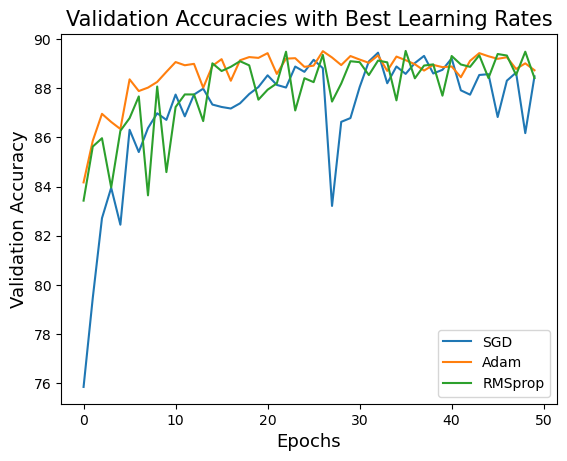

In [19]:
plt.plot(val_accuracy_list_sgd_best, label='SGD')
plt.plot(val_accuracy_list_adam_best, label='Adam')
plt.plot(val_accuracy_list_rms_best, label='RMSprop')

plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Validation Accuracy', fontsize=13)
plt.title('Validation Accuracies with Best Learning Rates', fontsize=15)

plt.legend()
plt.show()

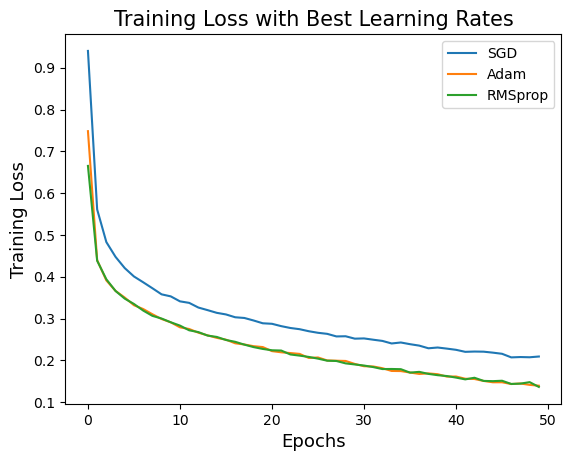

In [23]:
plt.plot(train_loss_sgd_best, label='SGD')
plt.plot(train_loss_adam_best, label='Adam')
plt.plot(train_loss_rms_best, label='RMSprop')

plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Training Loss', fontsize=13)
plt.title('Training Loss with Best Learning Rates', fontsize=15)

plt.legend()
plt.show()

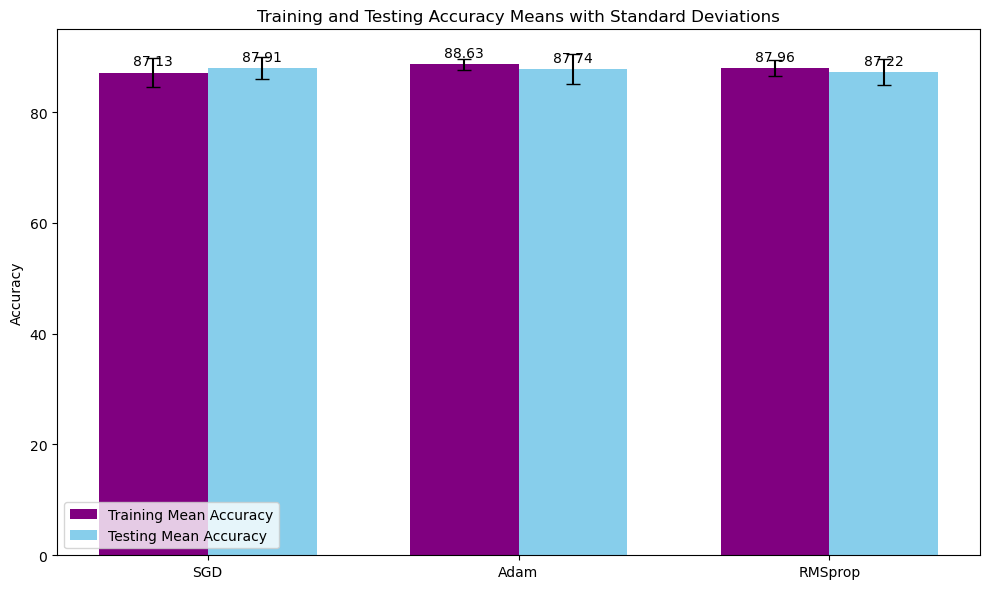

In [48]:

train_acc_means = [np.mean(val_accuracy_list_sgd_best), np.mean(val_accuracy_list_adam_best), np.mean(val_accuracy_list_rms_best)]  # Means for three different training optimzers
train_acc_std = [np.std(val_accuracy_list_sgd_best), np.std(val_accuracy_list_adam_best), np.std(val_accuracy_list_rms_best)]  # Standard deviations for test

test_acc_means = [SGD_test_acc_sum_best/num_test_batches*100, Adam_test_acc_sum_best/num_test_batches*100, RMS_test_acc_sum_best/num_test_batches*100]  
test_acc_std = [100*np.std(SGD_test_acc_list_best), 100*np.std(Adam_test_acc_list_best), 100*np.std(RMS_test_acc_list_best)]  

# Labels for the conditions (e.g., different models or methods)
labels = ['SGD', 'Adam', 'RMSprop']

# Positions for the bars on the x-axis
x = np.arange(len(labels))  
width = 0.35  # Width of the bars

# Create the bar chart with error bars for standard deviation
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars for Training and Testing means
rects1 = ax.bar(x - width / 2, train_acc_means, width, label='Training Mean Accuracy',
                yerr=train_acc_std, capsize=5, color='purple', ecolor='black')
rects2 = ax.bar(x + width / 2, test_acc_means, width, label='Testing Mean Accuracy',
                yerr=test_acc_std, capsize=5, color='skyblue', ecolor='black')

# Add labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Training and Testing Accuracy Means with Standard Deviations')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to the bars
add_labels(rects1)
add_labels(rects2)

# Show the plot
plt.tight_layout()
plt.show()


In [110]:
print(train_acc_means, train_acc_std, test_acc_means, test_acc_std)

[87.13206238677536, 88.63434103260869, 87.9564651268116] [2.5383778152107523, 1.0047209677581366, 1.523245959606374] [87.91015625, 87.744140625, 87.216796875] [1.9724628618077797, 2.6661229374006714, 2.3631803632908257]


### Redefine model for hyperparameter tuning

Dropout, initialization, batchnorm

In [82]:
#Define your (As Cool As It Gets) Fully Connected Neural Network 
class ACAIGFCN(nn.Module):
    #Initialize model layers, add additional arguments to adjust
    def __init__(self, input_dim, hidden_layers, output_dim, optim, dropout_prob, initial, batchnorm): 
        super(ACAIGFCN, self).__init__()
        #Define the network layer(s) and activation function(s)
        layers = []
        prev_dim = input_dim

        # Add hidden layers
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_size))
            # apply batch norm
            if batchnorm=='yes':
                layers.append(nn.BatchNorm1d(hidden_size))  
            layers.append(nn.ReLU())
            prev_dim = hidden_size 

        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))

        self.model = nn.Sequential(*layers)

        if initial == 'RN' or initial == 'XN' or initial == 'KU':
            # apply initiation
            self.init_weights(initial)

 
    def forward(self, input):
        #Define how your model propagates the input through the network
        return self.model(input)
    
    def init_weights(self, initial):
        for layer in self.model:
            # Only initialize Linear layers
            if isinstance(layer, nn.Linear):
                if initial =='RN':  
                    # Normal distribution
                    init.normal_(layer.weight, mean=0.0, std=0.01)
                elif initial =='XN':
                    # Normal distribution
                    init.xavier_normal_(layer.weight) 
                elif initial =='KU':
                    # Normal distribution
                    init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                # Initialize bias to zero
                init.zeros_(layer.bias)

### Dropout regularization

In [83]:

def training(hidden_layers, learning_rate, epochs, optim, dropout_prob, initial, batchnorm):
    # Initialize neural network model with input, output and hidden layer dimensions
    model = ACAIGFCN(input_dim = 784, hidden_layers = hidden_layers, output_dim = 10, optim=optim, dropout_prob=dropout_prob, initial=initial, batchnorm=batchnorm) #... add more parameters

    train_loss_list = np.zeros((epochs,))
    validation_accuracy_list = np.zeros((epochs,))

    final_val_acc_list = []

    # Define loss function  and optimizer
    loss_func = nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 
    
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)# Use optimizers from torch.optim

    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    else: #RMSprop
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    


    # Iterate over epochs, batches with progress bar and train+ validate the ACAIGFCN
    # Track the loss and validation accuracy
    for epoch in tqdm.trange(epochs):

        running_loss = 0.0

        # ACAIGFCN Training 
        for train_features, train_labels in train_batches:
            # Set model into training mode
            model.train()
            
            # Reshape images into a vector
            train_features = train_features.reshape(-1, 28*28)

            # Reset gradients, Calculate training loss on model 
            optimizer.zero_grad()
            output = model(train_features)
            loss = loss_func(output, train_labels) #Loss/error

            # Perfrom optimization, back propagation
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
    
        # Record loss for the epoch
        train_loss_list[epoch] = running_loss / len(train_batches)
        
        val_acc_sum = 0
        
        # ACAIGFCN Validation
        for val_features, val_labels in val_batches:
            
            # Telling PyTorch we aren't passing inputs to network for training purpose
            with torch.no_grad(): 
                model.eval()
                
                # Reshape validation images into a vector
                val_features = val_features.reshape(-1, 28*28)
            
                # Compute validation outputs (targets) 
                output = model(val_features)
                _, predicted = torch.max(output, 1)

                # and compute accuracy 
                val_acc = accuracy_score(val_labels, predicted)
                val_acc_sum += val_acc
        validation_accuracy_list[epoch] = val_acc_sum

        validation_accuracies = val_acc_sum/num_val_batches*100
        final_val_acc_list.append(validation_accuracies)

        # Record accuracy for the epoch; print training loss, validation accuracy
        print("Epoch: "+ str(epoch) +"; Validation Accuracy:" + str(validation_accuracies) + '%')

    return model, train_loss_list, final_val_acc_list

In [84]:


#Calculate accuracy on test set
def test_accuracy(model, test_batch_size):
    test_batches = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
    num_test_batches = len(test_batches)

    # Telling PyTorch we aren't passing inputs to network for training purpose
    with torch.no_grad():
        
        test_acc_sum = 0
        test_acc_list = []

        for test_features, test_labels in test_batches:

            model.eval()
            
            # Reshape test images into a vector
            test_features = test_features.reshape(-1, 28*28)

            # Compute validation outputs (targets) 
            test_output = model(test_features)
            _, test_predicted = torch.max(test_output, 1)

            # and compute accuracy 
            test_acc = accuracy_score(test_labels, test_predicted)
            test_acc_sum += test_acc
            test_acc_list.append(test_acc)

                    # Compute total (mean) accuracy
        test_acc_mean = (test_acc_sum / num_test_batches) * 100
        test_acc_std = np.std(test_acc_list)
                    
        # Record mean accuracy, standard deviation of batch accuracies
        print("Test Accuracy: " + str(test_acc_sum/num_test_batches*100) + '%', "; Std of batch accuracies: "+ str(np.std(test_acc_list)))

    return test_acc_mean, test_acc_std

In [70]:
#only do dropout on my best optimizer 

epochs_vec = range(1,epoch_num+1)

# drop_prob = [0.1, 0.2, 0.3]
drop_prob = [0.2, 0.4, 0.6]
Adam_test_acc_mean_drop_list = np.array([])
Adam_test_acc_std_drop_list = np.array([])

Adam_train_acc_mean_drop_list = np.array([])
Adam_train_acc_std_drop_list = np.array([])

for prob in drop_prob:
    # train model and find accuracy mean and std
    model_Adam_drop, Adam_train_loss_list_drop, Adam_val_acc_list_drop = training(hidden_layers=lay3, learning_rate=Adam_lr, epochs=epoch_num, optim='Adam', dropout_prob=prob, initial='no', batchnorm='no')
    Adam_acc_mean_drop, Adam_acc_std_drop = test_accuracy(model_Adam_drop, test_batch_size=test_batch_size)

    Adam_test_acc_mean_drop_list = np.append(Adam_test_acc_mean_drop_list, Adam_acc_mean_drop)
    Adam_test_acc_std_drop_list = np.append(Adam_test_acc_std_drop_list, Adam_acc_std_drop)

    Adam_train_acc_mean_drop_list = np.append(Adam_train_acc_mean_drop_list, np.mean(Adam_val_acc_list_drop))
    Adam_train_acc_std_drop_list = np.append(Adam_train_acc_std_drop_list, np.std(Adam_val_acc_list_drop))


  2%|▏         | 1/50 [00:12<09:54, 12.13s/it]

Epoch: 0; Validation Accuracy:83.84992074275362%


  4%|▍         | 2/50 [00:22<08:57, 11.19s/it]

Epoch: 1; Validation Accuracy:86.2021625905797%


  6%|▌         | 3/50 [00:33<08:35, 10.97s/it]

Epoch: 2; Validation Accuracy:86.65859941123189%


  8%|▊         | 4/50 [00:43<08:06, 10.58s/it]

Epoch: 3; Validation Accuracy:87.5290138134058%


 10%|█         | 5/50 [00:53<07:42, 10.29s/it]

Epoch: 4; Validation Accuracy:87.52618319746377%


 12%|█▏        | 6/50 [01:03<07:35, 10.36s/it]

Epoch: 5; Validation Accuracy:87.1872169384058%


 14%|█▍        | 7/50 [01:15<07:40, 10.70s/it]

Epoch: 6; Validation Accuracy:88.04277060688405%


 16%|█▌        | 8/50 [01:27<07:54, 11.30s/it]

Epoch: 7; Validation Accuracy:88.4560405344203%


 18%|█▊        | 9/50 [01:38<07:34, 11.08s/it]

Epoch: 8; Validation Accuracy:87.98191236413044%


 20%|██        | 10/50 [01:47<07:06, 10.66s/it]

Epoch: 9; Validation Accuracy:88.47797780797102%


 22%|██▏       | 11/50 [01:57<06:40, 10.26s/it]

Epoch: 10; Validation Accuracy:88.81057518115942%


 24%|██▍       | 12/50 [02:06<06:21, 10.04s/it]

Epoch: 11; Validation Accuracy:89.07453011775362%


 26%|██▌       | 13/50 [02:17<06:18, 10.22s/it]

Epoch: 12; Validation Accuracy:88.48363903985508%


 28%|██▊       | 14/50 [02:27<06:08, 10.23s/it]

Epoch: 13; Validation Accuracy:88.96838201992753%


 30%|███       | 15/50 [02:37<05:56, 10.18s/it]

Epoch: 14; Validation Accuracy:88.76387001811595%


 32%|███▏      | 16/50 [02:48<05:54, 10.42s/it]

Epoch: 15; Validation Accuracy:89.12972712862319%


 34%|███▍      | 17/50 [03:00<06:00, 10.93s/it]

Epoch: 16; Validation Accuracy:88.71999547101449%


 36%|███▌      | 18/50 [03:11<05:49, 10.93s/it]

Epoch: 17; Validation Accuracy:89.0419780344203%


 38%|███▊      | 19/50 [03:21<05:28, 10.61s/it]

Epoch: 18; Validation Accuracy:89.12972712862319%


 40%|████      | 20/50 [03:32<05:20, 10.69s/it]

Epoch: 19; Validation Accuracy:89.18704710144928%


 42%|████▏     | 21/50 [03:42<05:07, 10.59s/it]

Epoch: 20; Validation Accuracy:88.73131793478262%


 44%|████▍     | 22/50 [03:52<04:45, 10.20s/it]

Epoch: 21; Validation Accuracy:89.15307971014492%


 46%|████▌     | 23/50 [04:01<04:27,  9.92s/it]

Epoch: 22; Validation Accuracy:89.20190783514492%


 48%|████▊     | 24/50 [04:10<04:12,  9.73s/it]

Epoch: 23; Validation Accuracy:89.03560914855072%


 50%|█████     | 25/50 [04:20<04:02,  9.68s/it]

Epoch: 24; Validation Accuracy:89.38731317934781%


 52%|█████▏    | 26/50 [04:31<04:02, 10.12s/it]

Epoch: 25; Validation Accuracy:89.05471580615942%


 54%|█████▍    | 27/50 [04:41<03:52, 10.10s/it]

Epoch: 26; Validation Accuracy:89.49983016304347%


 56%|█████▌    | 28/50 [04:51<03:38,  9.94s/it]

Epoch: 27; Validation Accuracy:89.27338088768116%


 58%|█████▊    | 29/50 [05:01<03:34, 10.23s/it]

Epoch: 28; Validation Accuracy:89.18987771739131%


 60%|██████    | 30/50 [05:13<03:29, 10.48s/it]

Epoch: 29; Validation Accuracy:89.11557404891303%


 62%|██████▏   | 31/50 [05:23<03:17, 10.38s/it]

Epoch: 30; Validation Accuracy:88.47090126811595%


 64%|██████▍   | 32/50 [05:33<03:06, 10.34s/it]

Epoch: 31; Validation Accuracy:89.12760416666666%


 66%|██████▌   | 33/50 [05:42<02:49, 10.00s/it]

Epoch: 32; Validation Accuracy:89.03560914855072%


 68%|██████▊   | 34/50 [05:52<02:38,  9.88s/it]

Epoch: 33; Validation Accuracy:88.91530797101449%


 70%|███████   | 35/50 [06:02<02:28,  9.89s/it]

Epoch: 34; Validation Accuracy:89.04410099637681%


 72%|███████▏  | 36/50 [06:13<02:23, 10.22s/it]

Epoch: 35; Validation Accuracy:89.40995810688405%


 74%|███████▍  | 37/50 [06:23<02:11, 10.15s/it]

Epoch: 36; Validation Accuracy:89.04834692028986%


 76%|███████▌  | 38/50 [06:33<02:03, 10.26s/it]

Epoch: 37; Validation Accuracy:88.97616621376811%


 78%|███████▊  | 39/50 [06:44<01:54, 10.40s/it]

Epoch: 38; Validation Accuracy:89.01296422101449%


 80%|████████  | 40/50 [06:55<01:45, 10.54s/it]

Epoch: 39; Validation Accuracy:89.44251019021738%


 82%|████████▏ | 41/50 [07:06<01:35, 10.64s/it]

Epoch: 40; Validation Accuracy:89.08726788949276%


 84%|████████▍ | 42/50 [07:17<01:25, 10.72s/it]

Epoch: 41; Validation Accuracy:88.8870018115942%


 86%|████████▌ | 43/50 [07:27<01:15, 10.78s/it]

Epoch: 42; Validation Accuracy:88.76528532608697%


 88%|████████▊ | 44/50 [07:38<01:04, 10.72s/it]

Epoch: 43; Validation Accuracy:89.1686480978261%


 90%|█████████ | 45/50 [07:48<00:51, 10.36s/it]

Epoch: 44; Validation Accuracy:89.28045742753623%


 92%|█████████▏| 46/50 [07:58<00:41, 10.28s/it]

Epoch: 45; Validation Accuracy:89.25710484601449%


 94%|█████████▍| 47/50 [08:08<00:30, 10.29s/it]

Epoch: 46; Validation Accuracy:88.73980978260869%


 96%|█████████▌| 48/50 [08:18<00:20, 10.37s/it]

Epoch: 47; Validation Accuracy:89.42694180253623%


 98%|█████████▊| 49/50 [08:31<00:10, 10.93s/it]

Epoch: 48; Validation Accuracy:88.71787250905797%


100%|██████████| 50/50 [08:42<00:00, 10.44s/it]

Epoch: 49; Validation Accuracy:89.23375226449276%


Test Accuracy: 88.28125% ; Std of batch accuracies: 0.02206253319756709


  2%|▏         | 1/50 [00:10<08:39, 10.60s/it]

Epoch: 0; Validation Accuracy:83.52086163949276%


  4%|▍         | 2/50 [00:21<08:33, 10.70s/it]

Epoch: 1; Validation Accuracy:85.94528419384058%


  6%|▌         | 3/50 [00:31<08:20, 10.66s/it]

Epoch: 2; Validation Accuracy:86.19296308876811%


  8%|▊         | 4/50 [00:43<08:21, 10.90s/it]

Epoch: 3; Validation Accuracy:87.40305140398551%


 10%|█         | 5/50 [00:55<08:35, 11.46s/it]

Epoch: 4; Validation Accuracy:87.51910665760869%


 12%|█▏        | 6/50 [01:06<08:16, 11.29s/it]

Epoch: 5; Validation Accuracy:88.14467278079711%


 14%|█▍        | 7/50 [01:17<07:55, 11.05s/it]

Epoch: 6; Validation Accuracy:87.94511435688405%


 16%|█▌        | 8/50 [01:27<07:39, 10.94s/it]

Epoch: 7; Validation Accuracy:87.9479449728261%


 18%|█▊        | 9/50 [01:38<07:21, 10.76s/it]

Epoch: 8; Validation Accuracy:88.18076313405797%


 20%|██        | 10/50 [01:49<07:11, 10.79s/it]

Epoch: 9; Validation Accuracy:88.74547101449276%


 22%|██▏       | 11/50 [02:00<07:08, 10.99s/it]

Epoch: 10; Validation Accuracy:88.73344089673913%


 24%|██▍       | 12/50 [02:11<06:54, 10.90s/it]

Epoch: 11; Validation Accuracy:89.36679121376811%


 26%|██▌       | 13/50 [02:22<06:43, 10.90s/it]

Epoch: 12; Validation Accuracy:89.07382246376811%


 28%|██▊       | 14/50 [02:32<06:24, 10.69s/it]

Epoch: 13; Validation Accuracy:88.60394021739131%


 30%|███       | 15/50 [02:43<06:17, 10.79s/it]

Epoch: 14; Validation Accuracy:88.88275588768116%


 32%|███▏      | 16/50 [02:54<06:12, 10.95s/it]

Epoch: 15; Validation Accuracy:89.07736073369566%


 34%|███▍      | 17/50 [03:06<06:05, 11.08s/it]

Epoch: 16; Validation Accuracy:89.31017889492753%


 36%|███▌      | 18/50 [03:16<05:51, 11.00s/it]

Epoch: 17; Validation Accuracy:89.15307971014492%


 38%|███▊      | 19/50 [03:26<05:26, 10.55s/it]

Epoch: 18; Validation Accuracy:89.7177875905797%


 40%|████      | 20/50 [03:35<05:06, 10.21s/it]

Epoch: 19; Validation Accuracy:89.1198199728261%


 42%|████▏     | 21/50 [03:45<04:48,  9.95s/it]

Epoch: 20; Validation Accuracy:87.93520720108697%


 44%|████▍     | 22/50 [03:54<04:35,  9.84s/it]

Epoch: 21; Validation Accuracy:88.91460031702898%


 46%|████▌     | 23/50 [04:04<04:24,  9.80s/it]

Epoch: 22; Validation Accuracy:89.1891700634058%


 48%|████▊     | 24/50 [04:14<04:14,  9.80s/it]

Epoch: 23; Validation Accuracy:89.16157155797102%


 50%|█████     | 25/50 [04:25<04:15, 10.23s/it]

Epoch: 24; Validation Accuracy:88.92663043478262%


 52%|█████▏    | 26/50 [04:34<04:00, 10.00s/it]

Epoch: 25; Validation Accuracy:89.45454030797102%


 54%|█████▍    | 27/50 [04:45<03:50, 10.04s/it]

Epoch: 26; Validation Accuracy:88.83746603260869%


 56%|█████▌    | 28/50 [04:55<03:41, 10.08s/it]

Epoch: 27; Validation Accuracy:89.02782495471014%


 58%|█████▊    | 29/50 [05:05<03:31, 10.07s/it]

Epoch: 28; Validation Accuracy:89.41561933876811%


 60%|██████    | 30/50 [05:14<03:15,  9.77s/it]

Epoch: 29; Validation Accuracy:89.12123528079711%


 62%|██████▏   | 31/50 [05:23<03:02,  9.61s/it]

Epoch: 30; Validation Accuracy:88.91318500905797%


 64%|██████▍   | 32/50 [05:33<02:52,  9.60s/it]

Epoch: 31; Validation Accuracy:89.04763926630434%


 66%|██████▌   | 33/50 [05:45<02:57, 10.45s/it]

Epoch: 32; Validation Accuracy:89.04480865036231%


 68%|██████▊   | 34/50 [05:56<02:50, 10.66s/it]

Epoch: 33; Validation Accuracy:89.41632699275362%


 70%|███████   | 35/50 [06:07<02:38, 10.55s/it]

Epoch: 34; Validation Accuracy:89.29885643115942%


 72%|███████▏  | 36/50 [06:17<02:26, 10.49s/it]

Epoch: 35; Validation Accuracy:88.84100430253623%


 74%|███████▍  | 37/50 [06:27<02:12, 10.21s/it]

Epoch: 36; Validation Accuracy:89.24719769021738%


 76%|███████▌  | 38/50 [06:37<02:04, 10.41s/it]

Epoch: 37; Validation Accuracy:89.31796308876811%


 78%|███████▊  | 39/50 [06:48<01:55, 10.47s/it]

Epoch: 38; Validation Accuracy:89.20261548913044%


 80%|████████  | 40/50 [07:00<01:49, 10.90s/it]

Epoch: 39; Validation Accuracy:89.12901947463769%


 82%|████████▏ | 41/50 [07:12<01:40, 11.13s/it]

Epoch: 40; Validation Accuracy:89.15237205615942%


 84%|████████▍ | 42/50 [07:22<01:28, 11.05s/it]

Epoch: 41; Validation Accuracy:89.27196557971014%


 86%|████████▌ | 43/50 [07:33<01:15, 10.76s/it]

Epoch: 42; Validation Accuracy:89.01650249094203%


 88%|████████▊ | 44/50 [07:43<01:03, 10.61s/it]

Epoch: 43; Validation Accuracy:89.37740602355072%


 90%|█████████ | 45/50 [07:53<00:52, 10.50s/it]

Epoch: 44; Validation Accuracy:89.05825407608697%


 92%|█████████▏| 46/50 [08:03<00:41, 10.46s/it]

Epoch: 45; Validation Accuracy:89.00234941123189%


 94%|█████████▍| 47/50 [08:14<00:31, 10.51s/it]

Epoch: 46; Validation Accuracy:89.32574728260869%


 96%|█████████▌| 48/50 [08:25<00:21, 10.80s/it]

Epoch: 47; Validation Accuracy:88.58624886775362%


 98%|█████████▊| 49/50 [08:36<00:10, 10.79s/it]

Epoch: 48; Validation Accuracy:88.93299932065219%


100%|██████████| 50/50 [08:46<00:00, 10.53s/it]

Epoch: 49; Validation Accuracy:88.63861526268116%


Test Accuracy: 87.685546875% ; Std of batch accuracies: 0.01804897808024629


  2%|▏         | 1/50 [00:09<07:46,  9.53s/it]

Epoch: 0; Validation Accuracy:83.71829710144928%


  4%|▍         | 2/50 [00:19<07:44,  9.67s/it]

Epoch: 1; Validation Accuracy:85.74572576992753%


  6%|▌         | 3/50 [00:31<08:22, 10.69s/it]

Epoch: 2; Validation Accuracy:86.90910892210145%


  8%|▊         | 4/50 [00:41<08:10, 10.67s/it]

Epoch: 3; Validation Accuracy:87.0810688405797%


 10%|█         | 5/50 [00:51<07:48, 10.40s/it]

Epoch: 4; Validation Accuracy:87.54812047101449%


 12%|█▏        | 6/50 [01:02<07:40, 10.47s/it]

Epoch: 5; Validation Accuracy:87.20066236413044%


 14%|█▍        | 7/50 [01:12<07:31, 10.50s/it]

Epoch: 6; Validation Accuracy:88.24515964673913%


 16%|█▌        | 8/50 [01:23<07:26, 10.63s/it]

Epoch: 7; Validation Accuracy:86.95086050724638%


 18%|█▊        | 9/50 [01:34<07:17, 10.68s/it]

Epoch: 8; Validation Accuracy:88.5536967844203%


 20%|██        | 10/50 [01:45<07:12, 10.82s/it]

Epoch: 9; Validation Accuracy:88.38173686594203%


 22%|██▏       | 11/50 [01:57<07:13, 11.12s/it]

Epoch: 10; Validation Accuracy:88.03074048913044%


 24%|██▍       | 12/50 [02:08<06:57, 10.98s/it]

Epoch: 11; Validation Accuracy:88.48859261775362%


 26%|██▌       | 13/50 [02:18<06:41, 10.85s/it]

Epoch: 12; Validation Accuracy:88.70371942934781%


 28%|██▊       | 14/50 [02:29<06:25, 10.70s/it]

Epoch: 13; Validation Accuracy:88.6025249094203%


 30%|███       | 15/50 [02:39<06:14, 10.71s/it]

Epoch: 14; Validation Accuracy:88.80349864130434%


 32%|███▏      | 16/50 [02:50<06:02, 10.67s/it]

Epoch: 15; Validation Accuracy:89.11698935688405%


 34%|███▍      | 17/50 [03:00<05:46, 10.51s/it]

Epoch: 16; Validation Accuracy:88.40225883152173%


 36%|███▌      | 18/50 [03:11<05:43, 10.72s/it]

Epoch: 17; Validation Accuracy:88.69664288949276%


 38%|███▊      | 19/50 [03:21<05:25, 10.51s/it]

Epoch: 18; Validation Accuracy:89.02994791666666%


 40%|████      | 20/50 [03:31<05:08, 10.27s/it]

Epoch: 19; Validation Accuracy:89.27621150362319%


 42%|████▏     | 21/50 [03:41<04:55, 10.20s/it]

Epoch: 20; Validation Accuracy:89.3349467844203%


 44%|████▍     | 22/50 [03:51<04:44, 10.17s/it]

Epoch: 21; Validation Accuracy:88.82614356884058%


 46%|████▌     | 23/50 [04:01<04:28,  9.94s/it]

Epoch: 22; Validation Accuracy:89.35759171195653%


 48%|████▊     | 24/50 [04:11<04:19,  9.98s/it]

Epoch: 23; Validation Accuracy:89.06179234601449%


 50%|█████     | 25/50 [04:20<04:05,  9.83s/it]

Epoch: 24; Validation Accuracy:89.31159420289855%


 52%|█████▏    | 26/50 [04:31<04:01, 10.08s/it]

Epoch: 25; Validation Accuracy:88.9450294384058%


 54%|█████▍    | 27/50 [04:41<03:51, 10.06s/it]

Epoch: 26; Validation Accuracy:88.88275588768116%


 56%|█████▌    | 28/50 [04:52<03:49, 10.42s/it]

Epoch: 27; Validation Accuracy:88.97121263586956%


 58%|█████▊    | 29/50 [05:02<03:36, 10.33s/it]

Epoch: 28; Validation Accuracy:89.72344882246377%


 60%|██████    | 30/50 [05:12<03:24, 10.22s/it]

Epoch: 29; Validation Accuracy:89.42694180253623%


 62%|██████▏   | 31/50 [05:23<03:16, 10.35s/it]

Epoch: 30; Validation Accuracy:89.23445991847827%


 64%|██████▍   | 32/50 [05:33<03:04, 10.25s/it]

Epoch: 31; Validation Accuracy:89.67108242753623%


 66%|██████▌   | 33/50 [05:44<02:57, 10.43s/it]

Epoch: 32; Validation Accuracy:89.02004076086956%


 68%|██████▊   | 34/50 [05:53<02:42, 10.17s/it]

Epoch: 33; Validation Accuracy:89.15944859601449%


 70%|███████   | 35/50 [06:06<02:46, 11.10s/it]

Epoch: 34; Validation Accuracy:89.32857789855072%


 72%|███████▏  | 36/50 [06:16<02:29, 10.66s/it]

Epoch: 35; Validation Accuracy:89.50478374094203%


 74%|███████▍  | 37/50 [06:26<02:14, 10.38s/it]

Epoch: 36; Validation Accuracy:89.54370471014492%


 76%|███████▌  | 38/50 [06:35<02:00, 10.04s/it]

Epoch: 37; Validation Accuracy:89.51752151268116%


 78%|███████▊  | 39/50 [06:44<01:48,  9.82s/it]

Epoch: 38; Validation Accuracy:89.4326030344203%


 80%|████████  | 40/50 [06:54<01:36,  9.69s/it]

Epoch: 39; Validation Accuracy:89.33140851449276%


 82%|████████▏ | 41/50 [07:04<01:27,  9.73s/it]

Epoch: 40; Validation Accuracy:89.30239470108697%


 84%|████████▍ | 42/50 [07:13<01:16,  9.61s/it]

Epoch: 41; Validation Accuracy:89.64136096014492%


 86%|████████▌ | 43/50 [07:22<01:06,  9.51s/it]

Epoch: 42; Validation Accuracy:89.47860054347827%


 88%|████████▊ | 44/50 [07:32<00:56,  9.45s/it]

Epoch: 43; Validation Accuracy:89.31371716485508%


 90%|█████████ | 45/50 [07:41<00:47,  9.41s/it]

Epoch: 44; Validation Accuracy:89.45737092391303%


 92%|█████████▏| 46/50 [07:51<00:37,  9.49s/it]

Epoch: 45; Validation Accuracy:88.9733355978261%


 94%|█████████▍| 47/50 [08:00<00:28,  9.44s/it]

Epoch: 46; Validation Accuracy:89.39368206521738%


 96%|█████████▌| 48/50 [08:09<00:18,  9.43s/it]

Epoch: 47; Validation Accuracy:89.21181499094203%


 98%|█████████▊| 49/50 [08:19<00:09,  9.41s/it]

Epoch: 48; Validation Accuracy:89.39297441123189%


100%|██████████| 50/50 [08:29<00:00, 10.18s/it]

Epoch: 49; Validation Accuracy:89.28965692934781%


Test Accuracy: 88.271484375% ; Std of batch accuracies: 0.018038407358041575


In [108]:
# these are the testing and training accuracy means and standard devs for differnt dropout probabilties
# testing stds need to be multiplied by 100
# dropout didn't make a difference

print(Adam_train_acc_mean_drop_list)
print(Adam_train_acc_std_drop_list)

print(Adam_test_acc_mean_drop_list)
print(Adam_test_acc_std_drop_list)


[88.67822973 88.68778306 88.73051121]
[0.972467   1.04527418 1.09506231]
[88.28125    87.68554688 88.27148438]
[0.02206253 0.01804898 0.01803841]


In [107]:

print(train_acc_means[1]) #Adam train accuracy mean
print(train_acc_std[1]) # Adam train acc std

print(test_acc_means[1]) #Adam test acc mean
print(test_acc_std[1]) # Adam test acc std

88.63434103260869
1.0047209677581366
87.744140625
2.6661229374006714


In [ ]:
# I feel a table should be enough to compare Adam training and testing means and stds with Adam using dropout

### Initialization
Consider different Initializations, such Random Normal, Xavier Normal, Kaiming (He) Uniform

In [85]:

# with Random Normal initalization: train Adam model and find accuracy mean and std
model_init_RN, init_RN_train_loss_list, init_RN_val_accuracy_list = training(hidden_layers=lay3, learning_rate=Adam_lr, epochs=epoch_num, optim='Adam', dropout_prob=0, initial='RN', batchnorm='no')
init_RN_test_acc_mean, init_RN_test_acc_std = test_accuracy(model_init_RN, test_batch_size=test_batch_size)
init_RN_train_acc_mean, init_RN_train_acc_std = np.mean(init_RN_val_accuracy_list), np.std(init_RN_val_accuracy_list)

# with Xavier Normal initalization: train Adam model and find accuracy mean and std
model_init_XN, init_XN_train_loss_list, init_XN_val_accuracy_list = training(hidden_layers=lay3, learning_rate=Adam_lr, epochs=epoch_num, optim='Adam', dropout_prob=0, initial='XN', batchnorm='no')
init_XN_test_acc_mean, init_XN_test_acc_std = test_accuracy(model_init_XN, test_batch_size=test_batch_size)
init_XN_train_acc_mean, init_XN_train_acc_std = np.mean(init_XN_val_accuracy_list), np.std(init_XN_val_accuracy_list)


# with Kaiming Uniform initalization:: train Adam model and find accuracy mean and std
model_init_KU, init_KU_train_loss_list, init_KU_val_accuracy_list = training(hidden_layers=lay3, learning_rate=Adam_lr, epochs=epoch_num, optim='Adam', dropout_prob=0, initial='KU', batchnorm='no')
init_KU_test_acc_mean, init_KU_test_acc_std = test_accuracy(model_init_KU, test_batch_size=test_batch_size)
init_KU_train_acc_mean, init_KU_train_acc_std = np.mean(init_KU_val_accuracy_list), np.std(init_KU_val_accuracy_list)



  2%|▏         | 1/50 [00:10<08:13, 10.07s/it]

Epoch: 0; Validation Accuracy:77.36073369565219%


  4%|▍         | 2/50 [00:20<08:19, 10.40s/it]

Epoch: 1; Validation Accuracy:82.9299705615942%


  6%|▌         | 3/50 [00:31<08:25, 10.76s/it]

Epoch: 2; Validation Accuracy:84.50520833333334%


  8%|▊         | 4/50 [00:44<08:49, 11.52s/it]

Epoch: 3; Validation Accuracy:85.10529891304347%


 10%|█         | 5/50 [00:56<08:42, 11.62s/it]

Epoch: 4; Validation Accuracy:85.71034307065219%


 12%|█▏        | 6/50 [01:07<08:17, 11.30s/it]

Epoch: 5; Validation Accuracy:86.54042119565219%


 14%|█▍        | 7/50 [01:18<08:04, 11.26s/it]

Epoch: 6; Validation Accuracy:87.04639379528986%


 16%|█▌        | 8/50 [01:29<07:58, 11.39s/it]

Epoch: 7; Validation Accuracy:87.31176403985508%


 18%|█▊        | 9/50 [01:40<07:37, 11.16s/it]

Epoch: 8; Validation Accuracy:87.54175158514492%


 20%|██        | 10/50 [01:51<07:28, 11.21s/it]

Epoch: 9; Validation Accuracy:87.49504642210145%


 22%|██▏       | 11/50 [02:03<07:24, 11.41s/it]

Epoch: 10; Validation Accuracy:87.82622848731884%


 24%|██▍       | 12/50 [02:14<07:09, 11.30s/it]

Epoch: 11; Validation Accuracy:87.77952332427536%


 26%|██▌       | 13/50 [02:25<06:52, 11.14s/it]

Epoch: 12; Validation Accuracy:87.5778419384058%


 28%|██▊       | 14/50 [02:35<06:27, 10.77s/it]

Epoch: 13; Validation Accuracy:88.63224637681158%


 30%|███       | 15/50 [02:46<06:16, 10.75s/it]

Epoch: 14; Validation Accuracy:88.24869791666666%


 32%|███▏      | 16/50 [02:57<06:07, 10.81s/it]

Epoch: 15; Validation Accuracy:87.97837409420289%


 34%|███▍      | 17/50 [03:08<05:58, 10.86s/it]

Epoch: 16; Validation Accuracy:88.86506453804347%


 36%|███▌      | 18/50 [03:20<06:00, 11.26s/it]

Epoch: 17; Validation Accuracy:88.35343070652173%


 38%|███▊      | 19/50 [03:31<05:45, 11.15s/it]

Epoch: 18; Validation Accuracy:88.92733808876811%


 40%|████      | 20/50 [03:41<05:28, 10.96s/it]

Epoch: 19; Validation Accuracy:88.44259510869566%


 42%|████▏     | 21/50 [03:52<05:17, 10.94s/it]

Epoch: 20; Validation Accuracy:88.818359375%


 44%|████▍     | 22/50 [04:03<05:06, 10.94s/it]

Epoch: 21; Validation Accuracy:88.59049479166666%


 46%|████▌     | 23/50 [04:13<04:51, 10.78s/it]

Epoch: 22; Validation Accuracy:89.06391530797102%


 48%|████▊     | 24/50 [04:24<04:40, 10.79s/it]

Epoch: 23; Validation Accuracy:89.01862545289855%


 50%|█████     | 25/50 [04:35<04:31, 10.86s/it]

Epoch: 24; Validation Accuracy:88.61384737318842%


 52%|█████▏    | 26/50 [04:46<04:22, 10.95s/it]

Epoch: 25; Validation Accuracy:89.00376471920289%


 54%|█████▍    | 27/50 [04:57<04:09, 10.87s/it]

Epoch: 26; Validation Accuracy:88.23383718297102%


 56%|█████▌    | 28/50 [05:08<04:00, 10.95s/it]

Epoch: 27; Validation Accuracy:89.14600317028986%


 58%|█████▊    | 29/50 [05:19<03:50, 10.99s/it]

Epoch: 28; Validation Accuracy:88.70371942934781%


 60%|██████    | 30/50 [05:30<03:36, 10.82s/it]

Epoch: 29; Validation Accuracy:89.03136322463769%


 62%|██████▏   | 31/50 [05:41<03:27, 10.90s/it]

Epoch: 30; Validation Accuracy:88.818359375%


 64%|██████▍   | 32/50 [05:52<03:17, 10.95s/it]

Epoch: 31; Validation Accuracy:88.73344089673913%


 66%|██████▌   | 33/50 [06:01<02:58, 10.49s/it]

Epoch: 32; Validation Accuracy:89.37669836956522%


 68%|██████▊   | 34/50 [06:11<02:41, 10.12s/it]

Epoch: 33; Validation Accuracy:89.33423913043478%


 70%|███████   | 35/50 [06:20<02:27,  9.86s/it]

Epoch: 34; Validation Accuracy:88.91318500905797%


 72%|███████▏  | 36/50 [06:29<02:15,  9.68s/it]

Epoch: 35; Validation Accuracy:89.10354393115942%


 74%|███████▍  | 37/50 [06:38<02:04,  9.57s/it]

Epoch: 36; Validation Accuracy:89.26064311594203%


 76%|███████▌  | 38/50 [06:48<01:53,  9.48s/it]

Epoch: 37; Validation Accuracy:89.14317255434781%


 78%|███████▊  | 39/50 [06:57<01:43,  9.45s/it]

Epoch: 38; Validation Accuracy:89.22809103260869%


 80%|████████  | 40/50 [07:07<01:34,  9.48s/it]

Epoch: 39; Validation Accuracy:89.03914741847827%


 82%|████████▏ | 41/50 [07:16<01:24,  9.44s/it]

Epoch: 40; Validation Accuracy:87.83825860507247%


 84%|████████▍ | 42/50 [07:25<01:14,  9.37s/it]

Epoch: 41; Validation Accuracy:89.37740602355072%


 86%|████████▌ | 43/50 [07:34<01:05,  9.36s/it]

Epoch: 42; Validation Accuracy:89.16652513586956%


 88%|████████▊ | 44/50 [07:44<00:55,  9.31s/it]

Epoch: 43; Validation Accuracy:89.23658288043478%


 90%|█████████ | 45/50 [07:53<00:46,  9.33s/it]

Epoch: 44; Validation Accuracy:88.69876585144928%


 92%|█████████▏| 46/50 [08:02<00:37,  9.31s/it]

Epoch: 45; Validation Accuracy:88.77165421195653%


 94%|█████████▍| 47/50 [08:12<00:28,  9.34s/it]

Epoch: 46; Validation Accuracy:89.20827672101449%


 96%|█████████▌| 48/50 [08:21<00:18,  9.40s/it]

Epoch: 47; Validation Accuracy:89.25073596014492%


 98%|█████████▊| 49/50 [08:30<00:09,  9.35s/it]

Epoch: 48; Validation Accuracy:89.03560914855072%


100%|██████████| 50/50 [08:40<00:00, 10.41s/it]

Epoch: 49; Validation Accuracy:89.11062047101449%


Test Accuracy: 88.26171875% ; Std of batch accuracies: 0.026449524221485887


  2%|▏         | 1/50 [00:09<07:44,  9.49s/it]

Epoch: 0; Validation Accuracy:83.22576992753623%


  4%|▍         | 2/50 [00:18<07:31,  9.41s/it]

Epoch: 1; Validation Accuracy:85.64523890398551%


  6%|▌         | 3/50 [00:29<07:38,  9.76s/it]

Epoch: 2; Validation Accuracy:87.4306499094203%


  8%|▊         | 4/50 [00:38<07:20,  9.58s/it]

Epoch: 3; Validation Accuracy:86.93883038949276%


 10%|█         | 5/50 [00:47<07:06,  9.48s/it]

Epoch: 4; Validation Accuracy:88.4475486865942%


 12%|█▏        | 6/50 [00:56<06:54,  9.43s/it]

Epoch: 5; Validation Accuracy:88.29186480978262%


 14%|█▍        | 7/50 [01:06<06:44,  9.41s/it]

Epoch: 6; Validation Accuracy:88.6513530344203%


 16%|█▌        | 8/50 [01:15<06:34,  9.39s/it]

Epoch: 7; Validation Accuracy:88.30460258152173%


 18%|█▊        | 9/50 [01:25<06:31,  9.55s/it]

Epoch: 8; Validation Accuracy:88.57351109601449%


 20%|██        | 10/50 [01:34<06:19,  9.49s/it]

Epoch: 9; Validation Accuracy:88.3590919384058%


 22%|██▏       | 11/50 [01:44<06:08,  9.44s/it]

Epoch: 10; Validation Accuracy:88.85940330615942%


 24%|██▍       | 12/50 [01:54<06:13,  9.82s/it]

Epoch: 11; Validation Accuracy:89.15095674818842%


 26%|██▌       | 13/50 [02:04<06:05,  9.87s/it]

Epoch: 12; Validation Accuracy:88.87638700181158%


 28%|██▊       | 14/50 [02:14<05:49,  9.70s/it]

Epoch: 13; Validation Accuracy:88.93299932065219%


 30%|███       | 15/50 [02:23<05:37,  9.64s/it]

Epoch: 14; Validation Accuracy:89.53308990036231%


 32%|███▏      | 16/50 [02:33<05:24,  9.53s/it]

Epoch: 15; Validation Accuracy:89.33070086050724%


 34%|███▍      | 17/50 [02:42<05:13,  9.51s/it]

Epoch: 16; Validation Accuracy:89.76095448369566%


 36%|███▌      | 18/50 [02:52<05:04,  9.52s/it]

Epoch: 17; Validation Accuracy:89.06674592391303%


 38%|███▊      | 19/50 [03:01<04:53,  9.48s/it]

Epoch: 18; Validation Accuracy:89.41632699275362%


 40%|████      | 20/50 [03:10<04:43,  9.44s/it]

Epoch: 19; Validation Accuracy:89.08089900362319%


 42%|████▏     | 21/50 [03:20<04:34,  9.46s/it]

Epoch: 20; Validation Accuracy:89.61234714673913%


 44%|████▍     | 22/50 [03:29<04:24,  9.46s/it]

Epoch: 21; Validation Accuracy:89.63782269021738%


 46%|████▌     | 23/50 [03:39<04:15,  9.45s/it]

Epoch: 22; Validation Accuracy:89.62437726449276%


 48%|████▊     | 24/50 [03:48<04:04,  9.42s/it]

Epoch: 23; Validation Accuracy:89.6569293478261%


 50%|█████     | 25/50 [03:58<03:56,  9.47s/it]

Epoch: 24; Validation Accuracy:89.36042232789855%


 52%|█████▏    | 26/50 [04:07<03:47,  9.49s/it]

Epoch: 25; Validation Accuracy:89.47435461956522%


 54%|█████▍    | 27/50 [04:17<03:38,  9.51s/it]

Epoch: 26; Validation Accuracy:89.73194067028986%


 56%|█████▌    | 28/50 [04:26<03:29,  9.53s/it]

Epoch: 27; Validation Accuracy:89.55007359601449%


 58%|█████▊    | 29/50 [04:36<03:19,  9.51s/it]

Epoch: 28; Validation Accuracy:89.66259057971014%


 60%|██████    | 30/50 [04:45<03:10,  9.52s/it]

Epoch: 29; Validation Accuracy:89.77793817934781%


 62%|██████▏   | 31/50 [04:55<03:00,  9.52s/it]

Epoch: 30; Validation Accuracy:89.64206861413044%


 64%|██████▍   | 32/50 [05:04<02:50,  9.49s/it]

Epoch: 31; Validation Accuracy:89.6286231884058%


 66%|██████▌   | 33/50 [05:14<02:44,  9.69s/it]

Epoch: 32; Validation Accuracy:89.45524796195653%


 68%|██████▊   | 34/50 [05:27<02:46, 10.42s/it]

Epoch: 33; Validation Accuracy:89.23941349637681%


 70%|███████   | 35/50 [05:37<02:35, 10.34s/it]

Epoch: 34; Validation Accuracy:89.58545629528986%


 72%|███████▏  | 36/50 [05:46<02:22, 10.18s/it]

Epoch: 35; Validation Accuracy:89.40641983695653%


 74%|███████▍  | 37/50 [05:56<02:09,  9.98s/it]

Epoch: 36; Validation Accuracy:89.29956408514492%


 76%|███████▌  | 38/50 [06:05<01:56,  9.72s/it]

Epoch: 37; Validation Accuracy:89.14741847826087%


 78%|███████▊  | 39/50 [06:14<01:45,  9.60s/it]

Epoch: 38; Validation Accuracy:89.38802083333334%


 80%|████████  | 40/50 [06:24<01:35,  9.57s/it]

Epoch: 39; Validation Accuracy:89.74114017210145%


 82%|████████▏ | 41/50 [06:33<01:26,  9.56s/it]

Epoch: 40; Validation Accuracy:89.41986526268116%


 84%|████████▍ | 42/50 [06:43<01:17,  9.63s/it]

Epoch: 41; Validation Accuracy:89.26984261775362%


 86%|████████▌ | 43/50 [06:53<01:07,  9.61s/it]

Epoch: 42; Validation Accuracy:89.45524796195653%


 88%|████████▊ | 44/50 [07:02<00:57,  9.63s/it]

Epoch: 43; Validation Accuracy:89.02357903079711%


 90%|█████████ | 45/50 [07:12<00:47,  9.49s/it]

Epoch: 44; Validation Accuracy:89.55644248188405%


 92%|█████████▏| 46/50 [07:21<00:37,  9.46s/it]

Epoch: 45; Validation Accuracy:89.32433197463769%


 94%|█████████▍| 47/50 [07:31<00:28,  9.48s/it]

Epoch: 46; Validation Accuracy:88.58766417572464%


 96%|█████████▌| 48/50 [07:40<00:19,  9.51s/it]

Epoch: 47; Validation Accuracy:89.62720788043478%


 98%|█████████▊| 49/50 [07:50<00:09,  9.52s/it]

Epoch: 48; Validation Accuracy:88.79642210144928%


100%|██████████| 50/50 [07:59<00:00,  9.59s/it]

Epoch: 49; Validation Accuracy:89.47860054347827%


Test Accuracy: 88.1640625% ; Std of batch accuracies: 0.019279629186332914


  2%|▏         | 1/50 [00:09<07:46,  9.53s/it]

Epoch: 0; Validation Accuracy:84.39198369565219%


  4%|▍         | 2/50 [00:19<07:37,  9.54s/it]

Epoch: 1; Validation Accuracy:85.66646852355072%


  6%|▌         | 3/50 [00:28<07:27,  9.52s/it]

Epoch: 2; Validation Accuracy:86.71804234601449%


  8%|▊         | 4/50 [00:38<07:17,  9.50s/it]

Epoch: 3; Validation Accuracy:87.09309895833334%


 10%|█         | 5/50 [00:48<07:18,  9.75s/it]

Epoch: 4; Validation Accuracy:87.24524456521738%


 12%|█▏        | 6/50 [00:58<07:09,  9.77s/it]

Epoch: 5; Validation Accuracy:87.81066009963769%


 14%|█▍        | 7/50 [01:09<07:20, 10.25s/it]

Epoch: 6; Validation Accuracy:88.27346580615942%


 16%|█▌        | 8/50 [01:20<07:16, 10.40s/it]

Epoch: 7; Validation Accuracy:88.19279325181158%


 18%|█▊        | 9/50 [01:30<07:01, 10.29s/it]

Epoch: 8; Validation Accuracy:88.6435688405797%


 20%|██        | 10/50 [01:39<06:43, 10.08s/it]

Epoch: 9; Validation Accuracy:88.50416100543478%


 22%|██▏       | 11/50 [01:49<06:27,  9.92s/it]

Epoch: 10; Validation Accuracy:88.82472826086956%


 24%|██▍       | 12/50 [01:58<06:12,  9.80s/it]

Epoch: 11; Validation Accuracy:88.41287364130434%


 26%|██▌       | 13/50 [02:08<06:03,  9.82s/it]

Epoch: 12; Validation Accuracy:88.89832427536231%


 28%|██▊       | 14/50 [02:18<05:51,  9.76s/it]

Epoch: 13; Validation Accuracy:88.77660778985508%


 30%|███       | 15/50 [02:27<05:40,  9.72s/it]

Epoch: 14; Validation Accuracy:88.7001811594203%


 32%|███▏      | 16/50 [02:37<05:31,  9.76s/it]

Epoch: 15; Validation Accuracy:89.08868319746377%


 34%|███▍      | 17/50 [02:47<05:20,  9.71s/it]

Epoch: 16; Validation Accuracy:88.89337069746377%


 36%|███▌      | 18/50 [02:56<05:09,  9.68s/it]

Epoch: 17; Validation Accuracy:88.90540081521738%


 38%|███▊      | 19/50 [03:06<05:00,  9.69s/it]

Epoch: 18; Validation Accuracy:88.80703691123189%


 40%|████      | 20/50 [03:16<04:50,  9.67s/it]

Epoch: 19; Validation Accuracy:88.74334805253623%


 42%|████▏     | 21/50 [03:25<04:38,  9.61s/it]

Epoch: 20; Validation Accuracy:88.69735054347827%


 44%|████▍     | 22/50 [03:35<04:28,  9.59s/it]

Epoch: 21; Validation Accuracy:89.12972712862319%


 46%|████▌     | 23/50 [03:44<04:18,  9.57s/it]

Epoch: 22; Validation Accuracy:88.88417119565219%


 48%|████▊     | 24/50 [03:54<04:08,  9.55s/it]

Epoch: 23; Validation Accuracy:89.11062047101449%


 50%|█████     | 25/50 [04:04<04:00,  9.61s/it]

Epoch: 24; Validation Accuracy:88.91460031702898%


 52%|█████▏    | 26/50 [04:14<03:53,  9.73s/it]

Epoch: 25; Validation Accuracy:88.76953125%


 54%|█████▍    | 27/50 [04:23<03:44,  9.77s/it]

Epoch: 26; Validation Accuracy:89.03207087862319%


 56%|█████▌    | 28/50 [04:33<03:33,  9.71s/it]

Epoch: 27; Validation Accuracy:88.87001811594203%


 58%|█████▊    | 29/50 [04:43<03:22,  9.66s/it]

Epoch: 28; Validation Accuracy:89.14600317028986%


 60%|██████    | 30/50 [04:52<03:12,  9.62s/it]

Epoch: 29; Validation Accuracy:88.65489130434781%


 62%|██████▏   | 31/50 [05:02<03:02,  9.59s/it]

Epoch: 30; Validation Accuracy:89.1403419384058%


 64%|██████▍   | 32/50 [05:11<02:52,  9.57s/it]

Epoch: 31; Validation Accuracy:89.14529551630434%


 66%|██████▌   | 33/50 [05:21<02:43,  9.62s/it]

Epoch: 32; Validation Accuracy:88.86931046195653%


 68%|██████▊   | 34/50 [05:31<02:34,  9.68s/it]

Epoch: 33; Validation Accuracy:89.17855525362319%


 70%|███████   | 35/50 [05:40<02:24,  9.66s/it]

Epoch: 34; Validation Accuracy:89.15803328804347%


 72%|███████▏  | 36/50 [05:50<02:14,  9.62s/it]

Epoch: 35; Validation Accuracy:88.73273324275362%


 74%|███████▍  | 37/50 [05:59<02:04,  9.59s/it]

Epoch: 36; Validation Accuracy:89.26064311594203%


 76%|███████▌  | 38/50 [06:09<01:55,  9.65s/it]

Epoch: 37; Validation Accuracy:88.26285099637681%


 78%|███████▊  | 39/50 [06:19<01:45,  9.62s/it]

Epoch: 38; Validation Accuracy:88.83038949275362%


 80%|████████  | 40/50 [06:28<01:36,  9.64s/it]

Epoch: 39; Validation Accuracy:88.81694406702898%


 82%|████████▏ | 41/50 [06:38<01:27,  9.72s/it]

Epoch: 40; Validation Accuracy:89.02640964673913%


 84%|████████▍ | 42/50 [06:48<01:18,  9.75s/it]

Epoch: 41; Validation Accuracy:88.86011096014492%


 86%|████████▌ | 43/50 [06:58<01:08,  9.75s/it]

Epoch: 42; Validation Accuracy:89.14529551630434%


 88%|████████▊ | 44/50 [07:07<00:58,  9.70s/it]

Epoch: 43; Validation Accuracy:88.87992527173913%


 90%|█████████ | 45/50 [07:17<00:48,  9.66s/it]

Epoch: 44; Validation Accuracy:88.47231657608697%


 92%|█████████▏| 46/50 [07:27<00:38,  9.64s/it]

Epoch: 45; Validation Accuracy:88.91247735507247%


 94%|█████████▍| 47/50 [07:36<00:28,  9.61s/it]

Epoch: 46; Validation Accuracy:88.63295403079711%


 96%|█████████▌| 48/50 [07:46<00:19,  9.65s/it]

Epoch: 47; Validation Accuracy:88.35272305253623%


 98%|█████████▊| 49/50 [07:56<00:09,  9.70s/it]

Epoch: 48; Validation Accuracy:88.46736299818842%


100%|██████████| 50/50 [08:05<00:00,  9.72s/it]

Epoch: 49; Validation Accuracy:88.48363903985508%


Test Accuracy: 87.412109375% ; Std of batch accuracies: 0.02725274336418305


In [ ]:
# Random Normal means and std
print(init_RN_train_acc_mean)
print(init_RN_train_acc_std)

print(init_RN_test_acc_mean)
print(init_RN_test_acc_std*100)

# Xavier Normal means and std
print(init_XN_train_acc_mean)
print(init_XN_train_acc_std)

print(init_XN_test_acc_mean)
print(init_XN_test_acc_std*100)

# Kaiming Uniform means and std
print(init_KU_train_acc_mean)
print(init_KU_train_acc_std)

print(init_KU_test_acc_mean)
print(init_KU_test_acc_std*100)

# Highest training acc: Xavier (and second highest testing acc)
# also has lowest stds for both

88.06094316123188
2.0115708334283493
88.26171875
2.644952422148589
88.9807659646739
1.1175881173376012
88.1640625
1.9279629186332914
88.52854676177536
0.8881200424728235
87.412109375
2.725274336418305


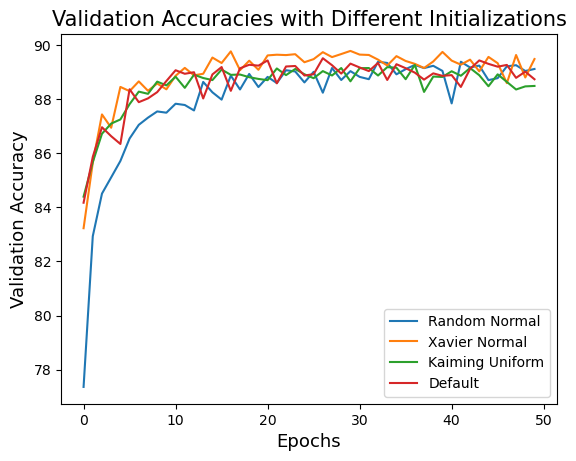

In [ ]:
plt.plot(init_RN_val_accuracy_list, label='Random Normal')
plt.plot(init_XN_val_accuracy_list, label='Xavier Normal')
plt.plot(init_KU_val_accuracy_list, label='Kaiming Uniform')
plt.plot(val_accuracy_list_adam_best, label='Default')

plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Validation Accuracy', fontsize=13)
plt.title('Validation Accuracies with Different Initializations', fontsize=15)

plt.legend()
plt.show()

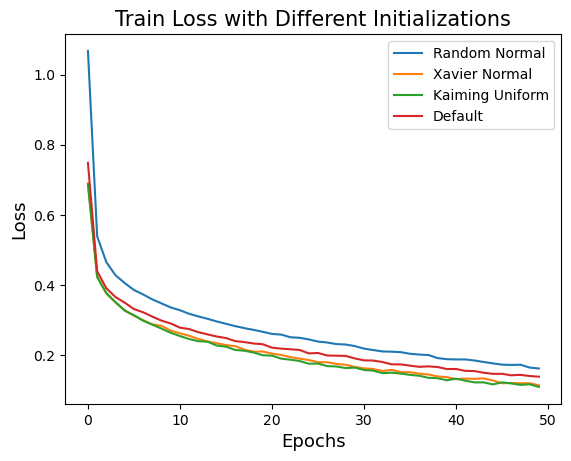

In [95]:


plt.plot(init_RN_train_loss_list, label='Random Normal')
plt.plot(init_XN_train_loss_list, label='Xavier Normal')
plt.plot(init_KU_train_loss_list, label='Kaiming Uniform')
plt.plot(train_loss_adam_best, label='Default')

plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.title('Train Loss with Different Initializations', fontsize=15)

plt.legend()
plt.show()

Xavier seems to be the best, Kaiming also very good

In paper, include a table of the means and standard devs of the train/test accuracies

### Batch Normalization

In [89]:
# batch normalize and train Adam model w/optimal LR and find accuracy mean and std
model_BN, BN_train_loss_list, BN_val_accuracy_list = training(hidden_layers=lay3, learning_rate=Adam_lr, epochs=epoch_num, optim='Adam', dropout_prob=0, initial='no', batchnorm='yes')
BN_test_acc_mean, BN_test_acc_std = test_accuracy(model_BN, test_batch_size=test_batch_size)
BN_train_acc_mean, BN_train_acc_std = np.mean(BN_val_accuracy_list), np.std(BN_val_accuracy_list)

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:10<08:22, 10.26s/it]

Epoch: 0; Validation Accuracy:84.31626471920289%


  4%|▍         | 2/50 [00:20<08:22, 10.46s/it]

Epoch: 1; Validation Accuracy:86.55952785326087%


  6%|▌         | 3/50 [00:30<07:50, 10.02s/it]

Epoch: 2; Validation Accuracy:87.70592730978262%


  8%|▊         | 4/50 [00:39<07:32,  9.85s/it]

Epoch: 3; Validation Accuracy:88.27700407608697%


 10%|█         | 5/50 [00:49<07:19,  9.77s/it]

Epoch: 4; Validation Accuracy:88.17864017210145%


 12%|█▏        | 6/50 [00:59<07:11,  9.80s/it]

Epoch: 5; Validation Accuracy:88.69310461956522%


 14%|█▍        | 7/50 [01:09<07:04,  9.87s/it]

Epoch: 6; Validation Accuracy:87.45541779891303%


 16%|█▌        | 8/50 [01:19<06:59,  9.98s/it]

Epoch: 7; Validation Accuracy:87.71441915760869%


 18%|█▊        | 9/50 [01:30<06:54, 10.12s/it]

Epoch: 8; Validation Accuracy:88.72777966485508%


 20%|██        | 10/50 [01:40<06:42, 10.07s/it]

Epoch: 9; Validation Accuracy:88.76245471014492%


 22%|██▏       | 11/50 [01:49<06:28,  9.95s/it]

Epoch: 10; Validation Accuracy:87.72715692934781%


 24%|██▍       | 12/50 [01:59<06:15,  9.87s/it]

Epoch: 11; Validation Accuracy:88.75891644021738%


 26%|██▌       | 13/50 [02:09<06:02,  9.78s/it]

Epoch: 12; Validation Accuracy:88.65418365036231%


 28%|██▊       | 14/50 [02:18<05:50,  9.72s/it]

Epoch: 13; Validation Accuracy:88.76316236413044%


 30%|███       | 15/50 [02:28<05:38,  9.67s/it]

Epoch: 14; Validation Accuracy:88.15811820652173%


 32%|███▏      | 16/50 [02:37<05:27,  9.62s/it]

Epoch: 15; Validation Accuracy:88.84949615036231%


 34%|███▍      | 17/50 [02:47<05:16,  9.60s/it]

Epoch: 16; Validation Accuracy:89.34202332427536%


 36%|███▌      | 18/50 [02:56<05:07,  9.62s/it]

Epoch: 17; Validation Accuracy:88.134765625%


 38%|███▊      | 19/50 [03:06<04:59,  9.65s/it]

Epoch: 18; Validation Accuracy:88.82118999094203%


 40%|████      | 20/50 [03:16<04:52,  9.75s/it]

Epoch: 19; Validation Accuracy:88.37182971014492%


 42%|████▏     | 21/50 [03:26<04:42,  9.75s/it]

Epoch: 20; Validation Accuracy:84.97579823369566%


 44%|████▍     | 22/50 [03:36<04:32,  9.73s/it]

Epoch: 21; Validation Accuracy:87.98403532608697%


 46%|████▌     | 23/50 [03:45<04:22,  9.71s/it]

Epoch: 22; Validation Accuracy:89.2663043478261%


 48%|████▊     | 24/50 [03:55<04:12,  9.71s/it]

Epoch: 23; Validation Accuracy:88.04277060688405%


 50%|█████     | 25/50 [04:05<04:03,  9.75s/it]

Epoch: 24; Validation Accuracy:89.18563179347827%


 52%|█████▏    | 26/50 [04:14<03:53,  9.73s/it]

Epoch: 25; Validation Accuracy:88.06400022644928%


 54%|█████▍    | 27/50 [04:24<03:42,  9.67s/it]

Epoch: 26; Validation Accuracy:89.26701200181158%


 56%|█████▌    | 28/50 [04:33<03:30,  9.57s/it]

Epoch: 27; Validation Accuracy:88.56643455615942%


 58%|█████▊    | 29/50 [04:43<03:20,  9.56s/it]

Epoch: 28; Validation Accuracy:88.56997282608697%


 60%|██████    | 30/50 [04:53<03:11,  9.60s/it]

Epoch: 29; Validation Accuracy:88.61384737318842%


 62%|██████▏   | 31/50 [05:02<03:04,  9.69s/it]

Epoch: 30; Validation Accuracy:89.13609601449276%


 64%|██████▍   | 32/50 [05:12<02:55,  9.74s/it]

Epoch: 31; Validation Accuracy:88.56784986413044%


 66%|██████▌   | 33/50 [05:22<02:43,  9.64s/it]

Epoch: 32; Validation Accuracy:88.90186254528986%


 68%|██████▊   | 34/50 [05:31<02:34,  9.66s/it]

Epoch: 33; Validation Accuracy:88.86931046195653%


 70%|███████   | 35/50 [05:41<02:25,  9.67s/it]

Epoch: 34; Validation Accuracy:89.25002830615942%


 72%|███████▏  | 36/50 [05:51<02:15,  9.66s/it]

Epoch: 35; Validation Accuracy:89.0334861865942%


 74%|███████▍  | 37/50 [06:00<02:04,  9.55s/it]

Epoch: 36; Validation Accuracy:88.19350090579711%


 76%|███████▌  | 38/50 [06:09<01:54,  9.52s/it]

Epoch: 37; Validation Accuracy:88.58129528985508%


 78%|███████▊  | 39/50 [06:19<01:45,  9.59s/it]

Epoch: 38; Validation Accuracy:89.09717504528986%


 80%|████████  | 40/50 [06:29<01:36,  9.63s/it]

Epoch: 39; Validation Accuracy:88.40013586956522%


 82%|████████▏ | 41/50 [06:39<01:27,  9.68s/it]

Epoch: 40; Validation Accuracy:88.62729279891303%


 84%|████████▍ | 42/50 [06:48<01:16,  9.57s/it]

Epoch: 41; Validation Accuracy:87.91326992753623%


 86%|████████▌ | 43/50 [06:58<01:06,  9.55s/it]

Epoch: 42; Validation Accuracy:88.69381227355072%


 88%|████████▊ | 44/50 [07:07<00:57,  9.59s/it]

Epoch: 43; Validation Accuracy:87.86514945652173%


 90%|█████████ | 45/50 [07:17<00:47,  9.58s/it]

Epoch: 44; Validation Accuracy:87.59128736413044%


 92%|█████████▏| 46/50 [07:26<00:38,  9.53s/it]

Epoch: 45; Validation Accuracy:88.36475317028986%


 94%|█████████▍| 47/50 [07:36<00:28,  9.55s/it]

Epoch: 46; Validation Accuracy:87.82410552536231%


 96%|█████████▌| 48/50 [07:45<00:19,  9.59s/it]

Epoch: 47; Validation Accuracy:87.38323709239131%


 98%|█████████▊| 49/50 [07:55<00:09,  9.50s/it]

Epoch: 48; Validation Accuracy:88.97262794384058%


100%|██████████| 50/50 [08:04<00:00,  9.70s/it]

Epoch: 49; Validation Accuracy:88.68744338768116%


Test Accuracy: 87.24609375% ; Std of batch accuracies: 0.024821598565988732


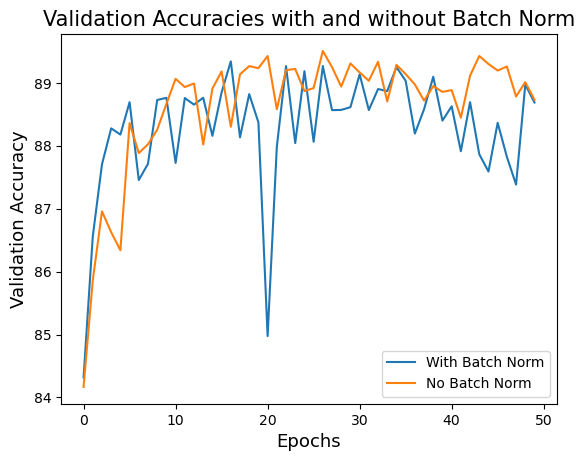

In [92]:
plt.plot(BN_val_accuracy_list, label='With Batch Norm')
plt.plot(val_accuracy_list_adam_best, label='No Batch Norm')

plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Validation Accuracy', fontsize=13)
plt.title('Validation Accuracies with and without Batch Norm', fontsize=15)

plt.legend()
plt.show()

In [91]:
# train and test means and standard devs with batch normalization
print(BN_train_acc_mean)
print(BN_train_acc_std)

print(BN_test_acc_mean)
print(BN_test_acc_std*100)

88.28921818387684
0.938489870471215
87.24609375
2.4821598565988734


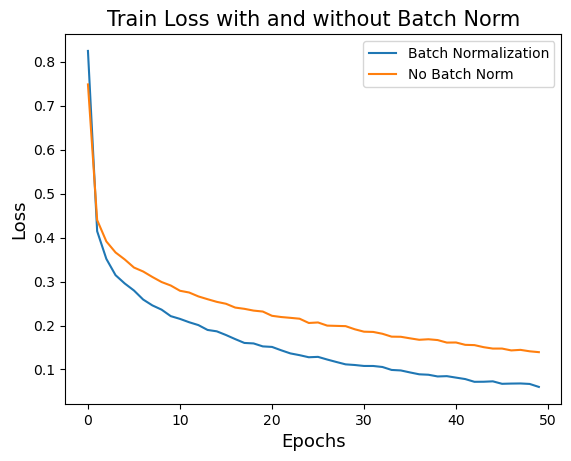

In [93]:
plt.plot(BN_train_loss_list, label='Batch Normalization')
plt.plot(train_loss_adam_best, label='No Batch Norm')

plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.title('Train Loss with and without Batch Norm', fontsize=15)

plt.legend()
plt.show()

In [ ]:
# 1024, 256
# dropout 0.5 for each hidden layer
# adam 0.001, beta 0.99
# kaiming uniform w batch normalization
# random normal was terrible

## Bonus

#### Hyperparameter Tuning to get 90% on Fashion MNIST

Attempt 1

In [97]:

model_opt, opt_train_loss_list, opt_val_accuracy_list = training(hidden_layers=lay3, learning_rate=Adam_lr, epochs=epoch_num, optim='Adam', dropout_prob=0, initial='XU', batchnorm='yes')
opt_test_acc_mean, opt_test_acc_std = test_accuracy(model_opt, test_batch_size=test_batch_size)
opt_train_acc_mean, opt_train_acc_std = np.mean(opt_val_accuracy_list), np.std(opt_val_accuracy_list)

  2%|▏         | 1/50 [00:11<08:59, 11.02s/it]

Epoch: 0; Validation Accuracy:84.53988337862319%


  4%|▍         | 2/50 [00:20<08:04, 10.08s/it]

Epoch: 1; Validation Accuracy:86.85178894927536%


  6%|▌         | 3/50 [00:29<07:41,  9.82s/it]

Epoch: 2; Validation Accuracy:87.48230865036231%


  8%|▊         | 4/50 [00:39<07:28,  9.75s/it]

Epoch: 3; Validation Accuracy:87.53538269927536%


 10%|█         | 5/50 [00:51<07:53, 10.53s/it]

Epoch: 4; Validation Accuracy:88.66762907608697%


 12%|█▏        | 6/50 [01:02<07:50, 10.70s/it]

Epoch: 5; Validation Accuracy:88.3987205615942%


 14%|█▍        | 7/50 [01:13<07:46, 10.84s/it]

Epoch: 6; Validation Accuracy:88.28337296195653%


 16%|█▌        | 8/50 [01:24<07:31, 10.75s/it]

Epoch: 7; Validation Accuracy:89.4446331521739%


 18%|█▊        | 9/50 [01:36<07:37, 11.15s/it]

Epoch: 8; Validation Accuracy:89.10354393115942%


 20%|██        | 10/50 [01:47<07:28, 11.21s/it]

Epoch: 9; Validation Accuracy:88.671875%


 22%|██▏       | 11/50 [01:59<07:22, 11.36s/it]

Epoch: 10; Validation Accuracy:88.57775701992753%


 24%|██▍       | 12/50 [02:10<07:07, 11.24s/it]

Epoch: 11; Validation Accuracy:89.08939085144928%


 26%|██▌       | 13/50 [02:21<06:52, 11.14s/it]

Epoch: 12; Validation Accuracy:88.26780457427536%


 28%|██▊       | 14/50 [02:31<06:36, 11.01s/it]

Epoch: 13; Validation Accuracy:88.97687386775362%


 30%|███       | 15/50 [02:43<06:29, 11.12s/it]

Epoch: 14; Validation Accuracy:89.07028419384058%


 32%|███▏      | 16/50 [02:54<06:19, 11.15s/it]

Epoch: 15; Validation Accuracy:89.35263813405797%


 34%|███▍      | 17/50 [03:04<06:00, 10.91s/it]

Epoch: 16; Validation Accuracy:89.03914741847827%


 36%|███▌      | 18/50 [03:16<05:54, 11.07s/it]

Epoch: 17; Validation Accuracy:88.94998301630434%


 38%|███▊      | 19/50 [03:27<05:46, 11.18s/it]

Epoch: 18; Validation Accuracy:89.59182518115942%


 40%|████      | 20/50 [03:38<05:36, 11.21s/it]

Epoch: 19; Validation Accuracy:89.18209352355072%


 42%|████▏     | 21/50 [03:49<05:20, 11.05s/it]

Epoch: 20; Validation Accuracy:89.38660552536231%


 44%|████▍     | 22/50 [04:00<05:09, 11.05s/it]

Epoch: 21; Validation Accuracy:89.11698935688405%


 46%|████▌     | 23/50 [04:11<04:56, 10.97s/it]

Epoch: 22; Validation Accuracy:88.96908967391303%


 48%|████▊     | 24/50 [04:22<04:43, 10.89s/it]

Epoch: 23; Validation Accuracy:89.09788269927536%


 50%|█████     | 25/50 [04:31<04:22, 10.49s/it]

Epoch: 24; Validation Accuracy:88.52468297101449%


 52%|█████▏    | 26/50 [04:41<04:04, 10.17s/it]

Epoch: 25; Validation Accuracy:89.30522531702898%


 54%|█████▍    | 27/50 [04:50<03:49,  9.96s/it]

Epoch: 26; Validation Accuracy:88.21685348731884%


 56%|█████▌    | 28/50 [05:00<03:37,  9.87s/it]

Epoch: 27; Validation Accuracy:86.72582653985508%


 58%|█████▊    | 29/50 [05:09<03:24,  9.75s/it]

Epoch: 28; Validation Accuracy:88.54166666666666%


 60%|██████    | 30/50 [05:19<03:13,  9.67s/it]

Epoch: 29; Validation Accuracy:88.57704936594203%


 62%|██████▏   | 31/50 [05:28<03:02,  9.60s/it]

Epoch: 30; Validation Accuracy:89.20120018115942%


 64%|██████▍   | 32/50 [05:38<02:53,  9.64s/it]

Epoch: 31; Validation Accuracy:89.37740602355072%


 66%|██████▌   | 33/50 [05:47<02:43,  9.61s/it]

Epoch: 32; Validation Accuracy:89.41632699275362%


 68%|██████▊   | 34/50 [05:57<02:33,  9.57s/it]

Epoch: 33; Validation Accuracy:89.33423913043478%


 70%|███████   | 35/50 [06:06<02:22,  9.52s/it]

Epoch: 34; Validation Accuracy:88.67045969202898%


 72%|███████▏  | 36/50 [06:16<02:12,  9.50s/it]

Epoch: 35; Validation Accuracy:88.12839673913044%


 74%|███████▍  | 37/50 [06:25<02:03,  9.48s/it]

Epoch: 36; Validation Accuracy:88.42985733695653%


 76%|███████▌  | 38/50 [06:35<01:53,  9.47s/it]

Epoch: 37; Validation Accuracy:88.63932291666666%


 78%|███████▊  | 39/50 [06:44<01:43,  9.44s/it]

Epoch: 38; Validation Accuracy:87.26647418478262%


 80%|████████  | 40/50 [06:54<01:34,  9.45s/it]

Epoch: 39; Validation Accuracy:88.8870018115942%


 82%|████████▏ | 41/50 [07:03<01:25,  9.45s/it]

Epoch: 40; Validation Accuracy:88.81977468297102%


 84%|████████▍ | 42/50 [07:12<01:15,  9.45s/it]

Epoch: 41; Validation Accuracy:88.79217617753623%


 86%|████████▌ | 43/50 [07:22<01:06,  9.45s/it]

Epoch: 42; Validation Accuracy:89.02782495471014%


 88%|████████▊ | 44/50 [07:32<00:57,  9.51s/it]

Epoch: 43; Validation Accuracy:88.95918251811595%


 90%|█████████ | 45/50 [07:41<00:47,  9.47s/it]

Epoch: 44; Validation Accuracy:88.52751358695653%


 92%|█████████▏| 46/50 [07:50<00:37,  9.49s/it]

Epoch: 45; Validation Accuracy:88.01800271739131%


 94%|█████████▍| 47/50 [08:00<00:28,  9.47s/it]

Epoch: 46; Validation Accuracy:88.51831408514492%


 96%|█████████▌| 48/50 [08:09<00:18,  9.45s/it]

Epoch: 47; Validation Accuracy:88.68107450181158%


 98%|█████████▊| 49/50 [08:19<00:09,  9.48s/it]

Epoch: 48; Validation Accuracy:87.28841145833334%


100%|██████████| 50/50 [08:28<00:00, 10.17s/it]

Epoch: 49; Validation Accuracy:89.04834692028986%


Test Accuracy: 88.10546875% ; Std of batch accuracies: 0.022113481012280015


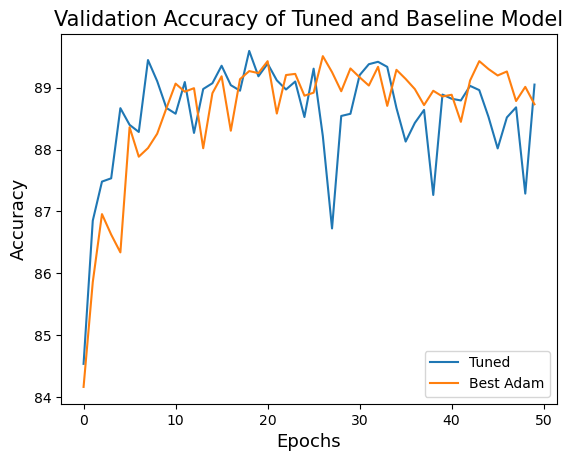

In [98]:
plt.plot(opt_val_accuracy_list, label='Tuned')
plt.plot(val_accuracy_list_adam_best, label='Best Adam')

plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.title('Validation Accuracy of Tuned and Baseline Model', fontsize=15)

plt.legend()
plt.show()

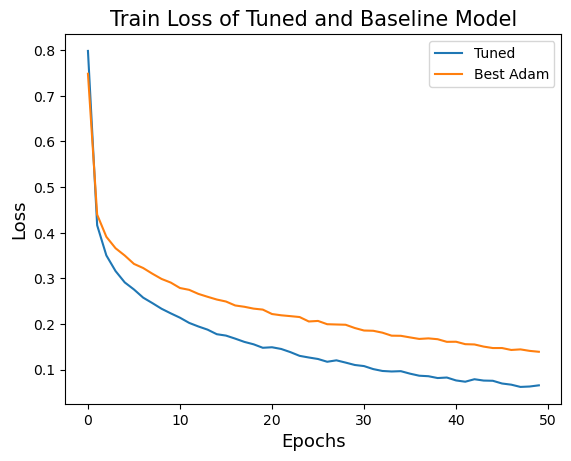

In [99]:
plt.plot(opt_train_loss_list, label='Tuned')
plt.plot(train_loss_adam_best, label='Best Adam')

plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.title('Train Loss of Tuned and Baseline Model', fontsize=15)

plt.legend()
plt.show()

Attempt 2

In [100]:

model_opt2, opt2_train_loss_list, opt2_val_accuracy_list = training(hidden_layers=[1024,512], learning_rate=Adam_lr, epochs=epoch_num, optim='Adam', dropout_prob=0, initial='XU', batchnorm='yes')
opt2_test_acc_mean, opt2_test_acc_std = test_accuracy(model_opt2, test_batch_size=test_batch_size)
opt2_train_acc_mean, opt2_train_acc_std = np.mean(opt2_val_accuracy_list), np.std(opt2_val_accuracy_list)

  2%|▏         | 1/50 [00:14<12:11, 14.93s/it]

Epoch: 0; Validation Accuracy:86.71521173007247%


  4%|▍         | 2/50 [00:29<11:35, 14.49s/it]

Epoch: 1; Validation Accuracy:87.63586956521738%


  6%|▌         | 3/50 [00:42<10:47, 13.77s/it]

Epoch: 2; Validation Accuracy:88.00243432971014%


  8%|▊         | 4/50 [00:56<10:38, 13.89s/it]

Epoch: 3; Validation Accuracy:89.59040987318842%


 10%|█         | 5/50 [01:08<09:55, 13.24s/it]

Epoch: 4; Validation Accuracy:88.96696671195653%


 12%|█▏        | 6/50 [01:25<10:46, 14.69s/it]

Epoch: 5; Validation Accuracy:89.01154891304347%


 14%|█▍        | 7/50 [01:37<09:55, 13.84s/it]

Epoch: 6; Validation Accuracy:88.30389492753623%


 16%|█▌        | 8/50 [01:49<09:13, 13.17s/it]

Epoch: 7; Validation Accuracy:88.99102694746377%


 18%|█▊        | 9/50 [02:01<08:46, 12.85s/it]

Epoch: 8; Validation Accuracy:89.69938858695653%


 20%|██        | 10/50 [02:13<08:26, 12.66s/it]

Epoch: 9; Validation Accuracy:90.36599864130434%


 22%|██▏       | 11/50 [02:25<08:02, 12.38s/it]

Epoch: 10; Validation Accuracy:89.77723052536231%


 24%|██▍       | 12/50 [02:38<07:50, 12.38s/it]

Epoch: 11; Validation Accuracy:89.09434442934781%


 26%|██▌       | 13/50 [02:52<07:56, 12.87s/it]

Epoch: 12; Validation Accuracy:89.1318500905797%


 28%|██▊       | 14/50 [03:04<07:38, 12.75s/it]

Epoch: 13; Validation Accuracy:88.79996037137681%


 30%|███       | 15/50 [03:16<07:17, 12.51s/it]

Epoch: 14; Validation Accuracy:89.42906476449276%


 32%|███▏      | 16/50 [03:28<06:59, 12.34s/it]

Epoch: 15; Validation Accuracy:89.72769474637681%


 34%|███▍      | 17/50 [03:40<06:45, 12.29s/it]

Epoch: 16; Validation Accuracy:88.66833673007247%


 36%|███▌      | 18/50 [03:53<06:34, 12.34s/it]

Epoch: 17; Validation Accuracy:89.40995810688405%


 38%|███▊      | 19/50 [04:04<06:16, 12.15s/it]

Epoch: 18; Validation Accuracy:88.75750113224638%


 40%|████      | 20/50 [04:16<05:59, 11.98s/it]

Epoch: 19; Validation Accuracy:89.89753170289855%


 42%|████▏     | 21/50 [04:29<06:00, 12.42s/it]

Epoch: 20; Validation Accuracy:89.44534080615942%


 44%|████▍     | 22/50 [04:41<05:44, 12.29s/it]

Epoch: 21; Validation Accuracy:90.26551177536231%


 46%|████▌     | 23/50 [04:53<05:26, 12.11s/it]

Epoch: 22; Validation Accuracy:90.05109261775362%


 48%|████▊     | 24/50 [05:05<05:11, 11.99s/it]

Epoch: 23; Validation Accuracy:89.4326030344203%


 50%|█████     | 25/50 [05:17<04:59, 11.96s/it]

Epoch: 24; Validation Accuracy:89.94352921195653%


 52%|█████▏    | 26/50 [05:29<04:50, 12.10s/it]

Epoch: 25; Validation Accuracy:90.08506000905797%


 54%|█████▍    | 27/50 [05:41<04:36, 12.04s/it]

Epoch: 26; Validation Accuracy:88.74476336050724%


 56%|█████▌    | 28/50 [05:53<04:24, 12.03s/it]

Epoch: 27; Validation Accuracy:90.25843523550724%


 58%|█████▊    | 29/50 [06:07<04:28, 12.78s/it]

Epoch: 28; Validation Accuracy:89.5104449728261%


 60%|██████    | 30/50 [06:19<04:10, 12.51s/it]

Epoch: 29; Validation Accuracy:90.3893512228261%


 62%|██████▏   | 31/50 [06:31<03:54, 12.35s/it]

Epoch: 30; Validation Accuracy:90.2916949728261%


 64%|██████▍   | 32/50 [06:43<03:38, 12.11s/it]

Epoch: 31; Validation Accuracy:89.47647758152173%


 66%|██████▌   | 33/50 [06:54<03:23, 11.97s/it]

Epoch: 32; Validation Accuracy:90.26905004528986%


 68%|██████▊   | 34/50 [07:06<03:10, 11.93s/it]

Epoch: 33; Validation Accuracy:89.40005095108697%


 70%|███████   | 35/50 [07:18<02:57, 11.82s/it]

Epoch: 34; Validation Accuracy:90.15865602355072%


 72%|███████▏  | 36/50 [07:29<02:44, 11.73s/it]

Epoch: 35; Validation Accuracy:90.69010416666666%


 74%|███████▍  | 37/50 [07:41<02:32, 11.72s/it]

Epoch: 36; Validation Accuracy:89.85507246376811%


 76%|███████▌  | 38/50 [07:53<02:20, 11.68s/it]

Epoch: 37; Validation Accuracy:90.48063858695653%


 78%|███████▊  | 39/50 [08:04<02:07, 11.61s/it]

Epoch: 38; Validation Accuracy:90.32000113224638%


 80%|████████  | 40/50 [08:16<01:56, 11.62s/it]

Epoch: 39; Validation Accuracy:89.29319519927536%


 82%|████████▏ | 41/50 [08:28<01:46, 11.87s/it]

Epoch: 40; Validation Accuracy:89.8232280344203%


 84%|████████▍ | 42/50 [08:40<01:35, 11.92s/it]

Epoch: 41; Validation Accuracy:89.85153419384058%


 86%|████████▌ | 43/50 [08:52<01:22, 11.78s/it]

Epoch: 42; Validation Accuracy:88.92238451086956%


 88%|████████▊ | 44/50 [09:03<01:10, 11.78s/it]

Epoch: 43; Validation Accuracy:88.17864017210145%


 90%|█████████ | 45/50 [09:17<01:01, 12.20s/it]

Epoch: 44; Validation Accuracy:90.05109261775362%


 92%|█████████▏| 46/50 [09:29<00:48, 12.14s/it]

Epoch: 45; Validation Accuracy:90.21668365036231%


 94%|█████████▍| 47/50 [09:41<00:36, 12.10s/it]

Epoch: 46; Validation Accuracy:90.54857336956522%


 96%|█████████▌| 48/50 [09:52<00:24, 12.01s/it]

Epoch: 47; Validation Accuracy:89.81968976449276%


 98%|█████████▊| 49/50 [10:04<00:11, 11.95s/it]

Epoch: 48; Validation Accuracy:90.61155457427536%


100%|██████████| 50/50 [10:16<00:00, 12.33s/it]

Epoch: 49; Validation Accuracy:90.17776268115942%


Test Accuracy: 89.287109375% ; Std of batch accuracies: 0.02605629065298385


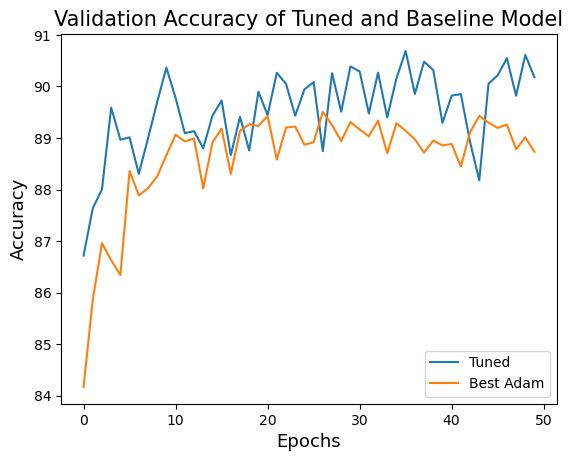

In [101]:
plt.plot(opt2_val_accuracy_list, label='Tuned')
plt.plot(val_accuracy_list_adam_best, label='Best Adam')

plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.title('Validation Accuracy of Tuned and Baseline Model', fontsize=15)

plt.legend()
plt.show()

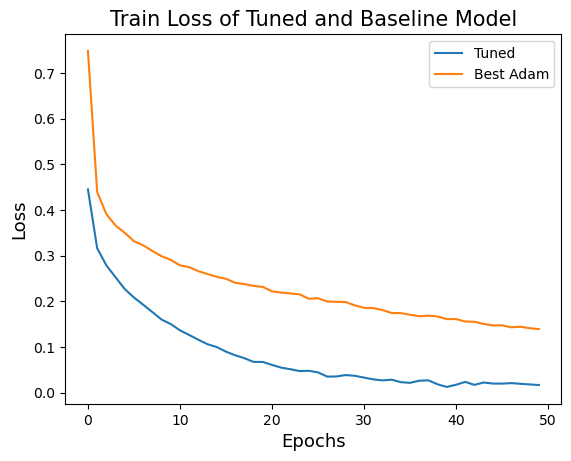

In [102]:
plt.plot(opt2_train_loss_list, label='Tuned')
plt.plot(train_loss_adam_best, label='Best Adam')

plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.title('Train Loss of Tuned and Baseline Model', fontsize=15)

plt.legend()
plt.show()

Attempt 3

In [103]:

model_opt3, opt3_train_loss_list, opt3_val_accuracy_list = training(hidden_layers=[1024,512], learning_rate=Adam_lr, epochs=epoch_num, optim='Adam', dropout_prob=0.4, initial='XU', batchnorm='yes')
opt3_test_acc_mean, opt3_test_acc_std = test_accuracy(model_opt3, test_batch_size=test_batch_size)
opt3_train_acc_mean, opt3_train_acc_std = np.mean(opt3_val_accuracy_list), np.std(opt3_val_accuracy_list)

  2%|▏         | 1/50 [00:12<10:23, 12.73s/it]

Epoch: 0; Validation Accuracy:86.67275249094203%


  4%|▍         | 2/50 [00:26<10:50, 13.56s/it]

Epoch: 1; Validation Accuracy:87.44338768115942%


  6%|▌         | 3/50 [00:40<10:42, 13.67s/it]

Epoch: 2; Validation Accuracy:89.02287137681158%


  8%|▊         | 4/50 [00:52<10:00, 13.06s/it]

Epoch: 3; Validation Accuracy:88.31592504528986%


 10%|█         | 5/50 [01:05<09:36, 12.82s/it]

Epoch: 4; Validation Accuracy:85.64877717391303%


 12%|█▏        | 6/50 [01:17<09:21, 12.75s/it]

Epoch: 5; Validation Accuracy:89.04905457427536%


 14%|█▍        | 7/50 [01:32<09:30, 13.28s/it]

Epoch: 6; Validation Accuracy:87.82481317934781%


 16%|█▌        | 8/50 [01:46<09:26, 13.48s/it]

Epoch: 7; Validation Accuracy:88.54945086050724%


 18%|█▊        | 9/50 [02:00<09:25, 13.80s/it]

Epoch: 8; Validation Accuracy:89.30168704710145%


 20%|██        | 10/50 [02:13<08:59, 13.48s/it]

Epoch: 9; Validation Accuracy:89.01296422101449%


 22%|██▏       | 11/50 [02:26<08:41, 13.38s/it]

Epoch: 10; Validation Accuracy:87.67974411231884%


 24%|██▍       | 12/50 [02:39<08:18, 13.11s/it]

Epoch: 11; Validation Accuracy:89.90743885869566%


 26%|██▌       | 13/50 [02:51<07:55, 12.85s/it]

Epoch: 12; Validation Accuracy:89.60597826086956%


 28%|██▊       | 14/50 [03:05<07:55, 13.21s/it]

Epoch: 13; Validation Accuracy:90.82738903985508%


 30%|███       | 15/50 [03:17<07:35, 13.01s/it]

Epoch: 14; Validation Accuracy:89.96900475543478%


 32%|███▏      | 16/50 [03:30<07:21, 12.98s/it]

Epoch: 15; Validation Accuracy:89.61447010869566%


 34%|███▍      | 17/50 [03:44<07:14, 13.16s/it]

Epoch: 16; Validation Accuracy:89.72061820652173%


 36%|███▌      | 18/50 [03:58<07:10, 13.45s/it]

Epoch: 17; Validation Accuracy:89.21252264492753%


 38%|███▊      | 19/50 [04:11<06:49, 13.22s/it]

Epoch: 18; Validation Accuracy:89.75317028985508%


 40%|████      | 20/50 [04:22<06:22, 12.76s/it]

Epoch: 19; Validation Accuracy:87.42852694746377%


 42%|████▏     | 21/50 [04:34<06:01, 12.46s/it]

Epoch: 20; Validation Accuracy:90.0595844655797%


 44%|████▍     | 22/50 [04:46<05:43, 12.27s/it]

Epoch: 21; Validation Accuracy:89.3639605978261%


 46%|████▌     | 23/50 [04:58<05:26, 12.11s/it]

Epoch: 22; Validation Accuracy:89.77935348731884%


 48%|████▊     | 24/50 [05:09<05:11, 12.00s/it]

Epoch: 23; Validation Accuracy:88.59969429347827%


 50%|█████     | 25/50 [05:21<04:58, 11.93s/it]

Epoch: 24; Validation Accuracy:90.35043025362319%


 52%|█████▏    | 26/50 [05:34<04:50, 12.11s/it]

Epoch: 25; Validation Accuracy:88.10150588768116%


 54%|█████▍    | 27/50 [05:46<04:42, 12.30s/it]

Epoch: 26; Validation Accuracy:89.57271852355072%


 56%|█████▌    | 28/50 [06:00<04:36, 12.56s/it]

Epoch: 27; Validation Accuracy:90.45728600543478%


 58%|█████▊    | 29/50 [06:13<04:29, 12.82s/it]

Epoch: 28; Validation Accuracy:89.72981770833334%


 60%|██████    | 30/50 [06:27<04:20, 13.02s/it]

Epoch: 29; Validation Accuracy:90.83517323369566%


 62%|██████▏   | 31/50 [06:40<04:11, 13.23s/it]

Epoch: 30; Validation Accuracy:89.9697124094203%


 64%|██████▍   | 32/50 [06:56<04:13, 14.07s/it]

Epoch: 31; Validation Accuracy:90.45516304347827%


 66%|██████▌   | 33/50 [07:09<03:52, 13.65s/it]

Epoch: 32; Validation Accuracy:90.38510529891303%


 68%|██████▊   | 34/50 [07:21<03:29, 13.09s/it]

Epoch: 33; Validation Accuracy:88.91743093297102%


 70%|███████   | 35/50 [07:32<03:10, 12.69s/it]

Epoch: 34; Validation Accuracy:90.36246037137681%


 72%|███████▏  | 36/50 [07:45<02:56, 12.62s/it]

Epoch: 35; Validation Accuracy:90.44808650362319%


 74%|███████▍  | 37/50 [07:58<02:44, 12.62s/it]

Epoch: 36; Validation Accuracy:90.19191576086956%


 76%|███████▌  | 38/50 [08:13<02:41, 13.50s/it]

Epoch: 37; Validation Accuracy:90.4211956521739%


 78%|███████▊  | 39/50 [08:25<02:23, 13.07s/it]

Epoch: 38; Validation Accuracy:90.34618432971014%


 80%|████████  | 40/50 [08:37<02:07, 12.72s/it]

Epoch: 39; Validation Accuracy:88.65913722826087%


 82%|████████▏ | 41/50 [08:51<01:56, 12.95s/it]

Epoch: 40; Validation Accuracy:89.69231204710145%


 84%|████████▍ | 42/50 [09:03<01:43, 12.94s/it]

Epoch: 41; Validation Accuracy:89.92654551630434%


 86%|████████▌ | 43/50 [09:15<01:28, 12.58s/it]

Epoch: 42; Validation Accuracy:90.30089447463769%


 88%|████████▊ | 44/50 [09:27<01:13, 12.32s/it]

Epoch: 43; Validation Accuracy:90.44667119565219%


 90%|█████████ | 45/50 [09:39<01:00, 12.19s/it]

Epoch: 44; Validation Accuracy:90.29594089673913%


 92%|█████████▏| 46/50 [09:52<00:49, 12.41s/it]

Epoch: 45; Validation Accuracy:90.3893512228261%


 94%|█████████▍| 47/50 [10:04<00:36, 12.32s/it]

Epoch: 46; Validation Accuracy:90.26551177536231%


 96%|█████████▌| 48/50 [10:16<00:24, 12.23s/it]

Epoch: 47; Validation Accuracy:89.58757925724638%


 98%|█████████▊| 49/50 [10:28<00:12, 12.15s/it]

Epoch: 48; Validation Accuracy:89.13326539855072%


100%|██████████| 50/50 [10:41<00:00, 12.83s/it]

Epoch: 49; Validation Accuracy:90.14237998188405%


Test Accuracy: 89.12109375% ; Std of batch accuracies: 0.01726169178898664


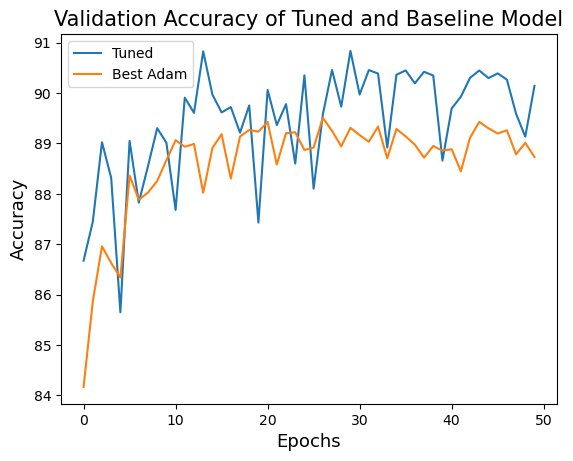

In [104]:
plt.plot(opt3_val_accuracy_list, label='Tuned')
plt.plot(val_accuracy_list_adam_best, label='Best Adam')

plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.title('Validation Accuracy of Tuned and Baseline Model', fontsize=15)

plt.legend()
plt.show()

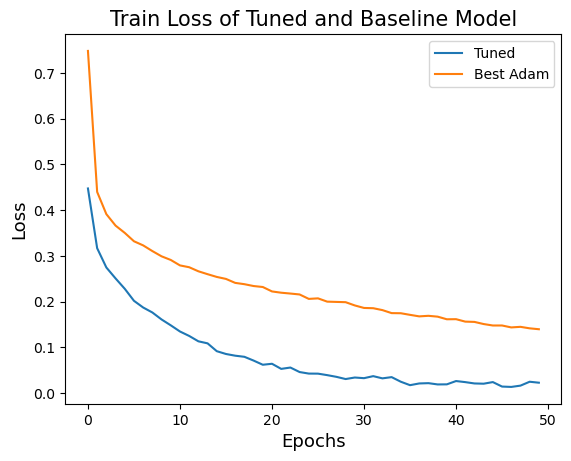

In [105]:
plt.plot(opt3_train_loss_list, label='Tuned')
plt.plot(train_loss_adam_best, label='Best Adam')

plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.title('Train Loss of Tuned and Baseline Model', fontsize=15)

plt.legend()
plt.show()

### Try on MNIST

In [109]:
# Use the following code to load and normalize the dataset for training and testing
# It will downlad the dataset into data subfolder (change to your data folder name)
train_digits = torchvision.datasets.MNIST('data hw3/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_digits = torchvision.datasets.MNIST('data hw3/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:04<00:00, 2054021.76it/s]


Extracting data hw3/MNIST/raw/train-images-idx3-ubyte.gz to data hw3/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 451012.69it/s]


Extracting data hw3/MNIST/raw/train-labels-idx1-ubyte.gz to data hw3/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 4394929.23it/s]


Extracting data hw3/MNIST/raw/t10k-images-idx3-ubyte.gz to data hw3/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 3641852.18it/s]

Extracting data hw3/MNIST/raw/t10k-labels-idx1-ubyte.gz to data hw3/MNIST/raw

